<a href="https://colab.research.google.com/github/allanonymouscode/NeurIPS/blob/main/Main_body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning for prediction of electron-impact widths and shifts: a step towards reliable Stark parameters for multiply charged ions

# Imports

In [2]:
!pip install pytorch-tabnet
!git clone -b main https://github.com/allanonymouscode/NeurIPS

Cloning into 'NeurIPS'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 11), reused 76 (delta 11), pack-reused 0
Unpacking objects: 100% (76/76), 4.31 MiB | 9.28 MiB/s, done.


In [3]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
import lightgbm
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

import pytorch_tabnet
os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
os.environ['patchfile'] = os.path.abspath(os.path.join('NeurIPS', 'float64.patch'))
if os.name == 'nt':
    !cd /d %tabnet% & patch < "%patchfile%"
else:
    !cd $tabnet && patch -f < $patchfile
importlib.reload(pytorch_tabnet)

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [4]:
import NeurIPS
import NeurIPS.utils.optuning
import NeurIPS.models.base_models
import NeurIPS.utils.metrics
import NeurIPS.utils.terms
import NeurIPS.utils.testset
import NeurIPS.utils.plotting
import NeurIPS.models.tabnet

importlib.reload(NeurIPS.models.base_models)
importlib.reload(NeurIPS.utils.optuning)
importlib.reload(NeurIPS.utils.metrics)
importlib.reload(NeurIPS.utils.plotting)
importlib.reload(NeurIPS.models.tabnet)

from NeurIPS.models.base_models import *
from NeurIPS.utils.optuning import *
from NeurIPS.utils.metrics import *
from NeurIPS.utils.terms import *
from NeurIPS.utils.testset import *
from NeurIPS.utils.plotting import *
from NeurIPS.models.tabnet import *
from NeurIPS.utils import *
from pytorch_tabnet.tab_model import  TabNetRegressor
clear_output()

# Data preprocessing

In [ ]:
#Import data for training and testing
a_data = pd.read_excel(NeurIPS.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BD'
                   )
#Replace term symbols with quantum numbers
a_data['Term'] = term_to_number(a_data['Term'])
a_data['Term.1'] = term_to_number(a_data['Term.1'])


#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != a_data.columns[i]:
        if name in a_data.columns:
            print(f'renaming {name}')
            a_data = a_data.rename(columns = {name: name+'.1'})
        a_data.insert(i, data_i.columns[i], 0)
        
a_data.insert(a_data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
a_data['Gap to ion'] = gap_to_ion(a_data, 'E upper')

C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()
C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()


renaming 6d
renaming 7p


C:\Users\Alex\Documents\GitHub\Stark_ML\utils\terms.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  gap = pd.Series()


In [ ]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [ ]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
a_data_width = a_data[np.isnan(a_data['w (A)']) == False]
a_data_width_elements = a_data_width.loc[a_data_width['Element'].isin(elements_to_exclude)]
a_data_width = a_data_width.drop(a_data_width_elements.index)
a_data_width = a_data_width.sort_values(by=['Z number'])

#Separate targets from data
a_target_width = a_data_width['w (A)']
a_target_width_elements = a_data_width_elements['w (A)']

#Separate labels from data
a_label_width = a_data_width.loc[:, ['Element', 'Wavelength']]
a_label_width_elements = a_data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
a_data_width = a_data_width.drop(columns = ['d (A)', 'w (A)'])
a_data_width_elements = a_data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [ ]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(a_data_width,
                                              a_target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(a_data_width,
                                                a_target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(a_data_width,
                                                a_target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

#print(target_test_q4[target_test_q4 > 70])

#Combining quartiles into full test dataset
a_data_width_test, a_target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
a_data_width_test, a_target_width_test = pd.concat([a_data_width_test, data_test_q3]), pd.concat([a_target_width_test, target_test_q3])
a_data_width_test, a_target_width_test = pd.concat([a_data_width_test, data_test_q4]), pd.concat([a_target_width_test, target_test_q4])

#Remove test entries from data -> get train set
a_data_width_train, a_target_width_train = a_data_width.drop(a_data_width_test.index), a_target_width.drop(a_target_width_test.index)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_21540\1657555531.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


In [ ]:
#Step 4. Augmentation. Applied only to train set
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
a_data_width_train_extended = a_data_width_train.copy()
a_target_width_train_extended = a_target_width_train
for index, row in a_data_width_train.iterrows():
    row['T'] = row['T']*factor
    a_data_width_train_extended = pd.concat([a_data_width_train_extended, row.to_frame().T], ignore_index=True)
    a_target_width_train_extended = pd.concat([a_target_width_train_extended, pd.Series(a_target_width_train.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    a_data_width_train_extended = pd.concat([a_data_width_train_extended, row.to_frame().T], ignore_index=True)
    a_target_width_train_extended = pd.concat([a_target_width_train_extended, pd.Series(a_target_width_train.loc[index])], ignore_index=True)
a_data_width_train_extended = a_data_width_train_extended.astype(a_data_width_train.dtypes.to_dict())

In [ ]:
a_data_width_test = a_data_width_test.drop(columns = ['Element', 'Wavelength', 'Z number'])
a_data_width_elements = a_data_width_elements.drop(columns = ['Element', 'Wavelength', 'Z number'])

## -- *OPTIONAL*-- Width data visual description

In [ ]:
data_width.describe()

Wavelength    Z number          1s          2s          2p  \
count   897.000000  897.000000  897.000000  897.000000  897.000000   
mean    437.237659   14.851728    1.769231    1.612040    3.460424   
std     216.218894   15.978406    0.421560    0.737235    2.179154   
min     113.416500    2.000000    1.000000    0.000000    0.000000   
25%     283.999000    6.000000    2.000000    2.000000    1.000000   
50%     471.315614    7.000000    2.000000    2.000000    3.000000   
75%     541.520000   26.000000    2.000000    2.000000    6.000000   
max    2058.130000   82.000000    2.000000    2.000000    6.000000   

               3s          3p          3d          4s          4p  ...  \
count  897.000000  897.000000  897.000000  897.000000  897.000000  ...   
mean     0.858417    1.943144    2.469342    0.332219    0.749164  ...   
std      0.905723    2.720643    3.995171    0.687093    1.679233  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
50%      1.000000    0.000000    0.000000    0.000000    0.000000  ...   
75%      2.000000    6.000000    7.000000    0.000000    1.000000  ...   
max      2.000000    6.000000   10.000000    2.000000    6.000000  ...   

               8p          8d          9s         10s  Multiplicity.1  \
count  897.000000  897.000000  897.000000  897.000000      897.000000   
mean     0.001115    0.002230    0.001115    0.001115        2.899666   
std      0.033389    0.047193    0.033389    0.033389        1.247752   
min      0.000000    0.000000    0.000000    0.000000        1.000000   
25%      0.000000    0.000000    0.000000    0.000000        2.000000   
50%      0.000000    0.000000    0.000000    0.000000        3.000000   
75%      0.000000    0.000000    0.000000    0.000000        4.000000   
max      1.000000    1.000000    1.000000    1.000000        7.000000   

           Term.1    Parity.1         J.1       E upper             T  
count  897.000000  897.000000  897.000000  8.970000e+02    897.000000  
mean     1.544036    0.603122    1.827202  2.113072e+05  16462.332219  
std      1.312079    0.489523    1.432334  3.325359e+06   9439.627870  
min      0.000000    0.000000    0.000000  1.173231e+04   2950.000000  
25%      1.000000    0.000000    1.000000  5.387426e+04  10970.000000  
50%      1.000000    1.000000    1.500000  8.848342e+04  12500.000000  
75%      2.000000    1.000000    2.000000  1.184278e+05  20800.000000  
max      5.000000    1.000000    7.000000  9.968131e+07  50000.000000  

[8 rows x 52 columns]

In [ ]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


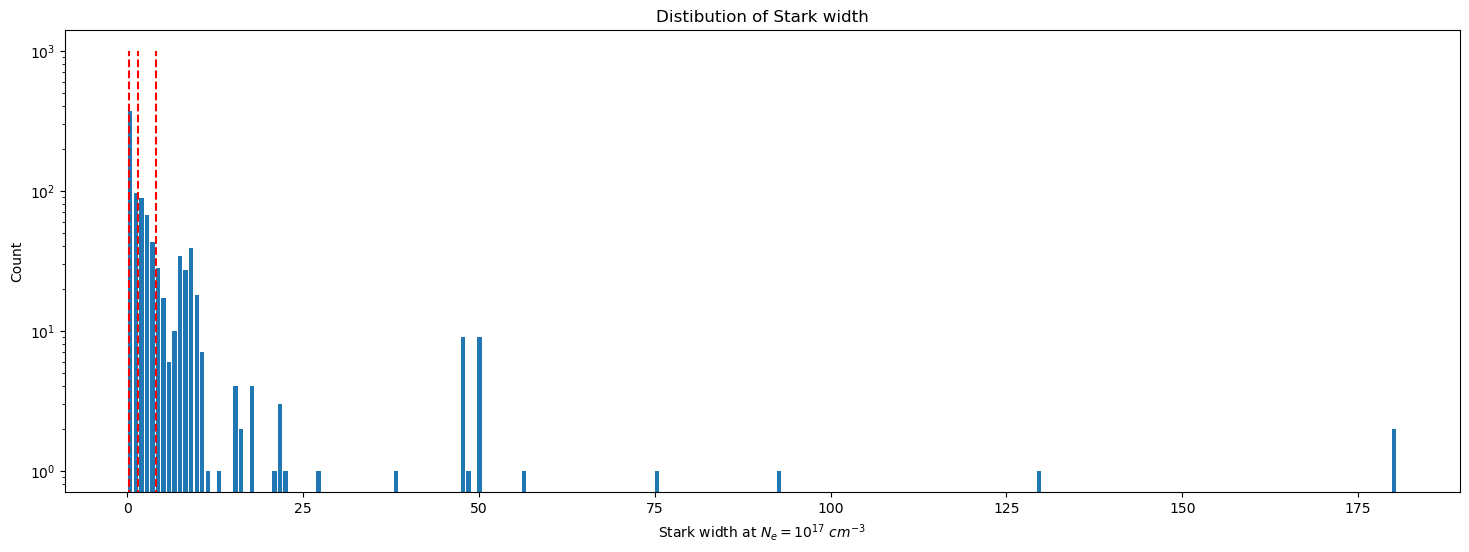

In [ ]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_17728\248873214.py:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2,

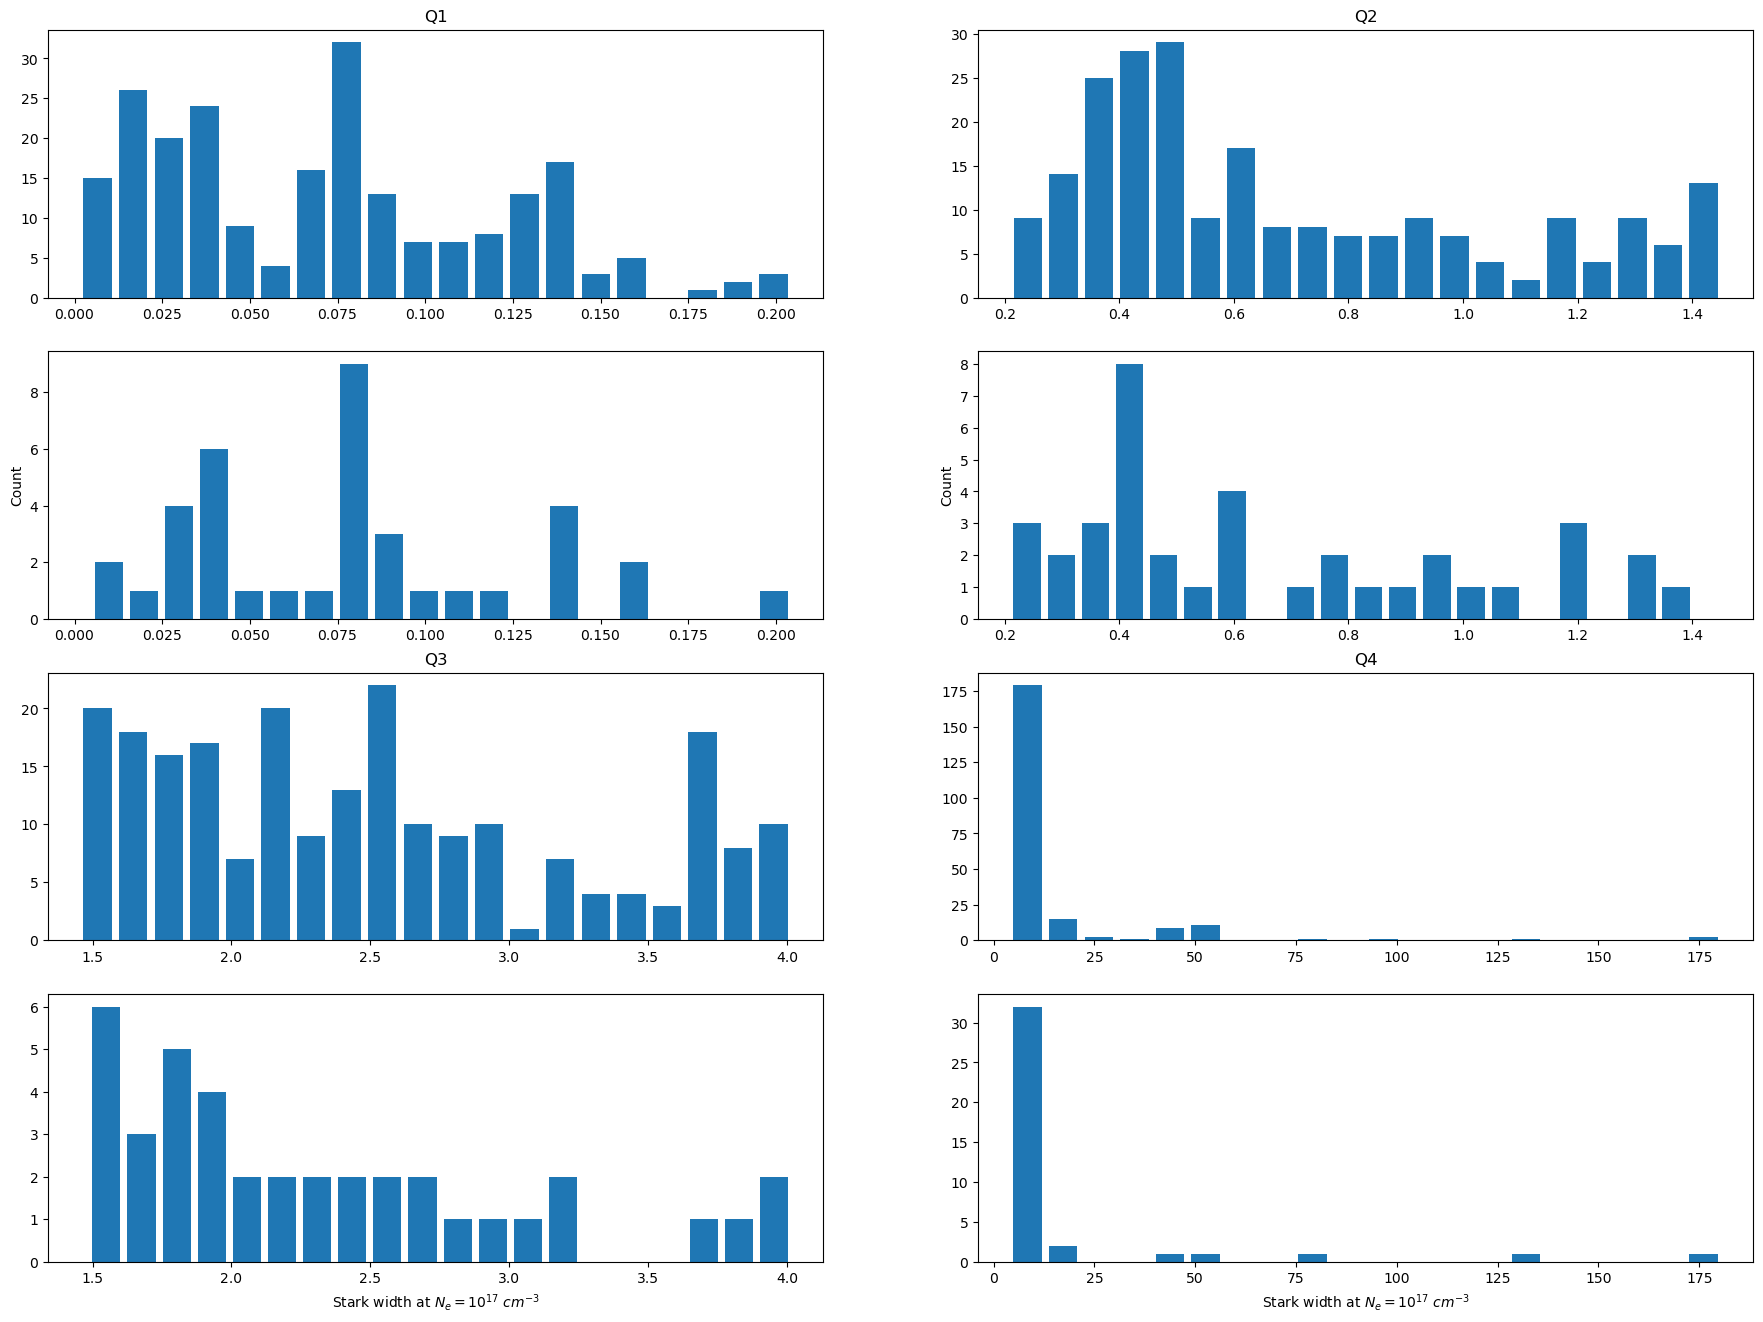

In [ ]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

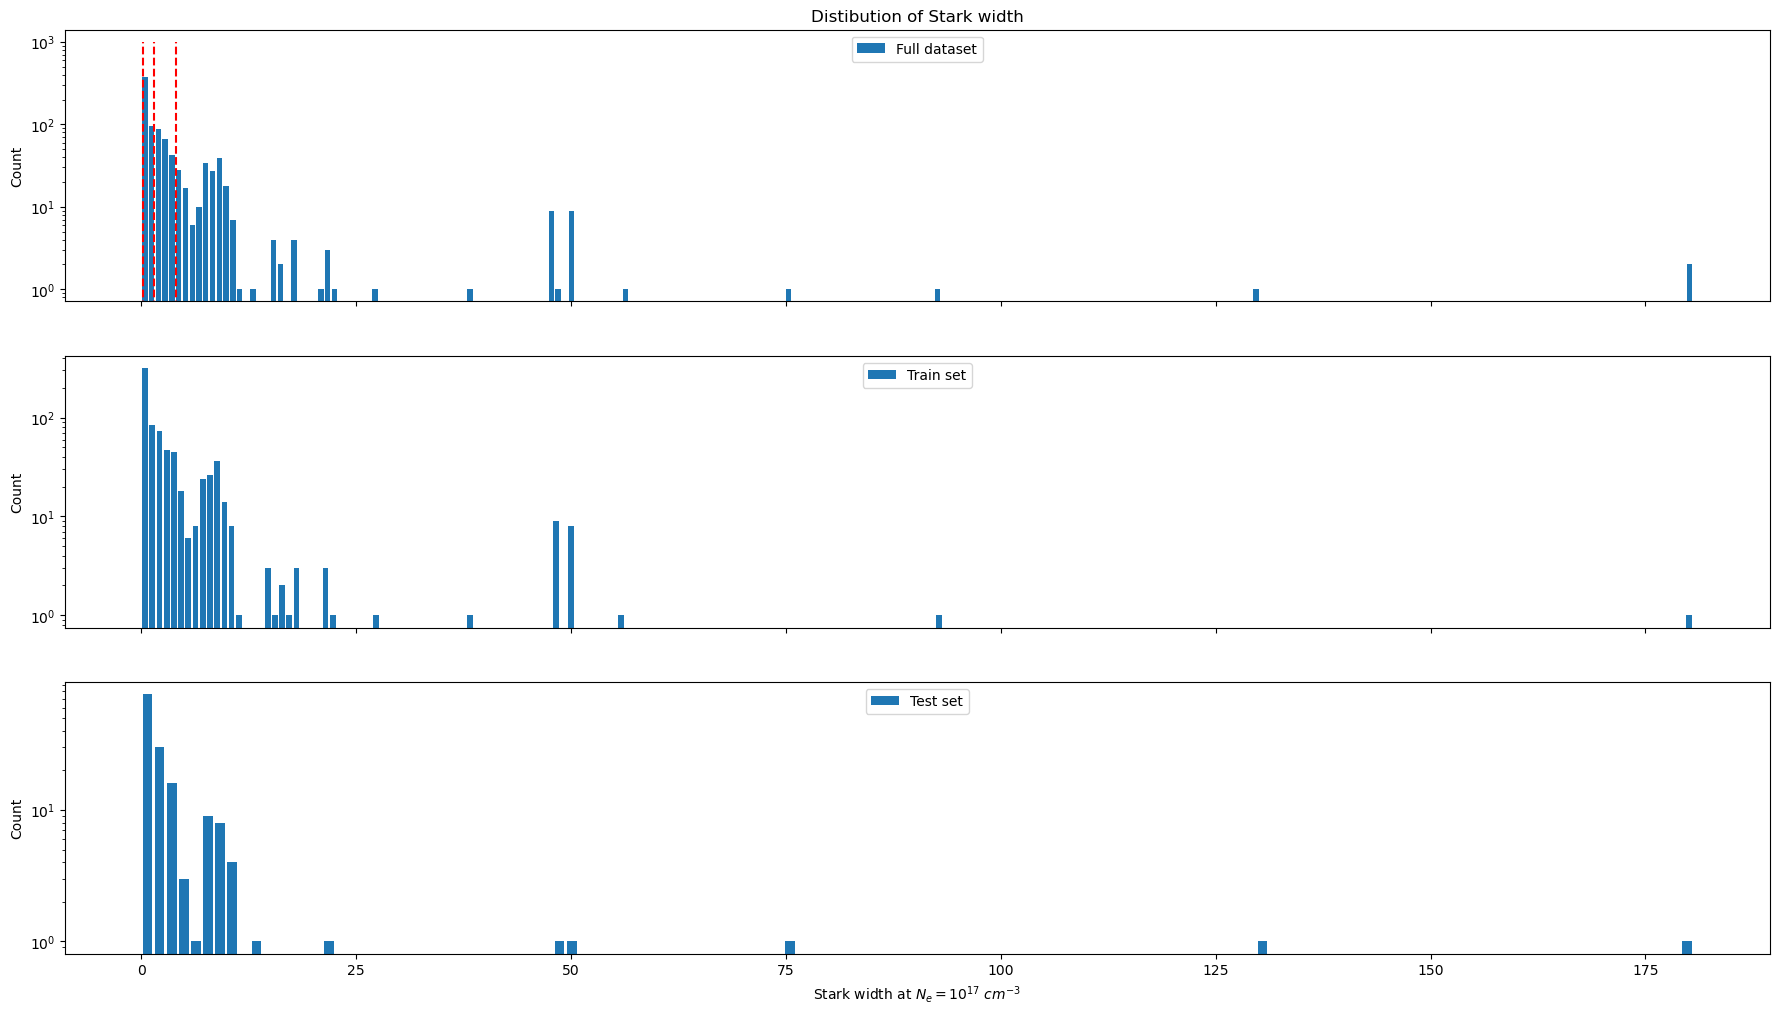

In [ ]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

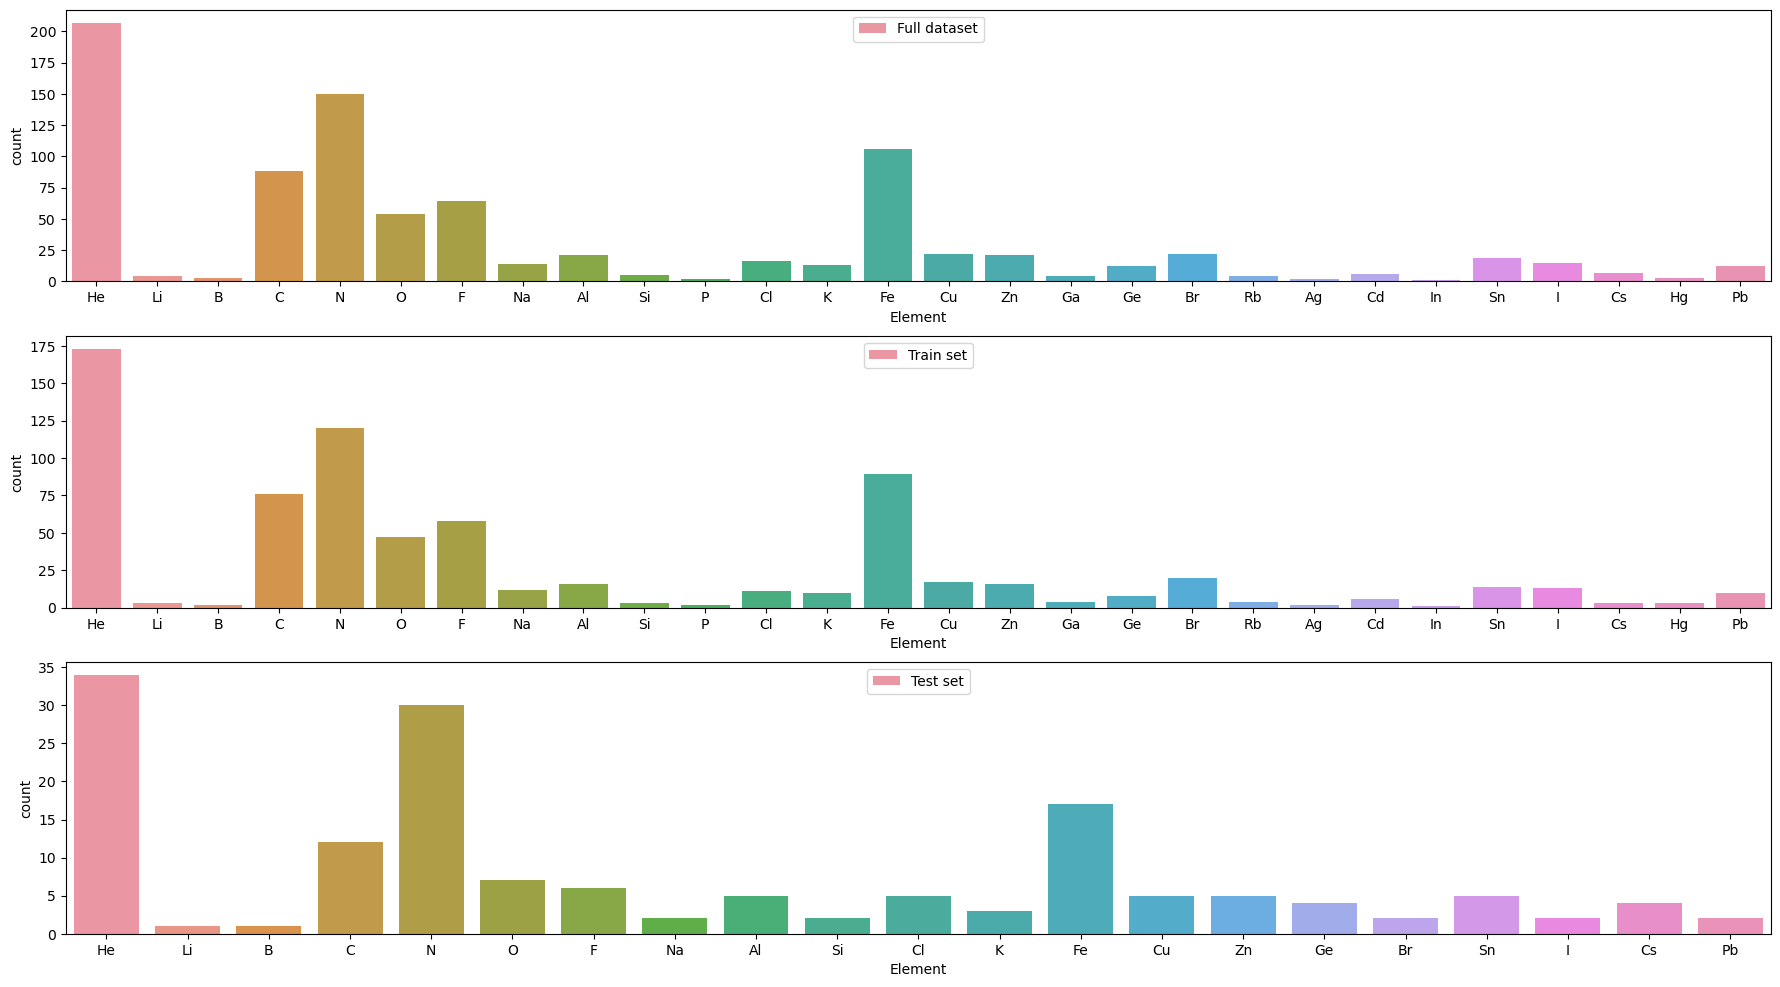

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Ions data

In [5]:
#Import data for training and testing
data_a = pd.read_excel(NeurIPS.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BD'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

/content/NeurIPS/utils/terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()
/content/NeurIPS/utils/terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()


In [6]:
#Import ions data for training and testing
data_i = pd.read_excel(NeurIPS.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BM'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]

/content/NeurIPS/utils/terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()
/content/NeurIPS/utils/terms.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  momentum = pd.Series()


In [7]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
renaming 6d
6d
renaming 7p
7p
5f.1
5g
6f
6g
11s


In [8]:
#merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

/content/NeurIPS/utils/terms.py:33: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  gap = pd.Series()


In [9]:
#Step 1.
#Exclude elements for testing
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

In [10]:
#Step 2.
#Creating data, targets and labels for the process of width prediction
data_width = data[data['w (A)'].isna() == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

#Separate targets from data
target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

#Separate labels from data
label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]

#Remove width and shift values from data
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

In [11]:
#Step 3.
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)
#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)
#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)
#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
#manually selected and fixed random state that gives the closest train and test distributios  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

#Combining quartiles into full test dataset
data_width_test, target_width_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q3]), pd.concat([target_width_test, target_test_q3])
data_width_test, target_width_test = pd.concat([data_width_test, data_test_q4]), pd.concat([target_width_test, target_test_q4])

#Remove test entries from data -> get train set
data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

<ipython-input-11-c3263fead97c>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


In [12]:
#Step 4. Augmentation. Applied only to train set
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_train_extended = data_width_train.copy()
target_width_train_extended = target_width_train
for index, row in data_width_train.iterrows():
    row['T'] = row['T']*factor
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_train_extended = pd.concat([data_width_train_extended, row.to_frame().T], ignore_index=True)
    target_width_train_extended = pd.concat([target_width_train_extended, pd.Series(target_width_train.loc[index])], ignore_index=True)
data_width_train_extended = data_width_train_extended.astype(data_width_train.dtypes.to_dict())

## -- *OPTIONAL*-- Atoms + ions data visual description

In [13]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    3574.000000
mean        1.686131
std         6.748343
min         0.001500
25%         0.200000
50%         0.400000
75%         1.200000
max       180.500000
Name: w (A), dtype: float64


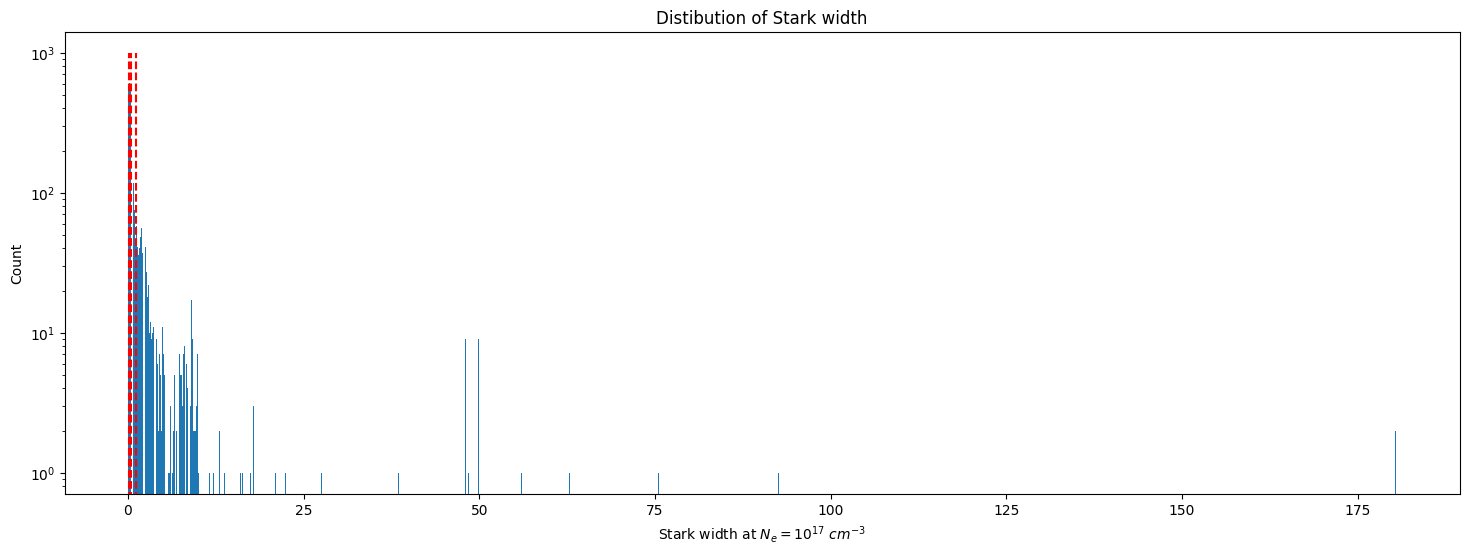

In [14]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

<ipython-input-15-3d8ce1c69243>:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
<ipython-input-15-3d8ce1c69243>:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
<ipython-input-15-3d8ce1c69243>:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
<ipython-input-15-3d8ce1c69243>:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])


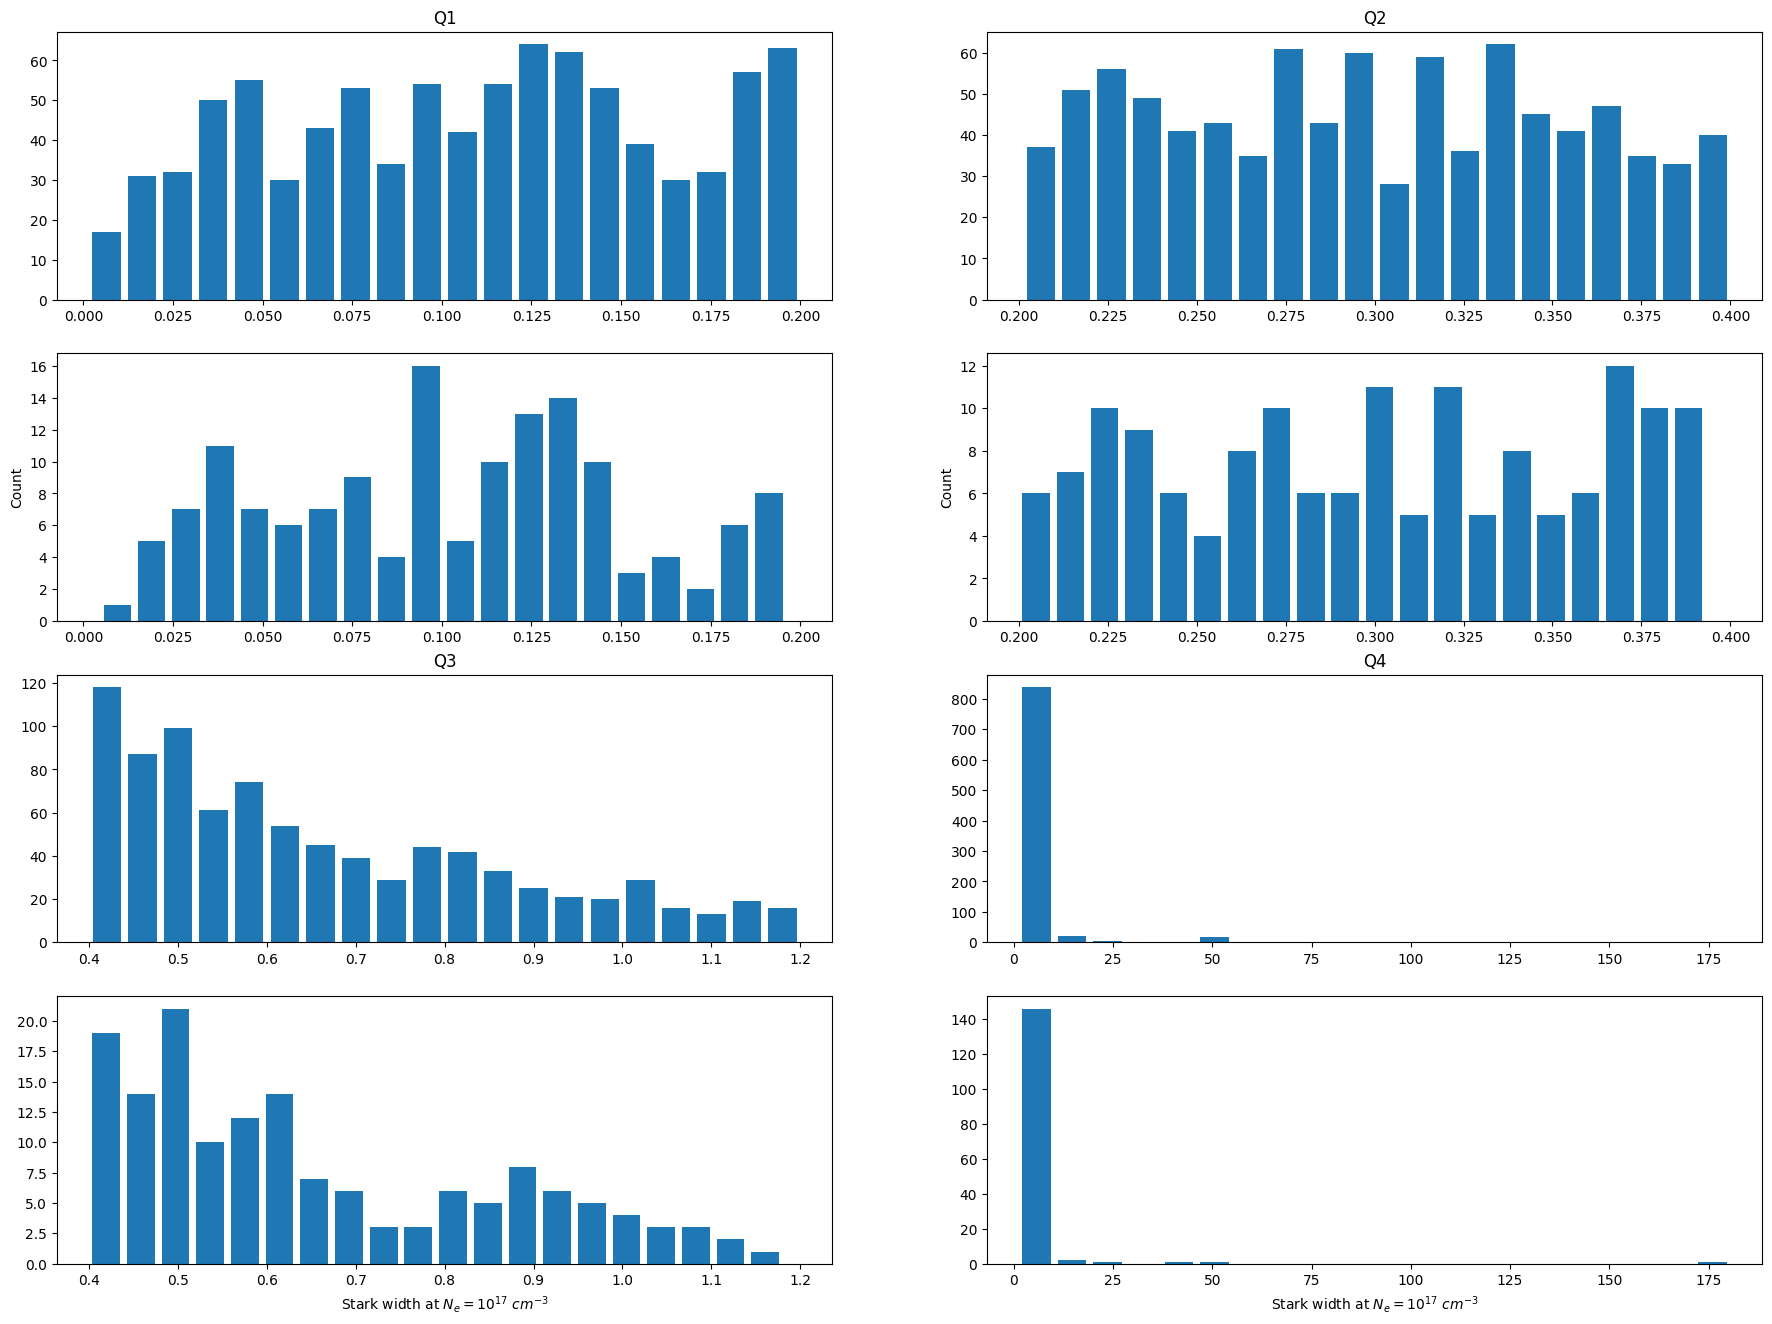

In [15]:
#Plotting train-test distributions
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

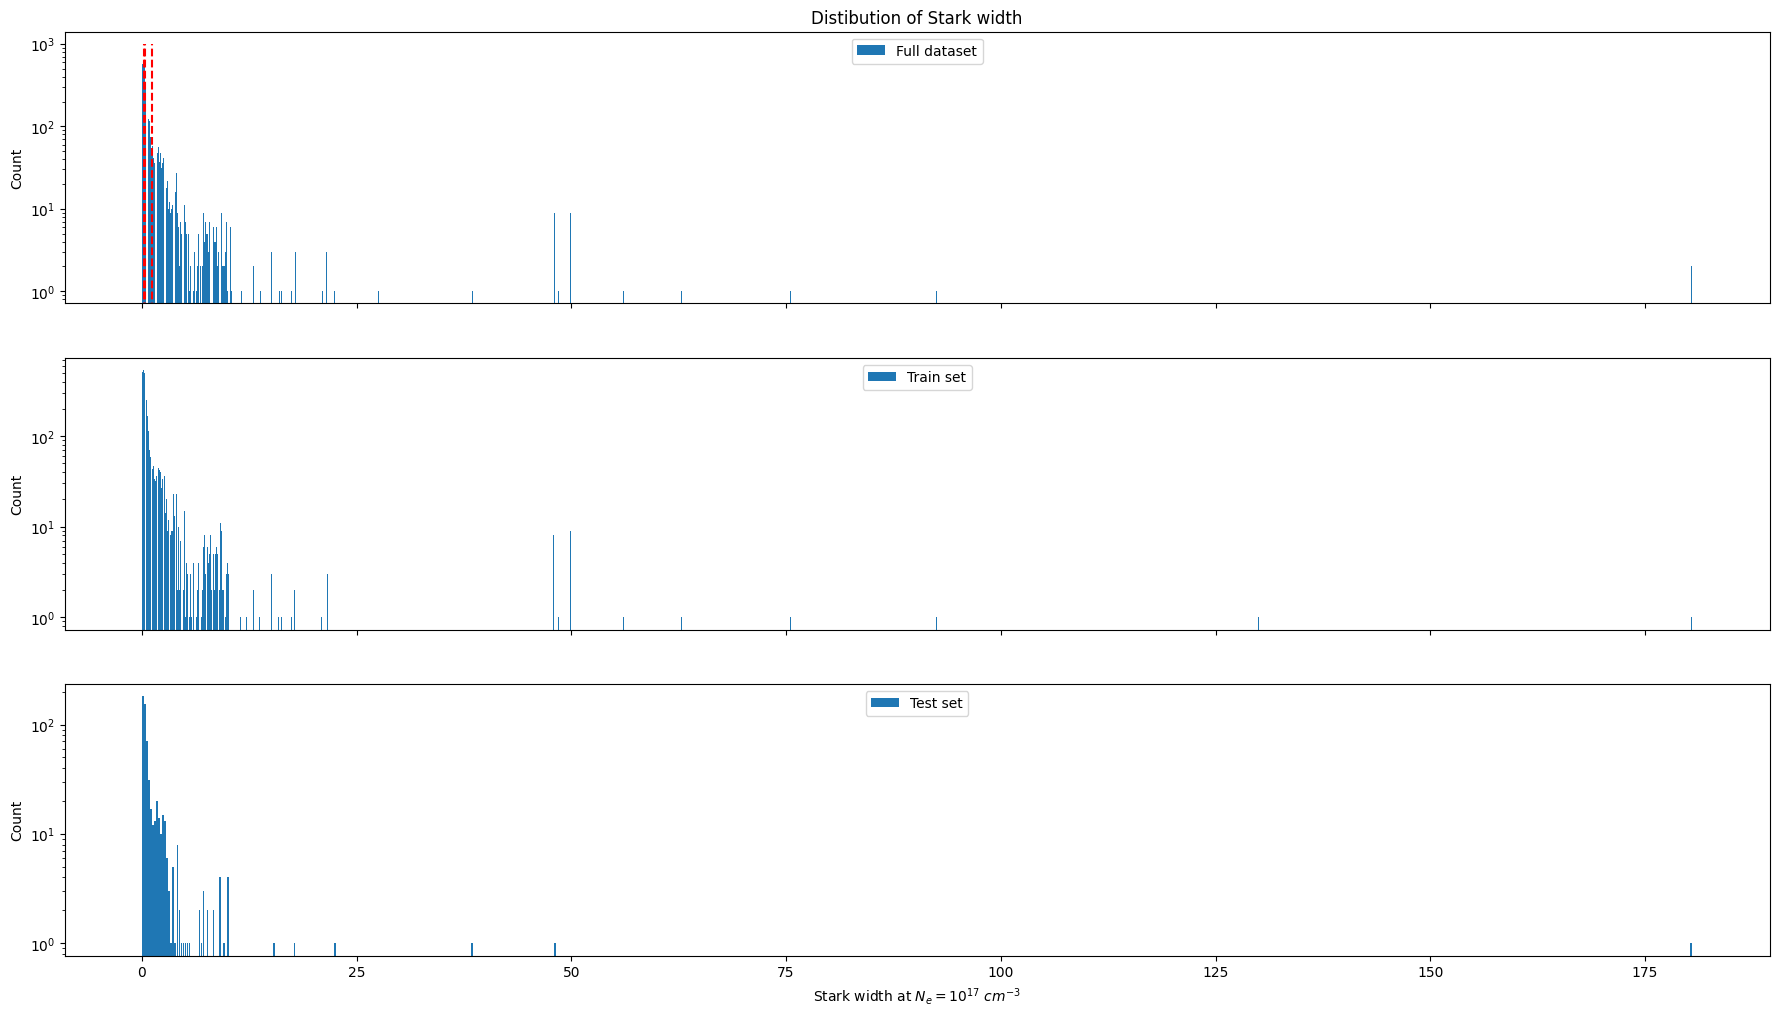

In [16]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

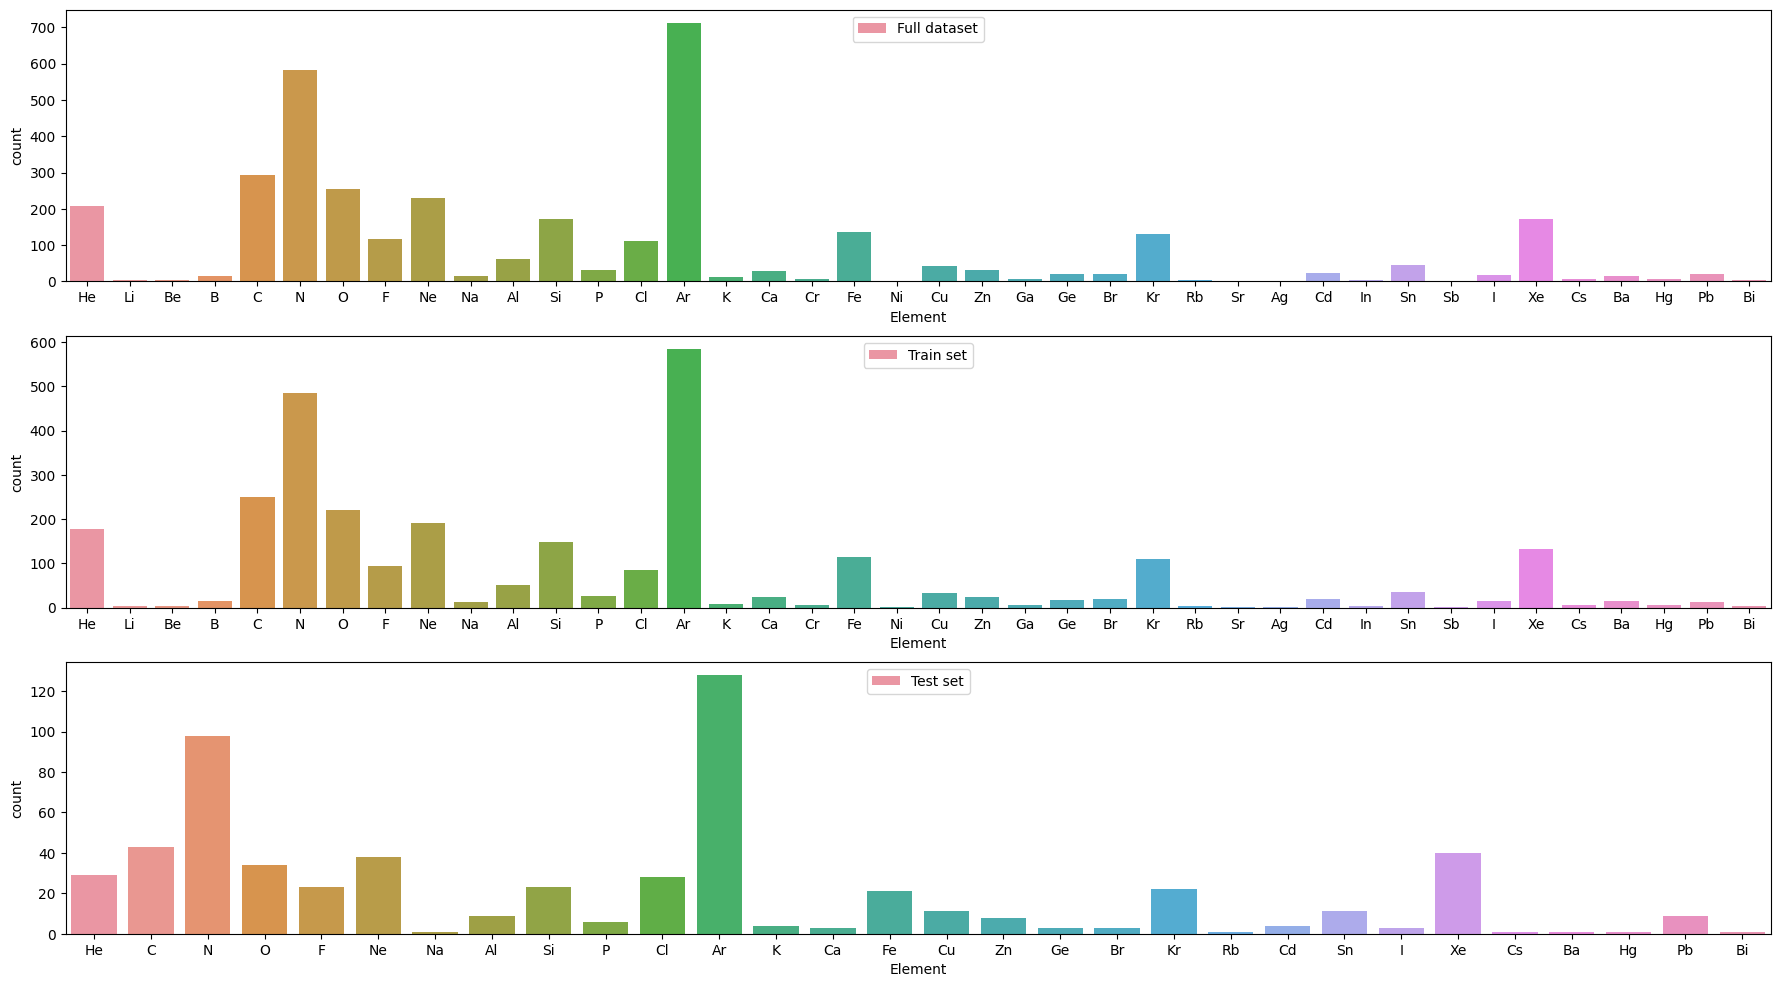

In [17]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Shift data preprocessing

In [18]:
#Creating data, target and labels for shift prediction
data_shift = data[data['d (A)'].isna() == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]

In [19]:
#Split into train and test by quartiles
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
    data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
#Merging full train and test datasets
data_shift_test, target_shift_test = pd.concat([data_test_q1, data_test_q2]), pd.concat([target_test_q1, target_test_q2])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q3]), pd.concat([target_shift_test, target_test_q3])
data_shift_test, target_shift_test = pd.concat([data_shift_test, data_test_q4]), pd.concat([target_shift_test, target_test_q4])

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

<ipython-input-19-e1a2b1897dfc>:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  target_test_q4 = pd.Series()


## -- *OPTIONAL*-- Shift data visual description 

In [20]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

count    1220.000000
mean        0.582145
std         2.134892
min        -7.485437
25%        -0.030000
50%         0.038459
75%         0.250000
max        20.000000
Name: d (A), dtype: float64


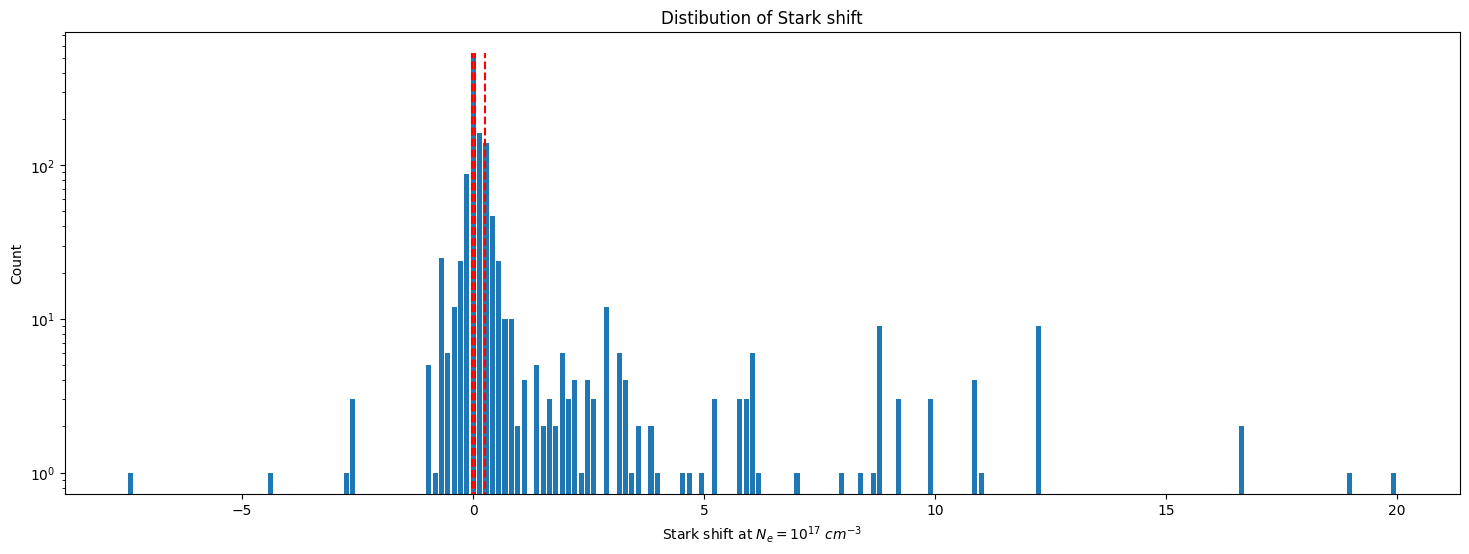

In [21]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins=200, log=True, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = np.max(n), ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

<ipython-input-22-9c98c9a4bf53>:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
<ipython-input-22-9c98c9a4bf53>:19: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
<ipython-input-22-9c98c9a4bf53>:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
<ipython-input-22-9c98c9a4bf53>:21: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])


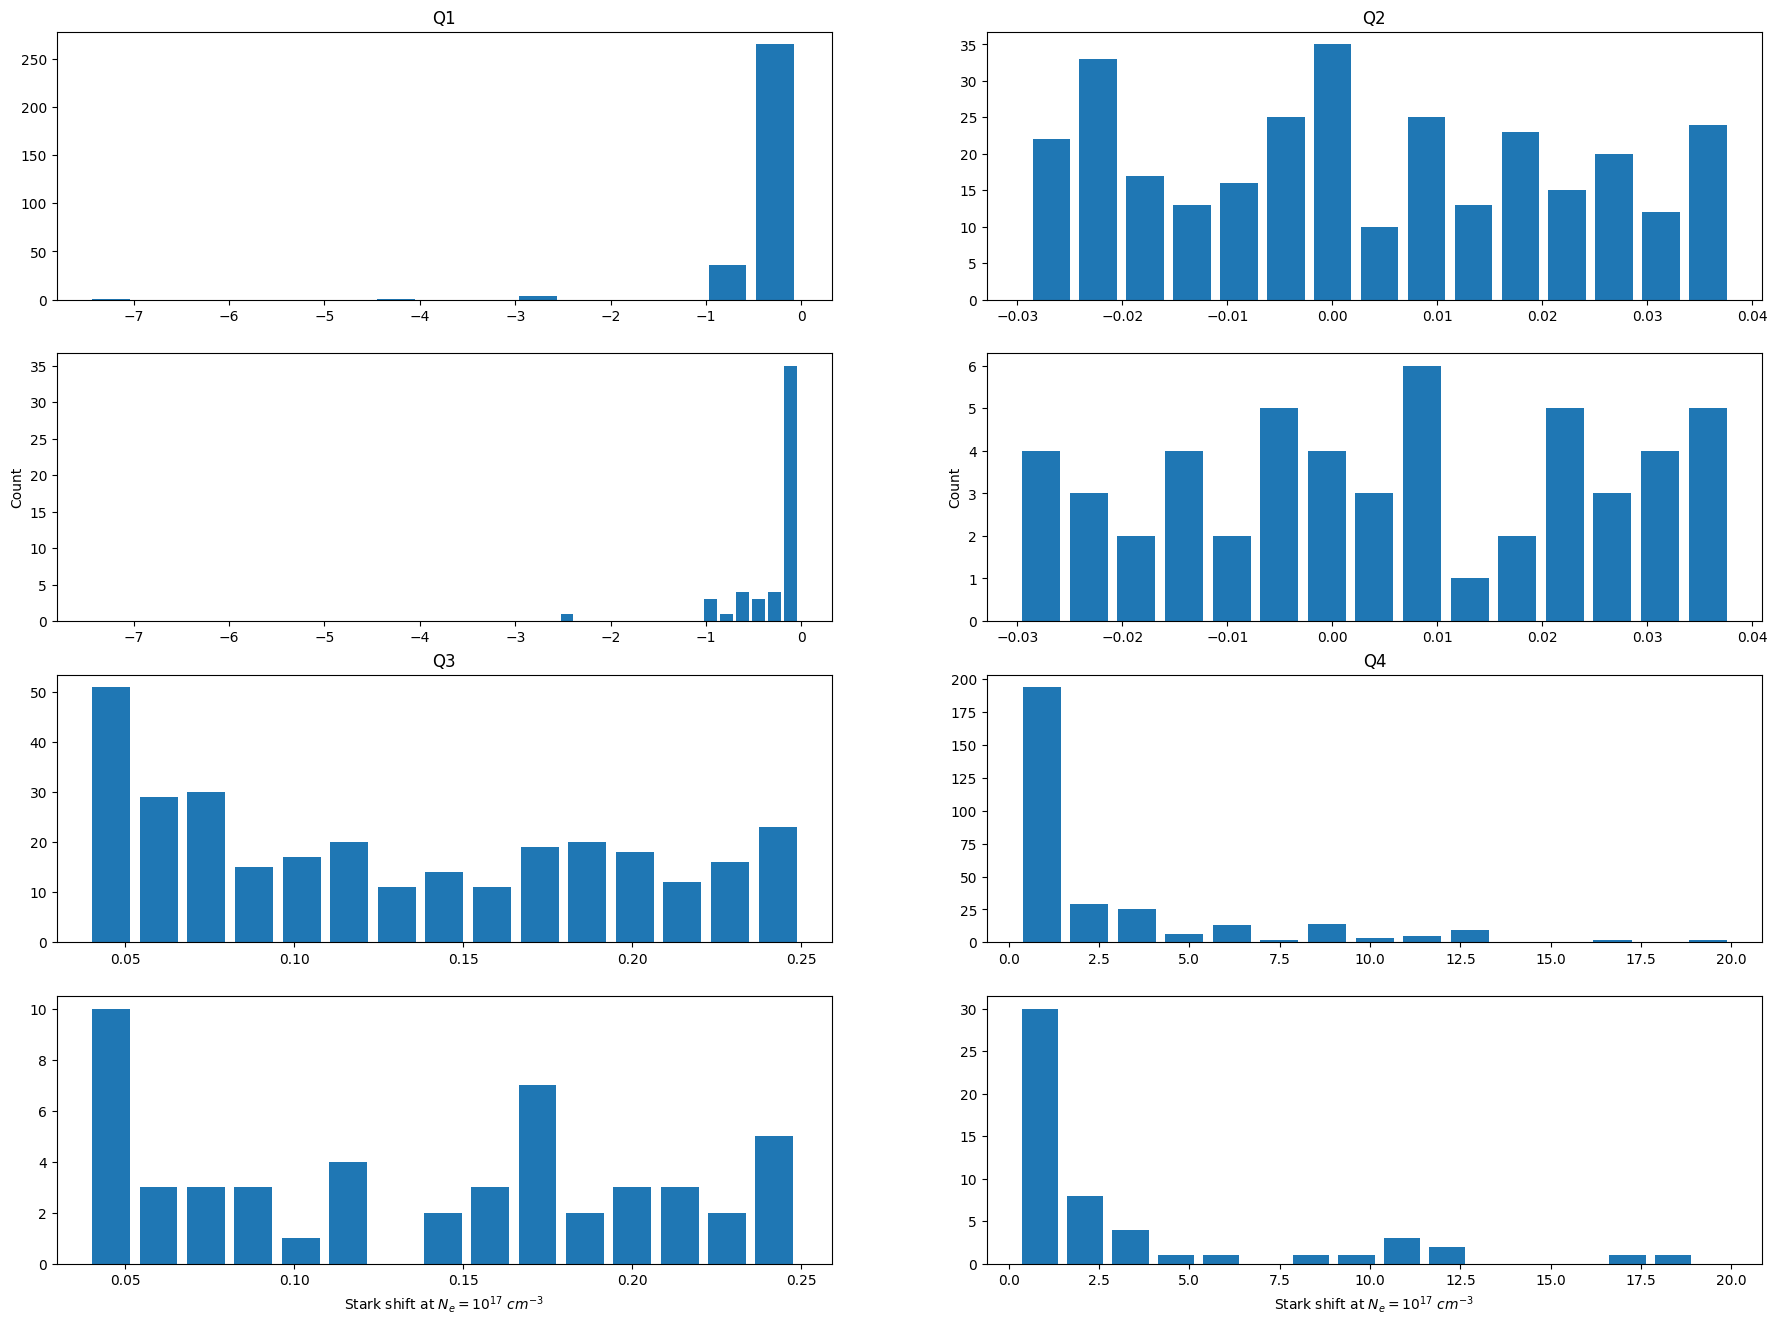

In [22]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

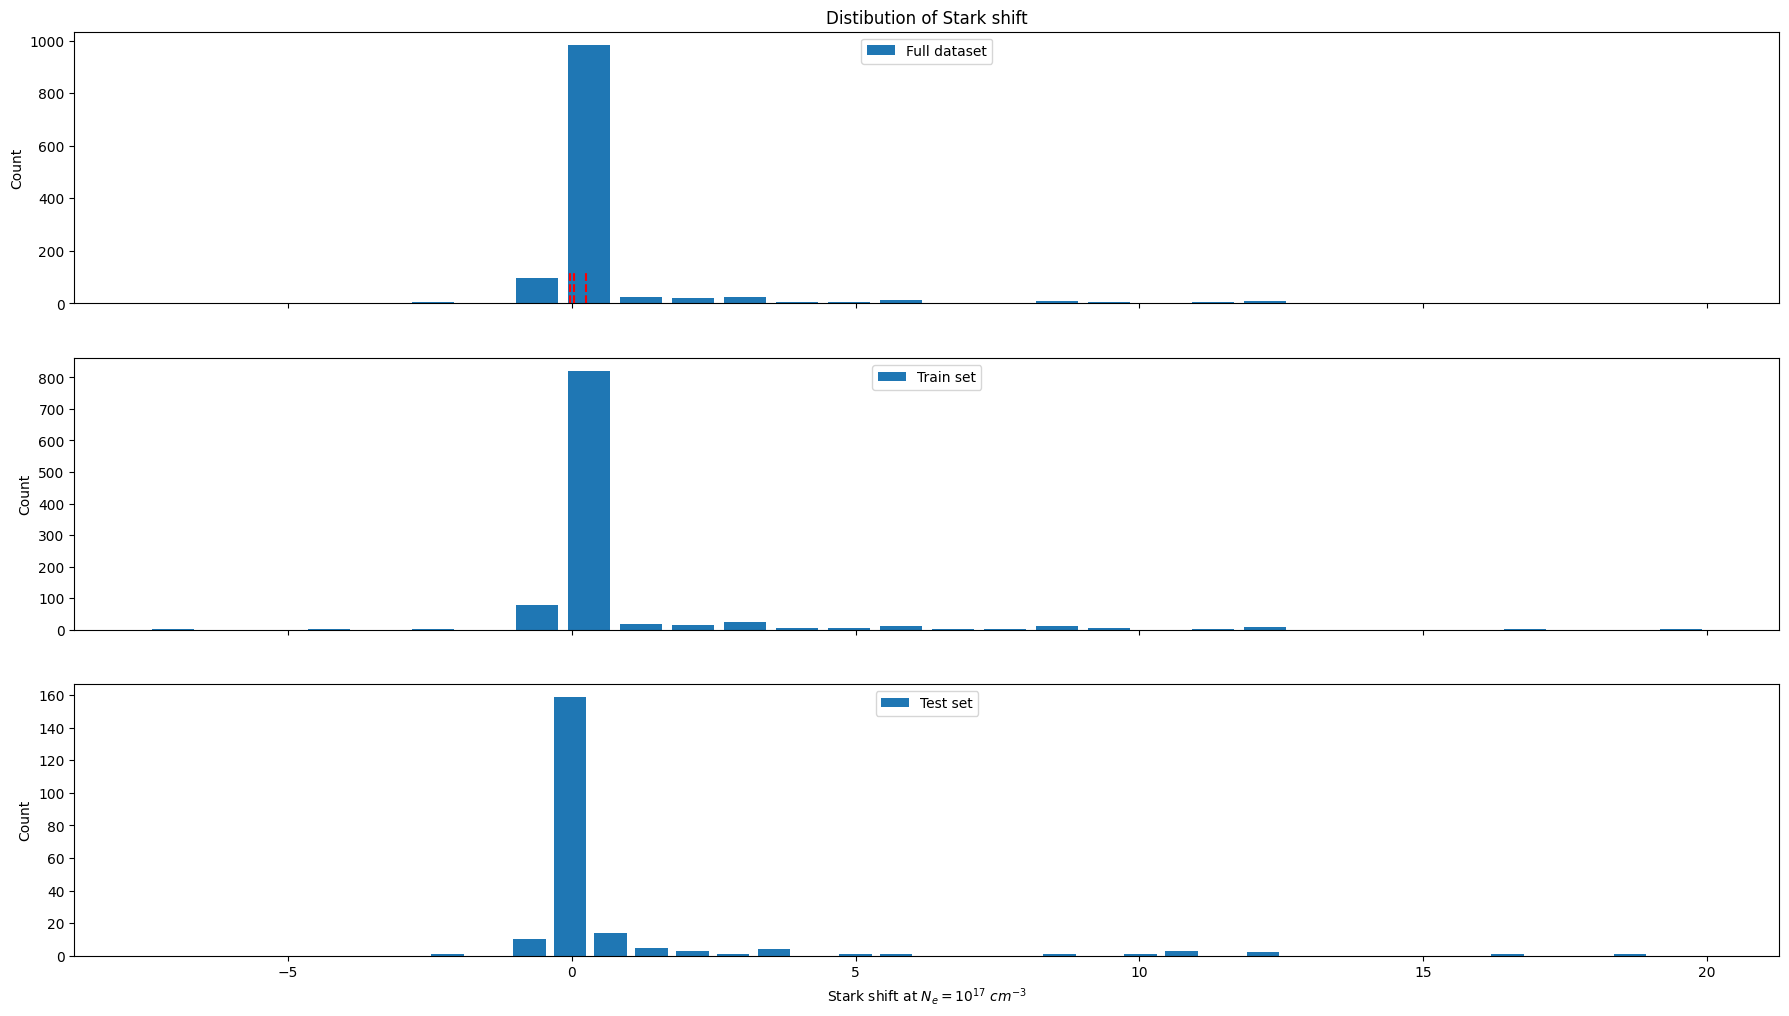

In [23]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

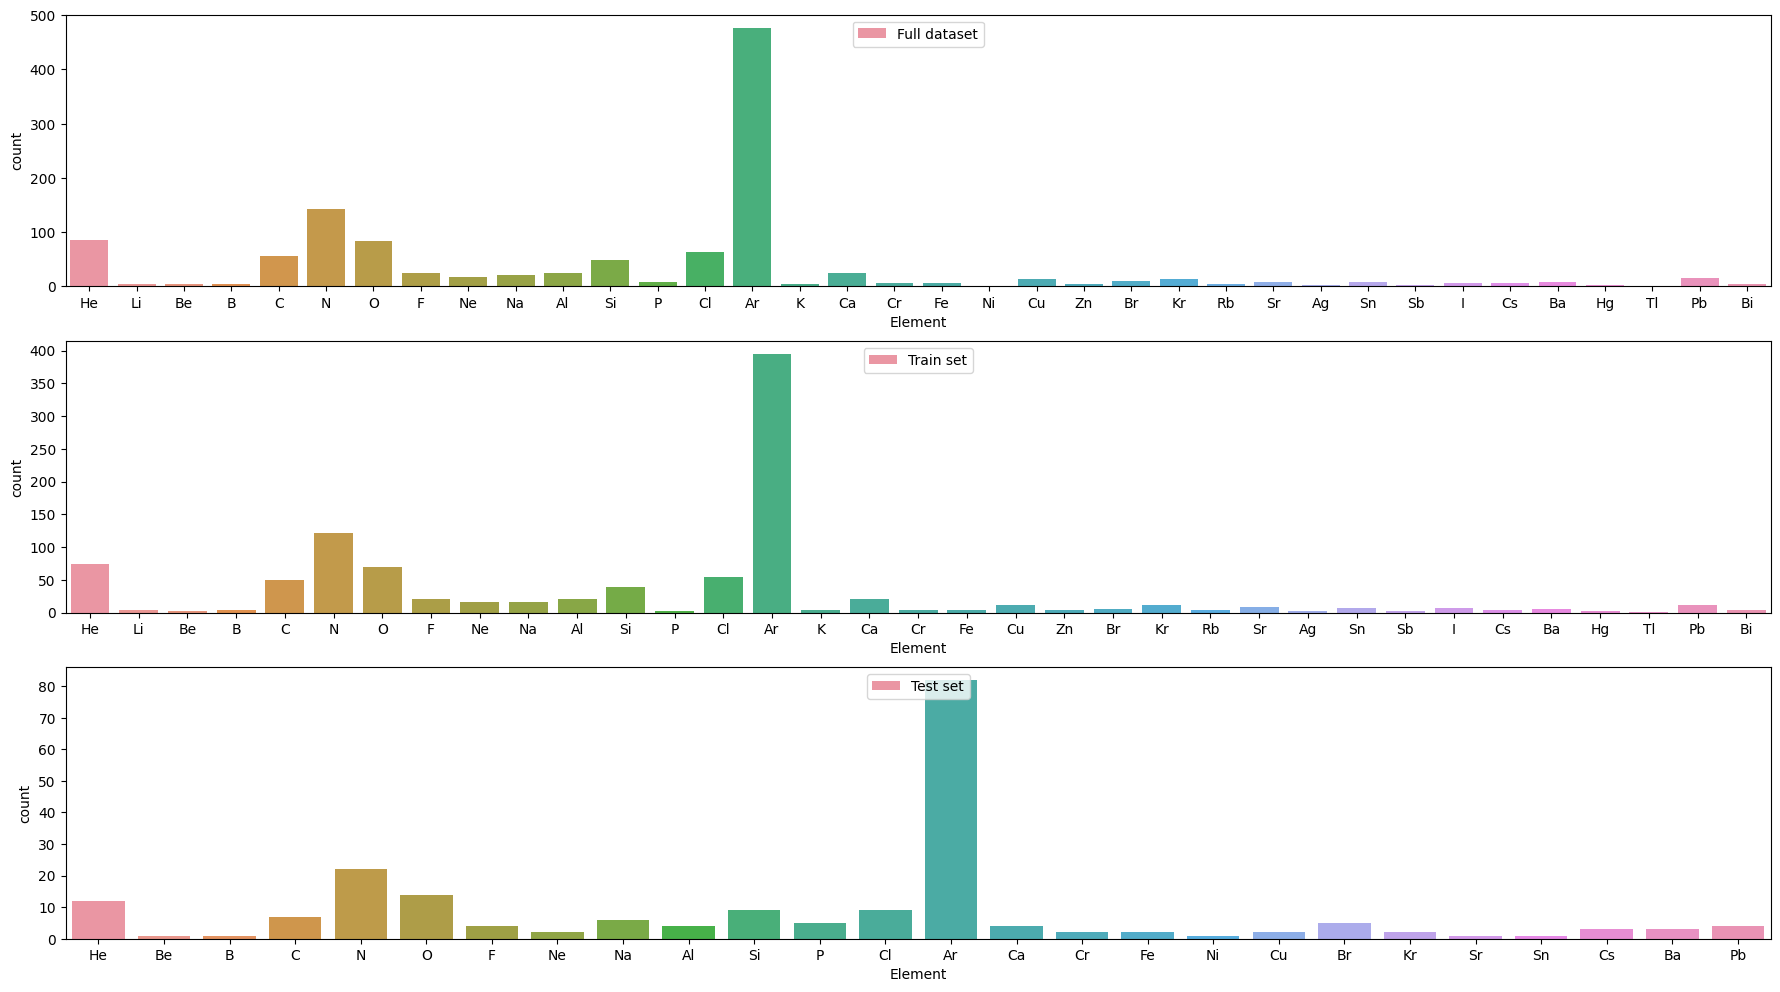

In [24]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

# Both data preprocessing (currently not used anywhere further)

In [25]:
#Selecting items for predicting both parameters simultaneously (currently not used anywhere further)
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

# Dataset modifications  (scaling, augmentation)

In [43]:
augmented_train_set = True#@param {type:"boolean"}
#@markdown Note: augmentation will be applied to width only 

#@markdown ---

#@markdown Select whether you'd like to work with 'width' or 'shift' predictions
parameter  = 'width' #@param ["width", "shift"]

#@markdown ---

#@markdown You can enter any reasonable value less than 180 Angstrom to limit the upper boundary of width walues. (not recommended to change)
width_threshold =  200#@param {type:"number"}

#@markdown ---

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

#@markdown ---

apply_scaler = True#@param {type:"boolean"}

In [44]:
#Assigning proper variables
#Assigning width wariables
if augmented_train_set:
    XW_train, YW_train = data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train_extended
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
else:
    XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
    XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test
XW_train = XW_train.sample(frac = 1, random_state = 777)                        #reshuffle
YW_train = YW_train.sample(frac = 1, random_state = 777)

#Assigning shift variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test
XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

#Assigning proper variables for elements-exclusive test set
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements


#Applying upper boundary to width values
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]


#Applying scaling of width targets
if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)


#Applying 'width' or 'shift selection
if parameter == 'width':
    X_train, Y_train = XW_train, YW_train
    X_test, Y_test = XW_test, YW_test
    X_elem, Y_elem, L_elem = XW_elem, YW_elem, LW_elem
else:
    X_train, Y_train = XS_train, YS_train
    X_test, Y_test = XS_test, YS_test
    X_elem, Y_elem, L_elem = XS_elem, YS_elem, XS_elem


print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 3574
Number of items with shift: 1220
Number of items with both parameters: 924

Size of elements-exclusive test set: 121


In [45]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

# Models optimization

## KNN

In [29]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = X_train, y = Y_train, model_name = model_name, params = KNN_params, n_trials = 500)

'''with open(f'KNN_A+I_Extended_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)'''

[I 2023-05-24 11:04:02,425] A new study created in memory with name: no-name-3e82e34b-b369-44c3-9f12-e928085f1a61


Start hyperparameter optimization


/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

{'n_neighbors': 120, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.3617875318370674}
{'n_neighbors': 66, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.9206364594921255}
{'n_neighbors': 37, 'weights': 'distance', 'leaf_size': 88, 'p': 1.2313115536407109}
{'n_neighbors': 149, 'weights': 'distance', 'leaf_size': 4, 'p': 1.708208149808868}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 29, 'p': 1.6436694284639253}
[I 2023-05-24 11:04:44,581] Trial 4 finished with value: 0.32644599930931206 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 29, 'p': 1.6436694284639253}. Best is trial 4 with value: 0.32644599930931206.
[I 2023-05-24 11:04:44,978] Trial 2 finished with value: 0.33620426778553314 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'leaf_size': 88, 'p': 1.2313115536407109}. Best is trial 4 with value: 0.32644599930931206.
[I 2023-05-24 11:04:45,124] Trial 0 finished with value: 0.7252126263203673 and parameters: {'n_neighbors': 120, 'weights

"with open(f'KNN_A+I_Extended_optimal_parameters', 'w') as fp:\n    json.dump(KNN_res.best_params, fp)"

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


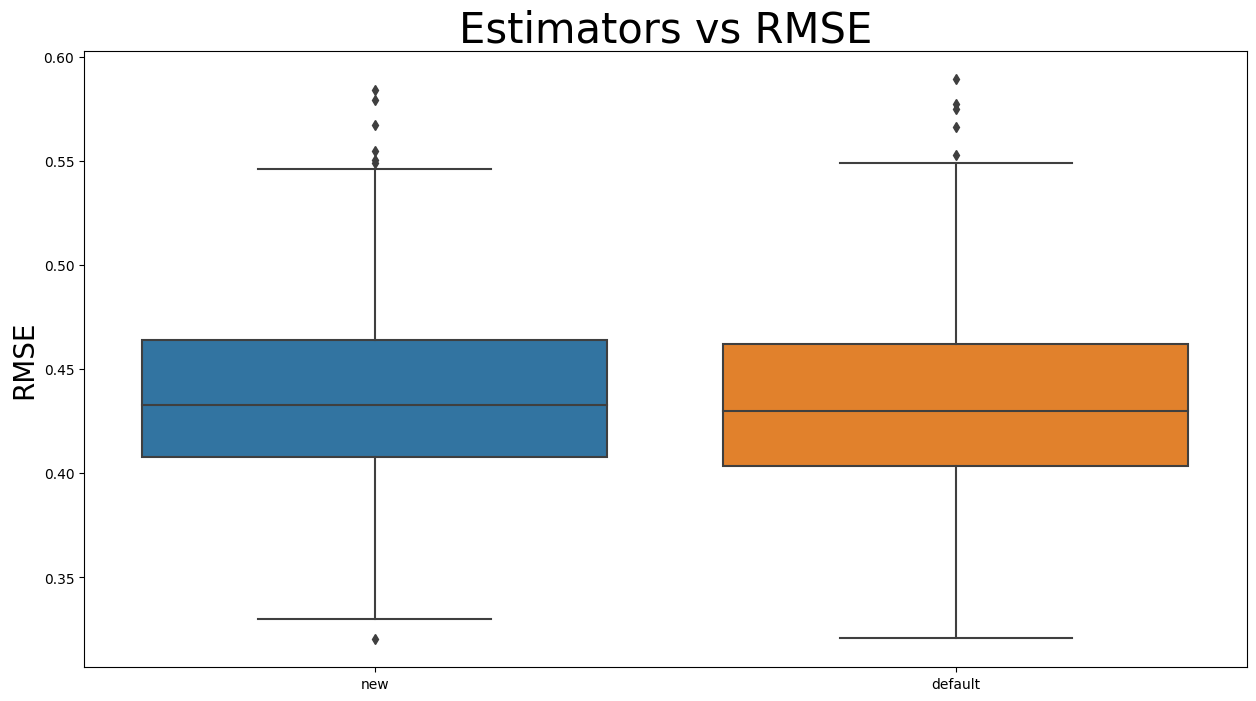

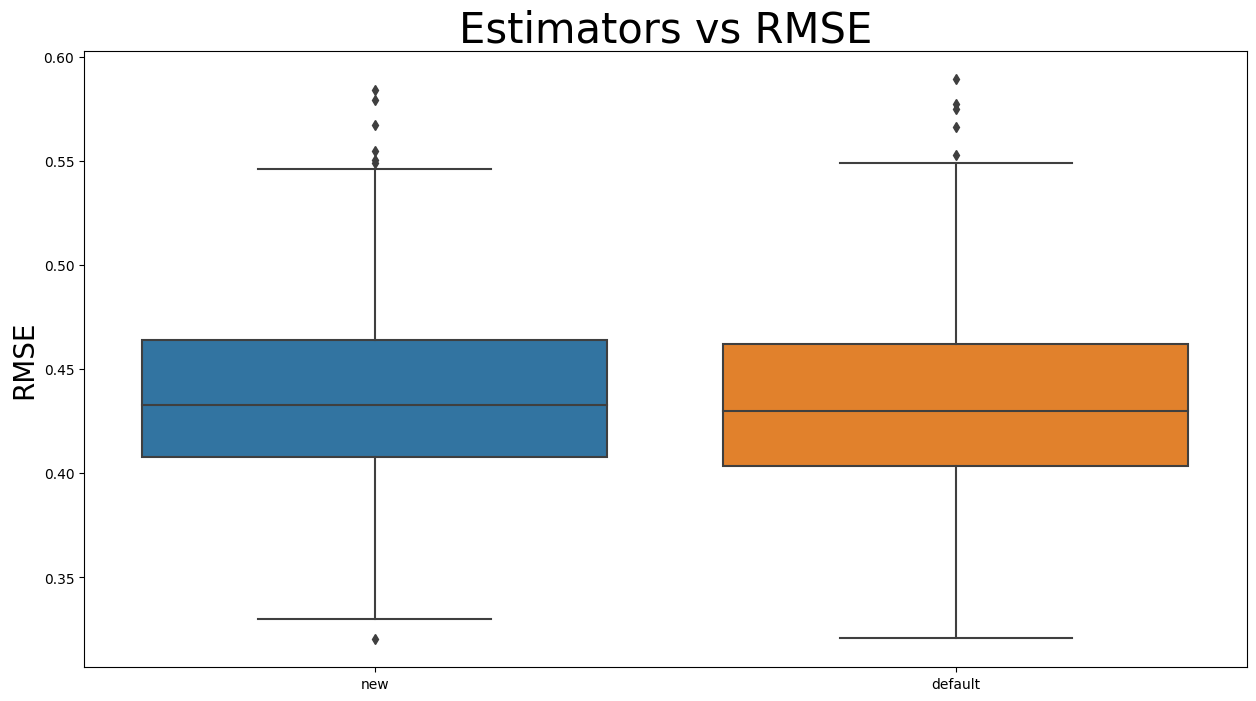

In [30]:
#Compare default KNN vs optimised KNN
KNN_params = KNN_res.best_params

models = {}

models['new'] = KNeighborsRegressor(**KNN_params)
models['default'] = KNeighborsRegressor()

results = train_and_test_regressor(models, X_train, Y_train, X_test, Y_test)

plot_model_comparison(results)

In [ ]:
#Visualise importance of KNN model parameters
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
apply_scaler = True

RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 4
    }

model_name = RandomForest

if apply_scaler:
    RF_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = RF_params, n_trials = 500)
else:
    RF_res = main(X = X_train, y = Y_train, model_name = model_name, params = RF_params, n_trials = 500)

with open(f'RF_A+I_StandardScaler_Extended_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2023-05-04 17:32:36,024] A new study created in memory with name: no-name-bdce96d0-1e89-41c7-a291-74ecd5d2729a


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 9, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'poisson'}
{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 17:32:51,949] Trial 0 finished with value: 0.3224902189112654 and parameters: {'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.3224902189112654.
{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
[I 2023-05-04 17:32:53,017] Trial 2 finished with value: 0.33290239411199213 and parameters: {'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'poisson'}. Best is tr

[I 2023-05-04 18:04:56,702] Trial 25 finished with value: 0.2590373375560683 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'poisson'}. Best is trial 24 with value: 0.23281737987696682.
{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 18:05:11,936] Trial 26 finished with value: 0.2689088354709689 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 24 with value: 0.23281737987696682.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'poisson'}
[I 2023-05-04 18:05:30,767] Trial 27 finished with value: 0.24704551328575527 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is trial 24 with value: 0.23281737987696682.
{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_l

[I 2023-05-04 18:37:12,392] Trial 47 finished with value: 0.23386478745240852 and parameters: {'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 42 with value: 0.21925925364167503.
{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-04 18:37:31,934] Trial 48 finished with value: 0.21477965882557534 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 48 with value: 0.21477965882557534.
{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-04 18:37:34,364] Trial 49 finished with value: 0.21554763560444262 and parameters: {'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 48 with value: 0.21477965882557534.
{'n_estimators': 100, 'max_depth': 27, 'min_samp

[I 2023-05-04 19:10:16,586] Trial 70 finished with value: 0.23111669129428916 and parameters: {'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 54 with value: 0.21454212170078008.
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}
[I 2023-05-04 19:10:29,887] Trial 71 finished with value: 0.23218042994592697 and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 54 with value: 0.21454212170078008.
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-04 19:10:34,620] Trial 72 finished with value: 0.2333001723608493 and parameters: {'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 54 with value: 0.21454212170078008.
{'n_estimators': 100, 'max_depth': 28, 'min_sampl

[I 2023-05-04 19:13:25,589] Trial 91 finished with value: 0.21666197313426835 and parameters: {'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 76 with value: 0.21429731806497085.
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:13:47,751] Trial 94 finished with value: 0.21660388811321366 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 76 with value: 0.21429731806497085.
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'poisson'}
[I 2023-05-04 19:13:48,044] Trial 93 finished with value: 0.2184047164118661 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 76 with value: 0.21429731806497085.
{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_lea

[I 2023-05-04 19:16:28,856] Trial 115 finished with value: 0.2173566721619345 and parameters: {'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 95 with value: 0.21428390460081773.
{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:16:30,858] Trial 116 finished with value: 0.2145623043177222 and parameters: {'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 95 with value: 0.21428390460081773.
{'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:16:49,324] Trial 117 finished with value: 0.21554717954463784 and parameters: {'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 95 with value: 0.21428390460081773.
{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_l

[I 2023-05-04 19:52:02,283] Trial 131 finished with value: 0.24450849520266957 and parameters: {'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 118 with value: 0.21399790187779505.
{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:52:25,299] Trial 141 finished with value: 0.21632519950458323 and parameters: {'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 118 with value: 0.21399790187779505.
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:52:27,807] Trial 132 finished with value: 0.24469416461126964 and parameters: {'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 118 with value: 0.21399790187779505.
{'n_estimators': 100, 'max_depth': 40, 'min_samples_split'

[I 2023-05-04 19:55:17,313] Trial 161 finished with value: 0.21368457957995063 and parameters: {'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:55:29,130] Trial 163 finished with value: 0.31275771725823487 and parameters: {'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:55:30,528] Trial 162 finished with value: 0.21496821293719784 and parameters: {'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 3, 'min_samp

[I 2023-05-04 19:57:35,756] Trial 183 finished with value: 0.21878415456116856 and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:57:39,425] Trial 184 finished with value: 0.2158050886532223 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:57:51,021] Trial 185 finished with value: 0.21464193197895481 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 161 with value: 0.21368457957995063.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_sampl

[I 2023-05-04 19:59:53,217] Trial 207 finished with value: 0.264553883055491 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:59:56,825] Trial 206 finished with value: 0.21622723488811962 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 19:59:58,416] Trial 208 finished with value: 0.21519665332043886 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_sample

[I 2023-05-04 20:02:11,587] Trial 229 finished with value: 0.21359477900181742 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:02:15,178] Trial 230 finished with value: 0.21555210791738175 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:02:19,345] Trial 231 finished with value: 0.2154632785531556 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_sampl

[I 2023-05-04 20:38:37,242] Trial 251 finished with value: 0.21409391937153313 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:38:40,529] Trial 253 finished with value: 0.21694618159004583 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:38:45,764] Trial 254 finished with value: 0.2155975715764311 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3

[I 2023-05-04 20:41:24,555] Trial 275 finished with value: 0.2155313407857197 and parameters: {'max_depth': 39, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:41:31,176] Trial 276 finished with value: 0.21539329434433915 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:41:51,538] Trial 279 finished with value: 0.21541057226183313 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_sampl

[I 2023-05-04 20:44:26,204] Trial 298 finished with value: 0.21482255765613156 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:44:27,082] Trial 299 finished with value: 0.21525330661098274 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:44:29,545] Trial 301 finished with value: 0.3329535798318718 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samp

[I 2023-05-04 20:47:14,991] Trial 321 finished with value: 0.21555908897550352 and parameters: {'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:47:27,083] Trial 324 finished with value: 0.215213143766464 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 20:47:30,321] Trial 323 finished with value: 0.21626051551094813 and parameters: {'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_sample

[I 2023-05-04 21:24:33,483] Trial 345 finished with value: 0.21991237422074333 and parameters: {'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:24:46,655] Trial 346 finished with value: 0.21526234239013467 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:24:49,627] Trial 347 finished with value: 0.21475663255077865 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_sam

[I 2023-05-04 21:27:24,926] Trial 366 finished with value: 0.21648860955643823 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:27:37,788] Trial 368 finished with value: 0.2162202783717253 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:27:38,542] Trial 369 finished with value: 0.21600672340291566 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_sampl

[I 2023-05-04 21:30:30,102] Trial 391 finished with value: 0.2137354772485726 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:30:33,175] Trial 390 finished with value: 0.2177760645353642 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:30:33,703] Trial 389 finished with value: 0.21889566048917536 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_sample

[I 2023-05-04 21:33:16,093] Trial 413 finished with value: 0.2160133956854684 and parameters: {'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
[I 2023-05-04 21:33:22,150] Trial 416 finished with value: 0.21395603856375905 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 21:33:46,272] Trial 418 finished with value: 0.21506290414275173 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 3, 'mi

[I 2023-05-04 22:10:00,044] Trial 436 finished with value: 0.2131754572826114 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-04 22:10:04,401] Trial 437 finished with value: 0.2148952105126874 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}
[I 2023-05-04 22:10:08,995] Trial 439 finished with value: 0.21464366366027657 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3,

[I 2023-05-04 22:12:54,579] Trial 459 finished with value: 0.21486922491249122 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 22:13:04,811] Trial 460 finished with value: 0.21691921667087213 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 22:13:10,562] Trial 462 finished with value: 0.2142528535677546 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_sampl

[I 2023-05-04 22:15:49,807] Trial 481 finished with value: 0.21381214114682984 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}
[I 2023-05-04 22:15:57,819] Trial 483 finished with value: 0.21524608509338194 and parameters: {'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'poisson'}
[I 2023-05-04 22:16:09,513] Trial 484 finished with value: 0.2161639761550071 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 188 with value: 0.21215117700196356.
{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 3, 'min_sampl

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


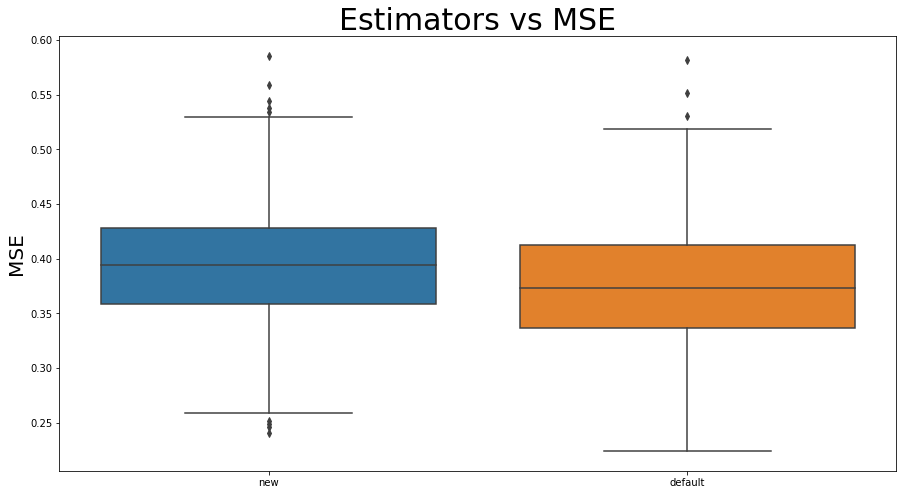

In [ ]:
#Compare default RandomForest vs optimised RandomForest
RF_params = RF_res.best_params

models_RF = {}

models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)
models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_RF)

Fitting 10
Fitting 20
Fitting 30
Fitting 40
Fitting 50
Fitting 60
Fitting 70
Fitting 80
Fitting 90
Fitting 100
Fitting 110
Fitting 120
Fitting 130
Fitting 140
Fitting 150
Fitting 160
Fitting 170
Fitting 180
Fitting 190
Fitting 200
Calculating bootstrap score for 10
Calculating bootstrap score for 20
Calculating bootstrap score for 30
Calculating bootstrap score for 40
Calculating bootstrap score for 50
Calculating bootstrap score for 60
Calculating bootstrap score for 70
Calculating bootstrap score for 80
Calculating bootstrap score for 90
Calculating bootstrap score for 100
Calculating bootstrap score for 110
Calculating bootstrap score for 120
Calculating bootstrap score for 130
Calculating bootstrap score for 140
Calculating bootstrap score for 150
Calculating bootstrap score for 160
Calculating bootstrap score for 170
Calculating bootstrap score for 180
Calculating bootstrap score for 190
Calculating bootstrap score for 200


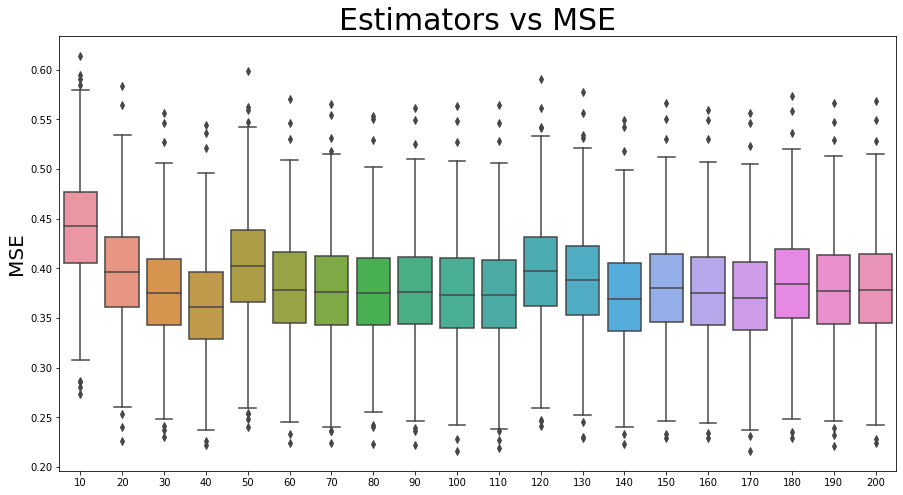

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 201, 10):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

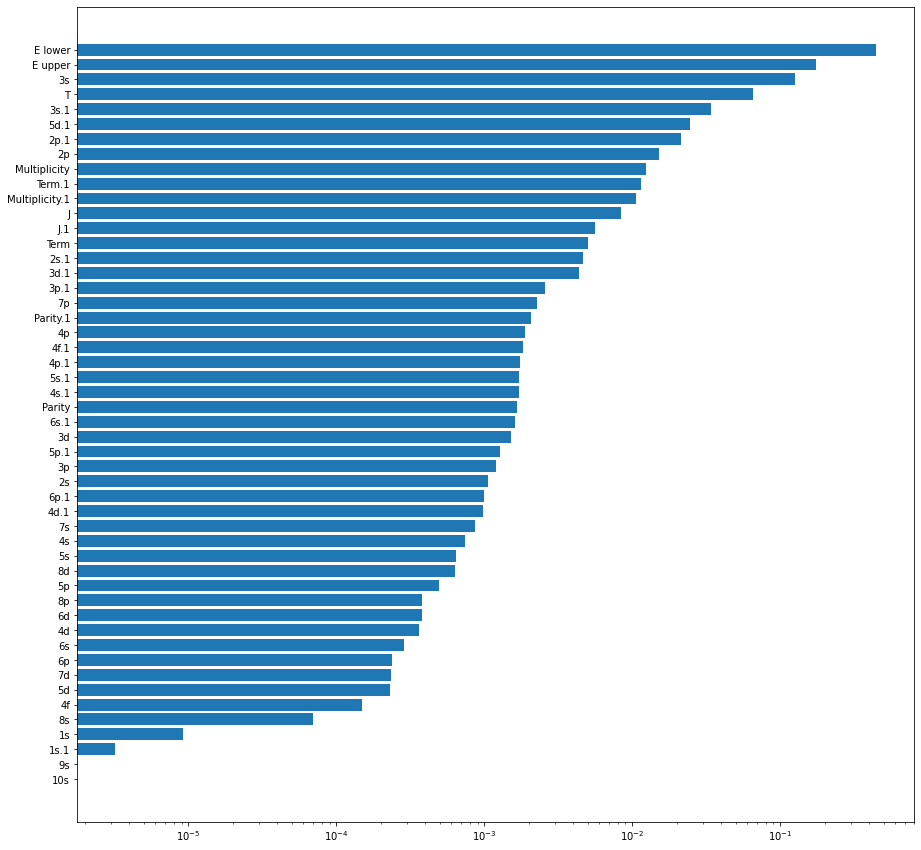

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_RF['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = X_train, y = Y_train, model_name = model_name, params = GB_params, n_trials = 500)

with open(f'GB_A+I_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2023-04-28 20:11:50,664] A new study created in memory with name: no-name-f4708d1d-5e92-452c-a1de-66fc3be3397c


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

{'n_estimators': 100, 'learning_rate': 0.04377877826841362, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.05155140550274367, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 10}
{'n_estimators': 100, 'learning_rate': 0.05562704192878205, 'loss': 'quantile', 'max_depth': 6, 'min_samples_leaf': 9}
{'n_estimators': 100, 'learning_rate': 0.06292698986983825, 'loss': 'absolute_error', 'max_depth': 3, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.04101238874619775, 'loss': 'absolute_error', 'max_depth': 16, 'min_samples_leaf': 9}
{'n_estimators': 100, 'learning_rate': 0.020882679048607463, 'loss': 'quantile', 'max_depth': 20, 'min_samples_leaf': 5}
{'n_estimators': 100, 'learning_rate': 0.07963415137172575, 'loss': 'squared_error', 'max_depth': 41, 'min_samples_leaf': 8}
{'n_estimators': 100, 'learning_rate': 0.021843291800139282, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 4}
{'n_e

[I 2023-04-28 20:21:38,111] Trial 21 finished with value: 2.794970322011332 and parameters: {'learning_rate': 0.07461874869593363, 'loss': 'huber', 'max_depth': 47, 'min_samples_leaf': 7}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.0986132946575935, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 1}
[I 2023-04-28 20:22:48,992] Trial 15 finished with value: 2.7884892859645865 and parameters: {'learning_rate': 0.020456698196514758, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.09479501875615223, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 1}
[I 2023-04-28 20:25:48,361] Trial 28 finished with value: 2.4951141131919523 and parameters: {'learning_rate': 0.09887243337360695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 12 with value: 2.4640216440936236.
{'n_estimators': 100, 'learning_rate': 0.089469308

[I 2023-04-28 20:36:55,229] Trial 7 finished with value: 1.9761392908173694 and parameters: {'learning_rate': 0.04620929502742601, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate': 0.08018693654180871, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 1}
[I 2023-04-28 20:40:36,260] Trial 50 finished with value: 2.3862256495139773 and parameters: {'learning_rate': 0.07926041693497879, 'loss': 'quantile', 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate': 0.09446537883715403, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 1}
[I 2023-04-28 20:41:24,356] Trial 51 finished with value: 2.496757101961907 and parameters: {'learning_rate': 0.08040513246283598, 'loss': 'quantile', 'max_depth': 40, 'min_samples_leaf': 2}. Best is trial 7 with value: 1.9761392908173694.
{'n_estimators': 100, 'learning_rate

[I 2023-04-28 21:10:11,955] Trial 64 finished with value: 2.4541896319953223 and parameters: {'learning_rate': 0.09275172560508387, 'loss': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning_rate': 0.09113606959032176, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 2}
[I 2023-04-28 21:10:14,110] Trial 29 finished with value: 2.1045438682493574 and parameters: {'learning_rate': 0.09730035042395993, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning_rate': 0.09180410299781026, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 2}
[I 2023-04-28 21:10:31,970] Trial 60 finished with value: 2.1321589289609957 and parameters: {'learning_rate': 0.09394053405996264, 'loss': 'absolute_error', 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 22 with value: 1.9569856205961689.
{'n_estimators': 100, 'learning

[I 2023-04-28 21:23:47,196] Trial 91 finished with value: 1.9312993357073651 and parameters: {'learning_rate': 0.0890446652410599, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.08589019376110753, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 3}
[I 2023-04-28 21:23:54,133] Trial 73 finished with value: 1.7466711223556648 and parameters: {'learning_rate': 0.09274144747397524, 'loss': 'huber', 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.08578773524996453, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 3}
[I 2023-04-28 21:24:01,982] Trial 95 finished with value: 2.2526313798729616 and parameters: {'learning_rate': 0.08737792528110522, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 79 with value: 1.6574240022582973.
{'n_estimators': 100, 'learning_rate': 0.085715397413

[I 2023-04-28 21:31:27,436] Trial 119 finished with value: 2.550873531466397 and parameters: {'learning_rate': 0.09985317086521123, 'loss': 'quantile', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.08144597135916873, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:32:39,880] Trial 107 finished with value: 1.6777293848058086 and parameters: {'learning_rate': 0.09671302453812448, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.09855847661202334, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:32:50,419] Trial 110 finished with value: 1.7776505438853978 and parameters: {'learning_rate': 0.0997004101671943, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 88 with value: 1.639135770138838.
{'n_estimators': 100, 'learning_rate': 0.0981853

[I 2023-04-28 21:40:56,041] Trial 132 finished with value: 1.7690051032533678 and parameters: {'learning_rate': 0.09838912868275845, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.08414755953203537, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-28 21:41:04,665] Trial 126 finished with value: 1.6916686289057281 and parameters: {'learning_rate': 0.09823076360908123, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09988821281180865, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-28 21:41:52,893] Trial 125 finished with value: 1.7897816981410877 and parameters: {'learning_rate': 0.08203557253033106, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate':

{'n_estimators': 100, 'learning_rate': 0.09684099557761726, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:52:48,536] Trial 158 finished with value: 2.2718935827758893 and parameters: {'learning_rate': 0.09420482494396433, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09686588426380349, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:53:31,016] Trial 153 finished with value: 1.9381917099935468 and parameters: {'learning_rate': 0.09362230967269927, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09714761293510217, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 21:54:14,913] Trial 146 finished with value: 2.216214302368722 and parameters: {'learning_rate': 0.09982826336448249, 'loss': 'huber', 'max_depth': 14, '

[I 2023-04-28 22:06:10,956] Trial 174 finished with value: 1.6422677524919844 and parameters: {'learning_rate': 0.09591922118357635, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09165707931585061, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}
[I 2023-04-28 22:06:41,497] Trial 177 finished with value: 1.656048626715189 and parameters: {'learning_rate': 0.09206109616088226, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09146926113007423, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}
[I 2023-04-28 22:07:12,490] Trial 178 finished with value: 1.718796077050681 and parameters: {'learning_rate': 0.09164936427093932, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.091417

[I 2023-04-28 22:14:21,950] Trial 197 finished with value: 1.8590345887164073 and parameters: {'learning_rate': 0.08780514813122582, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09504594347362263, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 22:14:44,615] Trial 199 finished with value: 1.8684339493296942 and parameters: {'learning_rate': 0.08745842089730081, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09494572981356353, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 22:14:46,980] Trial 201 finished with value: 1.8965461936907377 and parameters: {'learning_rate': 0.08999619932808595, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09

{'n_estimators': 100, 'learning_rate': 0.05876619606778166, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:24:23,564] Trial 220 finished with value: 1.7536178358895556 and parameters: {'learning_rate': 0.09813205289709923, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.09806138998744494, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:24:34,985] Trial 221 finished with value: 1.7758806859305416 and parameters: {'learning_rate': 0.09808096667547683, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 118 with value: 1.5793063670791383.
{'n_estimators': 100, 'learning_rate': 0.055149808272897, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:25:00,588] Trial 222 finished with value: 1.6670259221209824 and parameters: {'learning_rate': 0.09829314774687531, 'loss': 'huber', 'max_depth': 12, 'm

[I 2023-04-28 22:39:17,859] Trial 238 finished with value: 1.9053296979903895 and parameters: {'learning_rate': 0.07049840346568821, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09597802066719144, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}
[I 2023-04-28 22:40:03,906] Trial 237 finished with value: 1.9083321493504024 and parameters: {'learning_rate': 0.05297281483678706, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09621792924155732, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 22:40:51,606] Trial 245 finished with value: 1.8482791752625594 and parameters: {'learning_rate': 0.0929276941910582, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rat

[I 2023-04-28 22:51:24,320] Trial 265 finished with value: 1.9992745223194532 and parameters: {'learning_rate': 0.09942392861156084, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09085380026264475, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-28 22:51:30,659] Trial 273 finished with value: 2.117171985895074 and parameters: {'learning_rate': 0.06699604967379405, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09067336523765525, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-28 22:51:42,124] Trial 255 finished with value: 2.172933166203669 and parameters: {'learning_rate': 0.04226453008063977, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09021

{'n_estimators': 100, 'learning_rate': 0.09464423589777604, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 2}
[I 2023-04-28 23:08:11,388] Trial 294 finished with value: 1.7204968741544853 and parameters: {'learning_rate': 0.09770743399225289, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08046705409271318, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:10:44,301] Trial 291 finished with value: 1.9698609151363506 and parameters: {'learning_rate': 0.09754862513866805, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09452689688668879, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:11:06,825] Trial 295 finished with value: 1.6543713946451166 and parameters: {'learning_rate': 0.09466028756633414, 'loss': 'huber', 'max_depth': 12, 

[I 2023-04-28 23:24:28,336] Trial 314 finished with value: 1.7875376353785353 and parameters: {'learning_rate': 0.09214946186767049, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.01384399513673324, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-28 23:26:38,065] Trial 316 finished with value: 1.7496470535145434 and parameters: {'learning_rate': 0.09549323598936477, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0836283635253603, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-28 23:27:48,865] Trial 319 finished with value: 1.7414081036335927 and parameters: {'learning_rate': 0.09485976428899227, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.096

{'n_estimators': 100, 'learning_rate': 0.07649674125828697, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:02,226] Trial 312 finished with value: 1.7782935488504372 and parameters: {'learning_rate': 0.0930037705439897, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0631131712074204, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:24,231] Trial 336 finished with value: 1.7383961244966073 and parameters: {'learning_rate': 0.07700962015226284, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07593974917108122, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-28 23:42:30,472] Trial 335 finished with value: 1.799155382295367 and parameters: {'learning_rate': 0.0752355375790309, 'loss': 'huber', 'max_depth': 14, 'min_

[I 2023-04-28 23:54:41,535] Trial 356 finished with value: 1.7418526988597745 and parameters: {'learning_rate': 0.07371016046268164, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.06422905706832066, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}
[I 2023-04-28 23:55:07,716] Trial 358 finished with value: 1.7618760838355065 and parameters: {'learning_rate': 0.08825218463828585, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09833007880185952, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 3}
[I 2023-04-28 23:55:22,841] Trial 363 finished with value: 2.1847468931462437 and parameters: {'learning_rate': 0.0883090124975997, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0982

{'n_estimators': 100, 'learning_rate': 0.08648147636957139, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 9}
[I 2023-04-29 00:08:36,678] Trial 374 finished with value: 2.0119072018408786 and parameters: {'learning_rate': 0.09830264099153263, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09094981458821683, 'loss': 'huber', 'max_depth': 39, 'min_samples_leaf': 2}
[I 2023-04-29 00:08:40,372] Trial 380 finished with value: 1.7654711679138586 and parameters: {'learning_rate': 0.09417449408556088, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09111469882852648, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 2}
[I 2023-04-29 00:08:51,990] Trial 375 finished with value: 2.1025479585950477 and parameters: {'learning_rate': 0.09820215928909513, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 00:19:43,923] Trial 406 finished with value: 1.6927947290454282 and parameters: {'learning_rate': 0.08508345606704515, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08203684099377676, 'loss': 'huber', 'max_depth': 39, 'min_samples_leaf': 7}
[I 2023-04-29 00:20:01,740] Trial 408 finished with value: 1.794588538822684 and parameters: {'learning_rate': 0.09599638910587513, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.05353912893732678, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 00:20:34,577] Trial 402 finished with value: 2.3676186521891824 and parameters: {'learning_rate': 0.08976797627064174, 'loss': 'quantile', 'max_depth': 39, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07

[I 2023-04-29 00:39:25,915] Trial 428 finished with value: 1.7362989790759897 and parameters: {'learning_rate': 0.09661017915062545, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09292382383395653, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 00:39:59,158] Trial 426 finished with value: 1.7348565449362503 and parameters: {'learning_rate': 0.07879098917855579, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09302131391761927, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 00:40:06,402] Trial 433 finished with value: 1.9711380368728182 and parameters: {'learning_rate': 0.09296756448097841, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.062

{'n_estimators': 100, 'learning_rate': 0.06526040977872702, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 3}
[I 2023-04-29 01:00:38,856] Trial 451 finished with value: 2.3643627603957436 and parameters: {'learning_rate': 0.09474909860953094, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0921250539430812, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 3}
[I 2023-04-29 01:01:02,750] Trial 458 finished with value: 2.605560424778135 and parameters: {'learning_rate': 0.0921250539430812, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09750720231148637, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}
[I 2023-04-29 01:01:20,320] Trial 452 finished with value: 2.3022912795972177 and parameters: {'learning_rate': 0.09506617527233943, 'loss': 'huber', 'max

[I 2023-04-29 01:19:43,255] Trial 471 finished with value: 2.0642561691597736 and parameters: {'learning_rate': 0.09807053389795625, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09953096772624077, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 2}
[I 2023-04-29 01:20:10,516] Trial 468 finished with value: 1.88565989162237 and parameters: {'learning_rate': 0.05676885917965157, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.05165651519171295, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 2}
[I 2023-04-29 01:20:45,386] Trial 481 finished with value: 2.3984156035363315 and parameters: {'learning_rate': 0.05165651519171295, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learni

{'n_estimators': 100, 'learning_rate': 0.08169366794214389, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:38:35,735] Trial 498 finished with value: 2.8265677461838647 and parameters: {'learning_rate': 0.0922120817426269, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 8}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.0825947766506571, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:39:06,317] Trial 494 finished with value: 1.910812853653009 and parameters: {'learning_rate': 0.07151649030077599, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09058591602218194, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 01:42:25,865] Trial 480 finished with value: 1.730961993724673 and parameters: {'learning_rate': 0.09953096772624077, 'loss': 'huber', 'max_depth': 30, 'min

[I 2023-04-29 02:04:54,398] Trial 517 finished with value: 1.9536259895273438 and parameters: {'learning_rate': 0.043188464360981206, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.08878164245000408, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 3}
[I 2023-04-29 02:04:57,768] Trial 521 finished with value: 1.9041523485010408 and parameters: {'learning_rate': 0.09382982238032475, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.036742866804302235, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:05:10,716] Trial 512 finished with value: 1.8564684010163561 and parameters: {'learning_rate': 0.09590065681008715, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.

[I 2023-04-29 02:15:38,734] Trial 537 finished with value: 1.7889600975646893 and parameters: {'learning_rate': 0.07865975173960998, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09379766750095198, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 02:16:03,568] Trial 535 finished with value: 2.555641327996152 and parameters: {'learning_rate': 0.020147856801692836, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09354380763224132, 'loss': 'absolute_error', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 02:16:27,577] Trial 536 finished with value: 2.2626208827596184 and parameters: {'learning_rate': 0.02933110390360467, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_ra

{'n_estimators': 100, 'learning_rate': 0.043065190153347976, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:25,484] Trial 556 finished with value: 1.8225353261610742 and parameters: {'learning_rate': 0.09089497376749062, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.07471517010760481, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:28,853] Trial 555 finished with value: 1.6911570406214966 and parameters: {'learning_rate': 0.06827409381751622, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09139645606494544, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 02:29:58,328] Trial 563 finished with value: 1.9614879116918171 and parameters: {'learning_rate': 0.06071215613060228, 'loss': 'huber', 'max_depth': 11,

[I 2023-04-29 02:40:38,447] Trial 577 finished with value: 1.9275178246929 and parameters: {'learning_rate': 0.0918061211798548, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09507643094050595, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:41:43,986] Trial 571 finished with value: 1.7773850366921244 and parameters: {'learning_rate': 0.09139645606494544, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.09534135202882382, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 02:42:07,762] Trial 586 finished with value: 2.7373108917970352 and parameters: {'learning_rate': 0.07852632846759428, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 7}. Best is trial 228 with value: 1.5309342192351207.
{'n_estimators': 100, 'learning_rate': 0.095385

{'n_estimators': 100, 'learning_rate': 0.0970629454464202, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:53:35,475] Trial 597 finished with value: 1.5912342141836517 and parameters: {'learning_rate': 0.09532090456011402, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09759905185464207, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:53:59,001] Trial 569 finished with value: 2.266719065152863 and parameters: {'learning_rate': 0.043065190153347976, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.059238725183409315, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 02:54:11,052] Trial 598 finished with value: 1.748688855372297 and parameters: {'learning_rate': 0.09676357415788109, 'loss': 'huber', 'max_depth': 12, '

{'n_estimators': 100, 'learning_rate': 0.03450729162822606, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 03:13:23,255] Trial 633 finished with value: 1.8982793686478714 and parameters: {'learning_rate': 0.09991221200979881, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08330940012000307, 'loss': 'huber', 'max_depth': 16, 'min_samples_leaf': 2}
[I 2023-04-29 03:14:09,379] Trial 634 finished with value: 1.8079094909921412 and parameters: {'learning_rate': 0.0948350696377394, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08420566028599524, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 03:15:31,450] Trial 626 finished with value: 1.8137510187937433 and parameters: {'learning_rate': 0.09614983593507051, 'loss': 'huber', 'max_depth': 15, '

[I 2023-04-29 03:29:33,371] Trial 645 finished with value: 2.258684205055475 and parameters: {'learning_rate': 0.03477004433003303, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08986379129074544, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:30:32,950] Trial 655 finished with value: 2.019138189707023 and parameters: {'learning_rate': 0.09473894105537009, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.07711588505334274, 'loss': 'quantile', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 03:30:40,714] Trial 650 finished with value: 2.4399242002978316 and parameters: {'learning_rate': 0.029037819095308972, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.

{'n_estimators': 100, 'learning_rate': 0.09299140127601893, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:40:55,651] Trial 665 finished with value: 1.7229263534750747 and parameters: {'learning_rate': 0.0586871864981349, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.06356124645216314, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:42:20,061] Trial 674 finished with value: 2.0128546785342527 and parameters: {'learning_rate': 0.05836677848801184, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.04220563585945868, 'loss': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 2}
[I 2023-04-29 03:42:40,162] Trial 683 finished with value: 2.34676250385393 and parameters: {'learning_rate': 0.04220563585945868, 'loss': 'squared_error', 'max_de

[I 2023-04-29 03:58:45,942] Trial 695 finished with value: 2.023214041471992 and parameters: {'learning_rate': 0.039027453251102885, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09846070148095573, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:58:47,796] Trial 699 finished with value: 1.7012705162229511 and parameters: {'learning_rate': 0.09600976628817187, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09865852890760339, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 03:58:55,622] Trial 668 finished with value: 2.1505101485129408 and parameters: {'learning_rate': 0.0423297236100194, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.098

{'n_estimators': 100, 'learning_rate': 0.0911422913478509, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}
[I 2023-04-29 04:19:21,995] Trial 698 finished with value: 1.7810619150248688 and parameters: {'learning_rate': 0.07056649473490188, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08232250316806802, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}
[I 2023-04-29 04:20:03,725] Trial 722 finished with value: 1.8261216564575549 and parameters: {'learning_rate': 0.09271442055008387, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09046586865631008, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 3}
[I 2023-04-29 04:20:12,889] Trial 720 finished with value: 1.820700320467895 and parameters: {'learning_rate': 0.07306273839879722, 'loss': 'huber', 'max_depth': 9, 'min

[I 2023-04-29 04:34:12,805] Trial 740 finished with value: 1.7212580305695764 and parameters: {'learning_rate': 0.09491511786163415, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09694852216147429, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}
[I 2023-04-29 04:34:24,261] Trial 733 finished with value: 1.991767114056465 and parameters: {'learning_rate': 0.04961979522172126, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09496166874329885, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 04:35:25,039] Trial 741 finished with value: 1.7958659214553339 and parameters: {'learning_rate': 0.09430145071732274, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.096

[I 2023-04-29 04:43:58,776] Trial 754 finished with value: 2.1989703841002393 and parameters: {'learning_rate': 0.04627185176844302, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09267806866280302, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 04:44:09,433] Trial 763 finished with value: 2.2704659861714336 and parameters: {'learning_rate': 0.097353522975188, 'loss': 'absolute_error', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.05353866421954849, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}
[I 2023-04-29 04:44:25,018] Trial 761 finished with value: 2.3547101456435877 and parameters: {'learning_rate': 0.0881156868302731, 'loss': 'absolute_error', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learn

[I 2023-04-29 05:00:08,055] Trial 785 finished with value: 1.7954786318485578 and parameters: {'learning_rate': 0.08750941486638357, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08974754956932596, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 6}
[I 2023-04-29 05:00:16,647] Trial 786 finished with value: 3.077583935945713 and parameters: {'learning_rate': 0.09029417283250701, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08968611394702639, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}
[I 2023-04-29 05:00:21,762] Trial 783 finished with value: 2.1264665338334434 and parameters: {'learning_rate': 0.032649364888640994, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0

{'n_estimators': 100, 'learning_rate': 0.01914574989082439, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:10:51,946] Trial 812 finished with value: 2.7426972080089027 and parameters: {'learning_rate': 0.044209693854324536, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0797062478979386, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:11:01,844] Trial 807 finished with value: 2.908946060243858 and parameters: {'learning_rate': 0.07414332907280126, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.016691407499315247, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 05:15:51,366] Trial 779 finished with value: 2.011139419914759 and parameters: {'learning_rate': 0.0520513880528061, 'loss': 'huber', 'max_depth'

[I 2023-04-29 05:30:29,331] Trial 801 finished with value: 1.7981049279417707 and parameters: {'learning_rate': 0.0848231618859318, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0957710720519749, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}
[I 2023-04-29 05:31:33,860] Trial 824 finished with value: 1.8622382415976593 and parameters: {'learning_rate': 0.041888008901673, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09572086369044563, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 1}
[I 2023-04-29 05:31:48,355] Trial 834 finished with value: 2.3848994227148874 and parameters: {'learning_rate': 0.09558000679852695, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.08121828

{'n_estimators': 100, 'learning_rate': 0.018497566244872837, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}
[I 2023-04-29 05:43:18,696] Trial 847 finished with value: 1.7538973393725203 and parameters: {'learning_rate': 0.0677207943320316, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.03703736763548382, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 05:44:42,586] Trial 833 finished with value: 2.0506256833251326 and parameters: {'learning_rate': 0.09525668757145322, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09846048106570393, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 05:47:56,855] Trial 850 finished with value: 1.903588836043804 and parameters: {'learning_rate': 0.09991936957049255, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 05:55:51,521] Trial 881 finished with value: 2.3875519007906645 and parameters: {'learning_rate': 0.056987059470425414, 'loss': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
[I 2023-04-29 05:55:51,871] Trial 864 finished with value: 2.2521283053208747 and parameters: {'learning_rate': 0.04102590537857439, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0967222606020706, 'loss': 'quantile', 'max_depth': 11, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.09682635930802491, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 05:57:05,051] Trial 866 finished with value: 1.7151007156388733 and parameters: {'learning_rate': 0.07066490659824086, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_

[I 2023-04-29 06:09:38,934] Trial 900 finished with value: 2.0405934410669255 and parameters: {'learning_rate': 0.09034471446926727, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.05522216991592843, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 1}
[I 2023-04-29 06:09:56,011] Trial 896 finished with value: 1.8003860112889427 and parameters: {'learning_rate': 0.09009548134844753, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0868034466299838, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 6}
[I 2023-04-29 06:10:50,476] Trial 895 finished with value: 1.7891081789098144 and parameters: {'learning_rate': 0.05908661653067227, 'loss': 'huber', 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0385

{'n_estimators': 100, 'learning_rate': 0.09994548294753139, 'loss': 'absolute_error', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 06:23:35,529] Trial 919 finished with value: 2.3429640003216554 and parameters: {'learning_rate': 0.0793813481559977, 'loss': 'absolute_error', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09829901616989309, 'loss': 'huber', 'max_depth': 12, 'min_samples_leaf': 2}
[I 2023-04-29 06:23:39,959] Trial 916 finished with value: 1.72061271007768 and parameters: {'learning_rate': 0.07613714677156785, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09842370816498414, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 06:24:16,457] Trial 920 finished with value: 2.1418291380040255 and parameters: {'learning_rate': 0.09439021792104614, 'loss': 'absolute_e

{'n_estimators': 100, 'learning_rate': 0.09811513941702697, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}
[I 2023-04-29 06:36:03,644] Trial 929 finished with value: 1.7699644683298839 and parameters: {'learning_rate': 0.09842370816498414, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09786222955482503, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 06:39:10,582] Trial 943 finished with value: 1.6651533269533494 and parameters: {'learning_rate': 0.09788331031133918, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09609228403760287, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 2}
[I 2023-04-29 06:40:45,601] Trial 946 finished with value: 1.836441369413901 and parameters: {'learning_rate': 0.09832753537806062, 'loss': 'huber', 'max_depth': 13, '

[I 2023-04-29 06:54:01,521] Trial 963 finished with value: 1.5699633471302152 and parameters: {'learning_rate': 0.09448031528977677, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0938636788149614, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 06:55:28,620] Trial 964 finished with value: 1.6237564516937701 and parameters: {'learning_rate': 0.09390334989175417, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09999533197238239, 'loss': 'huber', 'max_depth': 10, 'min_samples_leaf': 2}
[I 2023-04-29 06:55:58,034] Trial 965 finished with value: 1.7980646581372983 and parameters: {'learning_rate': 0.0936436050160744, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.0997

{'n_estimators': 100, 'learning_rate': 0.06999385628188023, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:04:32,104] Trial 984 finished with value: 2.033494215668084 and parameters: {'learning_rate': 0.0966992041375475, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.06206962659930435, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:07:00,320] Trial 985 finished with value: 1.8227591889294428 and parameters: {'learning_rate': 0.09669880857198068, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 595 with value: 1.5281173073656917.
{'n_estimators': 100, 'learning_rate': 0.09208226833005898, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 3}
[I 2023-04-29 07:07:41,009] Trial 988 finished with value: 3.1902555886959933 and parameters: {'learning_rate': 0.012336333901925373, 'loss': 'huber', 'max_depth': 11, 'm

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


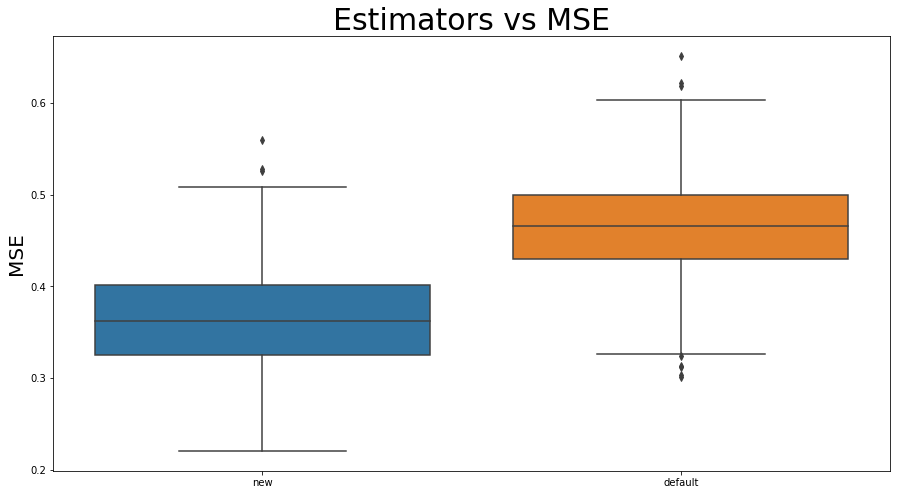

In [ ]:
#Compare default GradientBoosting vs optimised GradientBoosting
GB_params = GB_res.best_params

models_GB = {}

models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)
models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_GB)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(GB_res)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.



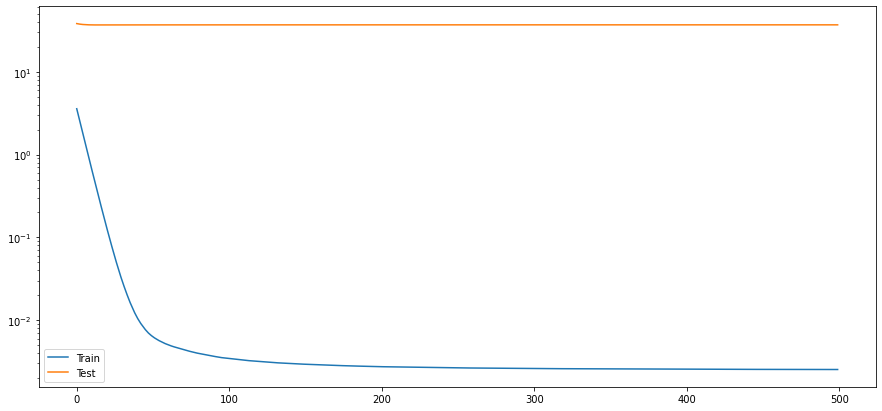

In [ ]:
#Visualising selection of n_estimators and potential overfitting
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

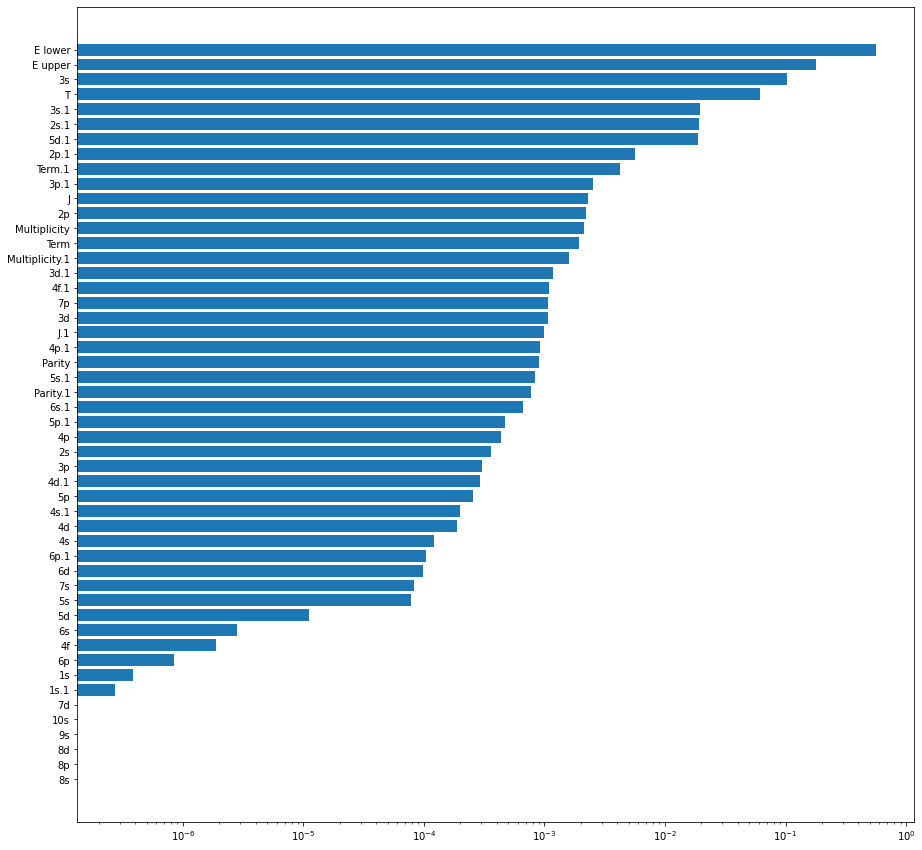

In [ ]:
#Visualising feature importances for the optimal RF model
feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 20],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 6
    }

model_name = XGBoost

if apply_scaler:
    XGB_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = XGB_params, n_trials = 500)
else:
    XGB_res = main(X = X_train, y = Y_train, model_name = model_name, params = XGB_params, n_trials = 500)

with open(f'XGB_A+I_StandardScaler_Extended_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2023-05-03 12:09:53,268] A new study created in memory with name: no-name-cc3c96e8-7215-4af6-9981-36d9166259ff


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 500, 'max_depth': 19, 'learning_rate': 0.23940282079824096, 'min_child_weight': 7, 'reg_alpha': 0.04011089552052717, 'reg_lambda': 0.03286477737886724}
{'n_estimators': 500, 'max_depth': 19, 'learning_rate': 0.11431247863952741, 'min_child_weight': 12, 'reg_alpha': 0.00414213031904055, 'reg_lambda': 0.007519730587850506}
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.27741971900861556, 'min_child_weight': 3, 'reg_alpha': 0.0003992343205459336, 'reg_lambda': 0.020004550267437124}
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.16459851911537102, 'min_child_weight': 8, 'reg_alpha': 2.5352471616589533e-06, 'reg_lambda': 0.005037314218615037}
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.09400744444412976, 'min_child_weight': 11, 'reg_alpha': 0.041033993624677925, 'reg_lambda': 6.170579217775894e-07}
{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.10523832014119905, 'min_child_weight': 8, 'reg_alpha': 0.0007453575853029011, 'reg_lam

[I 2023-05-03 12:16:24,552] Trial 15 finished with value: 0.2554540656935581 and parameters: {'max_depth': 15, 'learning_rate': 0.012236329701720755, 'min_child_weight': 13, 'reg_alpha': 3.5785512838059564e-06, 'reg_lambda': 5.136667708392515}. Best is trial 9 with value: 0.19454880593218085.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.17206767721759242, 'min_child_weight': 10, 'reg_alpha': 3.1104021220804965e-05, 'reg_lambda': 4.445795302754942e-06}
[I 2023-05-03 12:16:44,317] Trial 18 finished with value: 0.2062616424363261 and parameters: {'max_depth': 13, 'learning_rate': 0.06062391504223829, 'min_child_weight': 15, 'reg_alpha': 1.599878965849605e-05, 'reg_lambda': 2.9393386349474975e-06}. Best is trial 9 with value: 0.19454880593218085.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.18985609319796326, 'min_child_weight': 1, 'reg_alpha': 1.037288862096034e-08, 'reg_lambda': 1.4032051999399526e-05}
[I 2023-05-03 12:17:13,485] Trial 16 finished with value: 0.

[I 2023-05-03 12:20:51,514] Trial 29 finished with value: 0.19594459907175282 and parameters: {'max_depth': 11, 'learning_rate': 0.0894726464993047, 'min_child_weight': 9, 'reg_alpha': 9.582453263588175e-05, 'reg_lambda': 4.532901957578218e-07}. Best is trial 21 with value: 0.19371062326092028.
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.12835864542387496, 'min_child_weight': 12, 'reg_alpha': 0.0008421196691676207, 'reg_lambda': 1.1944277001087307e-06}
[I 2023-05-03 12:21:22,888] Trial 30 finished with value: 0.19713668400328294 and parameters: {'max_depth': 11, 'learning_rate': 0.0755189461338857, 'min_child_weight': 9, 'reg_alpha': 0.0008021379255843071, 'reg_lambda': 5.776673039096554e-07}. Best is trial 21 with value: 0.19371062326092028.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.12855247484917048, 'min_child_weight': 13, 'reg_alpha': 0.003431449973712457, 'reg_lambda': 7.34536182104277e-08}
[I 2023-05-03 12:21:27,709] Trial 35 finished with value: 0.19

[I 2023-05-03 12:28:30,371] Trial 52 finished with value: 0.19928431274420738 and parameters: {'max_depth': 9, 'learning_rate': 0.2671573353090023, 'min_child_weight': 8, 'reg_alpha': 0.013296866713883705, 'reg_lambda': 2.0747449666287903e-08}. Best is trial 21 with value: 0.19371062326092028.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2373025866086088, 'min_child_weight': 10, 'reg_alpha': 7.030573151748941e-07, 'reg_lambda': 1.4695190051006832e-07}
[I 2023-05-03 12:28:44,666] Trial 47 finished with value: 0.20615383394725625 and parameters: {'max_depth': 20, 'learning_rate': 0.20218402924567846, 'min_child_weight': 10, 'reg_alpha': 0.00036767913117175335, 'reg_lambda': 4.149683579990232e-08}. Best is trial 21 with value: 0.19371062326092028.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1802668350557854, 'min_child_weight': 8, 'reg_alpha': 0.08600546092680698, 'reg_lambda': 0.002204232561645768}
[I 2023-05-03 12:28:45,784] Trial 53 finished with value: 0.20363

[I 2023-05-03 12:33:17,871] Trial 68 finished with value: 0.1950841214665866 and parameters: {'max_depth': 7, 'learning_rate': 0.16811157468070803, 'min_child_weight': 3, 'reg_alpha': 2.7793782390669795e-05, 'reg_lambda': 1.0079176680936072e-05}. Best is trial 60 with value: 0.19316669965297967.
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.18045973826772957, 'min_child_weight': 7, 'reg_alpha': 5.006752260949551e-05, 'reg_lambda': 2.822883653055443e-07}
[I 2023-05-03 12:33:28,462] Trial 69 finished with value: 0.1948421116846572 and parameters: {'max_depth': 7, 'learning_rate': 0.1738501939592221, 'min_child_weight': 4, 'reg_alpha': 5.2799997096799e-05, 'reg_lambda': 2.0766035845162437e-05}. Best is trial 60 with value: 0.19316669965297967.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.14374709900335764, 'min_child_weight': 3, 'reg_alpha': 6.721259862837143e-05, 'reg_lambda': 3.3449476226317625e-07}
[I 2023-05-03 12:33:33,151] Trial 70 finished with value: 0.1956

[I 2023-05-03 12:37:46,241] Trial 82 finished with value: 0.19849884663761652 and parameters: {'max_depth': 13, 'learning_rate': 0.11720660728749727, 'min_child_weight': 9, 'reg_alpha': 1.7804681963396532e-06, 'reg_lambda': 8.484115021450261e-07}. Best is trial 60 with value: 0.19316669965297967.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.16109532466868984, 'min_child_weight': 5, 'reg_alpha': 4.0481143069548296e-07, 'reg_lambda': 1.2540505601831602e-07}
[I 2023-05-03 12:39:16,967] Trial 87 finished with value: 0.19618355913636082 and parameters: {'max_depth': 10, 'learning_rate': 0.159625851461492, 'min_child_weight': 5, 'reg_alpha': 2.4004498147399633e-06, 'reg_lambda': 9.646849039518107e-08}. Best is trial 60 with value: 0.19316669965297967.
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.15927782537781415, 'min_child_weight': 12, 'reg_alpha': 4.0239244130336433e-07, 'reg_lambda': 9.791006898253404e-07}
[I 2023-05-03 12:39:17,587] Trial 86 finished with value

[I 2023-05-03 12:43:36,034] Trial 101 finished with value: 0.2038726523565506 and parameters: {'max_depth': 12, 'learning_rate': 0.13120194591347242, 'min_child_weight': 4, 'reg_alpha': 1.708707310857132e-05, 'reg_lambda': 7.101944150626056e-08}. Best is trial 98 with value: 0.192176285099888.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.11681152398532188, 'min_child_weight': 10, 'reg_alpha': 3.0371105157832086e-05, 'reg_lambda': 4.822341372870981e-07}
[I 2023-05-03 12:43:38,591] Trial 103 finished with value: 0.2031017872743719 and parameters: {'max_depth': 12, 'learning_rate': 0.13081628300652362, 'min_child_weight': 4, 'reg_alpha': 1.6406198598137764e-05, 'reg_lambda': 2.0609948735417424e-07}. Best is trial 98 with value: 0.192176285099888.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1497914407628093, 'min_child_weight': 2, 'reg_alpha': 7.333896061180723e-06, 'reg_lambda': 1.2909607351954307e-07}
[I 2023-05-03 12:44:50,707] Trial 107 finished with value: 0.2

[I 2023-05-03 12:48:14,895] Trial 119 finished with value: 0.19758726739757768 and parameters: {'max_depth': 11, 'learning_rate': 0.17049305400960646, 'min_child_weight': 8, 'reg_alpha': 2.4811634953392476e-06, 'reg_lambda': 1.8392421295799634e-06}. Best is trial 98 with value: 0.192176285099888.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.14450679327439947, 'min_child_weight': 2, 'reg_alpha': 2.6522792027415883e-05, 'reg_lambda': 2.95930623685282e-07}
[I 2023-05-03 12:48:15,624] Trial 120 finished with value: 0.19429154283498878 and parameters: {'max_depth': 11, 'learning_rate': 0.1688220045529819, 'min_child_weight': 11, 'reg_alpha': 2.5771066510926463e-06, 'reg_lambda': 3.0681715038226806e-07}. Best is trial 98 with value: 0.192176285099888.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.15224686281823369, 'min_child_weight': 1, 'reg_alpha': 0.00026301367566285047, 'reg_lambda': 3.0908529544094884e-07}
[I 2023-05-03 12:48:34,496] Trial 121 finished with value:

[I 2023-05-03 12:52:49,302] Trial 135 finished with value: 0.2064633263231493 and parameters: {'max_depth': 10, 'learning_rate': 0.1842114861143359, 'min_child_weight': 2, 'reg_alpha': 5.528269951681349e-06, 'reg_lambda': 6.314284203762189e-07}. Best is trial 125 with value: 0.19203147781167215.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.16427765072527947, 'min_child_weight': 12, 'reg_alpha': 0.0001456860296424815, 'reg_lambda': 9.042761783439532e-08}
[I 2023-05-03 12:52:55,843] Trial 138 finished with value: 0.19430691040570694 and parameters: {'max_depth': 10, 'learning_rate': 0.16687426038928077, 'min_child_weight': 12, 'reg_alpha': 0.00011185221119694149, 'reg_lambda': 1.8940579133775082e-07}. Best is trial 125 with value: 0.19203147781167215.
{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1974514223019031, 'min_child_weight': 11, 'reg_alpha': 0.00013772429493044103, 'reg_lambda': 2.2403684684276311e-07}
[I 2023-05-03 12:53:09,499] Trial 137 finished with va

[I 2023-05-03 12:56:43,672] Trial 153 finished with value: 0.19441387748727337 and parameters: {'max_depth': 8, 'learning_rate': 0.17400312534485238, 'min_child_weight': 7, 'reg_alpha': 3.7224368307637265e-05, 'reg_lambda': 8.072417955055645e-05}. Best is trial 125 with value: 0.19203147781167215.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1733725423154205, 'min_child_weight': 7, 'reg_alpha': 2.4714155560969604e-05, 'reg_lambda': 2.720202529795959e-08}
[I 2023-05-03 12:57:03,724] Trial 156 finished with value: 0.197354332570035 and parameters: {'max_depth': 7, 'learning_rate': 0.21239454443084466, 'min_child_weight': 13, 'reg_alpha': 2.5350333266279465e-05, 'reg_lambda': 2.239846212510751e-08}. Best is trial 125 with value: 0.19203147781167215.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.17469080962474984, 'min_child_weight': 5, 'reg_alpha': 2.1412605953054e-05, 'reg_lambda': 0.00015810951376349838}
[I 2023-05-03 12:57:06,418] Trial 155 finished with value: 0

[I 2023-05-03 13:00:12,293] Trial 170 finished with value: 0.19407074733890725 and parameters: {'max_depth': 8, 'learning_rate': 0.1325117444717319, 'min_child_weight': 5, 'reg_alpha': 1.085537912858854e-05, 'reg_lambda': 1.870046487965677e-08}. Best is trial 154 with value: 0.19174844329160495.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.14501007739215124, 'min_child_weight': 5, 'reg_alpha': 2.467266557991664e-05, 'reg_lambda': 1.865772686662282e-08}
[I 2023-05-03 13:00:31,880] Trial 171 finished with value: 0.19887071597859332 and parameters: {'max_depth': 6, 'learning_rate': 0.1320023974380691, 'min_child_weight': 5, 'reg_alpha': 1.0529739369448462e-05, 'reg_lambda': 1.701516319880053e-08}. Best is trial 154 with value: 0.19174844329160495.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1471812407844948, 'min_child_weight': 5, 'reg_alpha': 2.2386419010339638e-05, 'reg_lambda': 5.1892911484560743e-08}
[I 2023-05-03 13:00:55,039] Trial 172 finished with value: 0

[I 2023-05-03 13:04:12,737] Trial 188 finished with value: 0.19217638575568669 and parameters: {'max_depth': 7, 'learning_rate': 0.17741328252497307, 'min_child_weight': 4, 'reg_alpha': 1.3331841795582882e-05, 'reg_lambda': 1.1801523507678168e-07}. Best is trial 154 with value: 0.19174844329160495.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.23569980215031508, 'min_child_weight': 4, 'reg_alpha': 1.2951780212341643e-05, 'reg_lambda': 3.667559746770483e-08}
[I 2023-05-03 13:04:35,327] Trial 189 finished with value: 0.19363449674600752 and parameters: {'max_depth': 7, 'learning_rate': 0.1782784909629557, 'min_child_weight': 4, 'reg_alpha': 1.4473412091838753e-05, 'reg_lambda': 1.0520496279080244e-07}. Best is trial 154 with value: 0.19174844329160495.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1888009564628366, 'min_child_weight': 4, 'reg_alpha': 1.4903960020291598e-05, 'reg_lambda': 3.790598398673808e-08}
[I 2023-05-03 13:04:45,903] Trial 190 finished with valu

[I 2023-05-03 13:07:30,155] Trial 205 finished with value: 0.19246175607608315 and parameters: {'max_depth': 6, 'learning_rate': 0.21927133573680177, 'min_child_weight': 3, 'reg_alpha': 7.3326462670588266e-06, 'reg_lambda': 8.150773337141893e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.22633312534278865, 'min_child_weight': 3, 'reg_alpha': 4.082086488229552e-06, 'reg_lambda': 2.4248841525828144e-08}
[I 2023-05-03 13:07:54,209] Trial 206 finished with value: 0.1972197157638089 and parameters: {'max_depth': 6, 'learning_rate': 0.22623907723627115, 'min_child_weight': 3, 'reg_alpha': 7.316553501408974e-06, 'reg_lambda': 8.752662032553981e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.23484919863421028, 'min_child_weight': 4, 'reg_alpha': 4.063069977326756e-06, 'reg_lambda': 2.410540378585032e-08}
[I 2023-05-03 13:08:17,935] Trial 207 finished with value: 

[I 2023-05-03 13:10:45,163] Trial 222 finished with value: 0.1939793743752561 and parameters: {'max_depth': 7, 'learning_rate': 0.2100640984588832, 'min_child_weight': 4, 'reg_alpha': 1.8188424542678223e-05, 'reg_lambda': 4.5467142552885296e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.15976809952313975, 'min_child_weight': 4, 'reg_alpha': 1.1946859790553504e-05, 'reg_lambda': 7.164645811626456e-08}
[I 2023-05-03 13:11:06,596] Trial 223 finished with value: 0.19585807083858625 and parameters: {'max_depth': 7, 'learning_rate': 0.1604945333967511, 'min_child_weight': 3, 'reg_alpha': 1.0361276049794546e-05, 'reg_lambda': 1.4113588287229073e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.17860248349817048, 'min_child_weight': 4, 'reg_alpha': 6.056896150547224e-05, 'reg_lambda': 7.602219853152991e-08}
[I 2023-05-03 13:11:27,240] Trial 224 finished with value:

[I 2023-05-03 13:14:20,720] Trial 239 finished with value: 0.19275268855749184 and parameters: {'max_depth': 7, 'learning_rate': 0.1965750045167236, 'min_child_weight': 5, 'reg_alpha': 2.841961201960734e-05, 'reg_lambda': 1.2040923937737594e-07}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.19838444785720843, 'min_child_weight': 6, 'reg_alpha': 1.1827003923459069e-08, 'reg_lambda': 2.33168626165588e-07}
[I 2023-05-03 13:14:24,216] Trial 240 finished with value: 0.1927259204776874 and parameters: {'max_depth': 7, 'learning_rate': 0.19892836929974533, 'min_child_weight': 5, 'reg_alpha': 3.014707947804737e-05, 'reg_lambda': 5.330126974746826e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.19674934784713674, 'min_child_weight': 6, 'reg_alpha': 2.358216837611851e-05, 'reg_lambda': 2.1972780504291715e-07}
[I 2023-05-03 13:14:41,503] Trial 241 finished with value: 0

[I 2023-05-03 13:17:55,029] Trial 254 finished with value: 0.19679654648662698 and parameters: {'max_depth': 8, 'learning_rate': 0.2046471286712856, 'min_child_weight': 5, 'reg_alpha': 2.6978422153301955e-07, 'reg_lambda': 1.3573717417634097e-07}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.18618864356782888, 'min_child_weight': 6, 'reg_alpha': 1.80084789180198e-08, 'reg_lambda': 9.651748471587922e-08}
[I 2023-05-03 13:18:10,528] Trial 257 finished with value: 0.19618515091911531 and parameters: {'max_depth': 6, 'learning_rate': 0.18950159599255484, 'min_child_weight': 5, 'reg_alpha': 1.169144842857701e-08, 'reg_lambda': 1.193414083090015e-07}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1899104906106423, 'min_child_weight': 6, 'reg_alpha': 2.3384967325791129e-07, 'reg_lambda': 3.372891276860868e-05}
[I 2023-05-03 13:18:12,879] Trial 258 finished with value: 0

[I 2023-05-03 13:21:21,004] Trial 274 finished with value: 0.19420898531494962 and parameters: {'max_depth': 7, 'learning_rate': 0.21402988647315146, 'min_child_weight': 7, 'reg_alpha': 1.7376573230036014e-07, 'reg_lambda': 3.2488660402357324e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1721145107827522, 'min_child_weight': 5, 'reg_alpha': 6.818601424430264e-07, 'reg_lambda': 1.8189882614022106e-08}
[I 2023-05-03 13:21:23,466] Trial 273 finished with value: 0.19547567252586676 and parameters: {'max_depth': 7, 'learning_rate': 0.2198254900746075, 'min_child_weight': 7, 'reg_alpha': 5.410880170909687e-07, 'reg_lambda': 3.19936849161116e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.49601664233981124, 'min_child_weight': 5, 'reg_alpha': 2.4289584524590063e-06, 'reg_lambda': 1.77207495632086e-08}
[I 2023-05-03 13:21:34,047] Trial 275 finished with value: 0

[I 2023-05-03 13:24:42,325] Trial 290 finished with value: 0.1949741805437062 and parameters: {'max_depth': 8, 'learning_rate': 0.19699258896496127, 'min_child_weight': 5, 'reg_alpha': 3.750482155855834e-08, 'reg_lambda': 1.1030260757760433e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.24284705346425695, 'min_child_weight': 5, 'reg_alpha': 6.545873615839742e-08, 'reg_lambda': 8.239335278360455e-08}
[I 2023-05-03 13:24:47,075] Trial 291 finished with value: 0.19591711310723925 and parameters: {'max_depth': 8, 'learning_rate': 0.20769406773476126, 'min_child_weight': 5, 'reg_alpha': 6.234749513805773e-08, 'reg_lambda': 8.024807677255799e-08}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.23799495944801535, 'min_child_weight': 5, 'reg_alpha': 6.954788431246819e-08, 'reg_lambda': 1.2126559638922488e-08}
[I 2023-05-03 13:25:09,155] Trial 292 finished with value: 

[I 2023-05-03 13:28:36,872] Trial 308 finished with value: 0.1932183670077774 and parameters: {'max_depth': 7, 'learning_rate': 0.15725809616042863, 'min_child_weight': 4, 'reg_alpha': 2.2301383042874236e-08, 'reg_lambda': 1.9926073408250782}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.22347440928554171, 'min_child_weight': 5, 'reg_alpha': 1.7331318361485405e-05, 'reg_lambda': 2.1346883664812746e-08}
[I 2023-05-03 13:28:39,822] Trial 310 finished with value: 0.19984546027865732 and parameters: {'max_depth': 6, 'learning_rate': 0.1590436201131473, 'min_child_weight': 4, 'reg_alpha': 2.3374852905224797e-08, 'reg_lambda': 1.7281212454347117}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.22435487470823612, 'min_child_weight': 5, 'reg_alpha': 1.8153789021868136e-05, 'reg_lambda': 1.9130942771731304e-08}
[I 2023-05-03 13:28:46,984] Trial 309 finished with value: 0.2

[I 2023-05-03 13:32:22,539] Trial 326 finished with value: 0.1919383671205152 and parameters: {'max_depth': 7, 'learning_rate': 0.21022040032586148, 'min_child_weight': 5, 'reg_alpha': 1.1779826748054466e-07, 'reg_lambda': 1.9361512506931848e-07}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.20945559664462354, 'min_child_weight': 5, 'reg_alpha': 1.1719999020655433e-07, 'reg_lambda': 3.080890712760519e-07}
[I 2023-05-03 13:32:26,115] Trial 325 finished with value: 0.191821296998894 and parameters: {'max_depth': 7, 'learning_rate': 0.18166606371381647, 'min_child_weight': 5, 'reg_alpha': 5.199648896633484e-05, 'reg_lambda': 6.072433581673537e-06}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2118290873599388, 'min_child_weight': 5, 'reg_alpha': 8.821055936777006e-08, 'reg_lambda': 4.9696833495711176e-06}
[I 2023-05-03 13:32:27,267] Trial 327 finished with value: 0

[I 2023-05-03 13:36:24,855] Trial 344 finished with value: 0.19455434408215402 and parameters: {'max_depth': 5, 'learning_rate': 0.2202724351545494, 'min_child_weight': 2, 'reg_alpha': 1.8050498333890527e-07, 'reg_lambda': 1.0481126873305353e-06}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.20666943464450352, 'min_child_weight': 6, 'reg_alpha': 4.692071289363172e-08, 'reg_lambda': 2.9375543032301056e-07}
[I 2023-05-03 13:36:38,396] Trial 347 finished with value: 0.554018772005628 and parameters: {'max_depth': 1, 'learning_rate': 0.22067720466259155, 'min_child_weight': 6, 'reg_alpha': 4.4794900139166845e-08, 'reg_lambda': 1.229806438038268e-06}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2051161092674507, 'min_child_weight': 5, 'reg_alpha': 3.9183724486306186e-08, 'reg_lambda': 2.514722721295446e-06}
[I 2023-05-03 13:36:54,995] Trial 345 finished with value: 

[I 2023-05-03 13:39:40,068] Trial 359 finished with value: 0.19381788294932092 and parameters: {'max_depth': 7, 'learning_rate': 0.23181689166019362, 'min_child_weight': 4, 'reg_alpha': 0.005016980043526076, 'reg_lambda': 1.1072037694977284e-05}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.17322650910662388, 'min_child_weight': 4, 'reg_alpha': 5.0803664303192155e-06, 'reg_lambda': 3.994795123780871e-07}
[I 2023-05-03 13:39:57,851] Trial 360 finished with value: 0.19425440568118318 and parameters: {'max_depth': 7, 'learning_rate': 0.1745507342066402, 'min_child_weight': 4, 'reg_alpha': 3.086913923376163e-07, 'reg_lambda': 2.924785983906255e-07}. Best is trial 198 with value: 0.19059579185433254.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.13535210884729665, 'min_child_weight': 4, 'reg_alpha': 0.038660435862424423, 'reg_lambda': 0.00025549395896840667}
[I 2023-05-03 13:40:06,153] Trial 361 finished with value: 0

[I 2023-05-03 13:43:20,927] Trial 376 finished with value: 0.19184666803716063 and parameters: {'max_depth': 7, 'learning_rate': 0.1460164760531101, 'min_child_weight': 4, 'reg_alpha': 0.0003233430551450529, 'reg_lambda': 1.4756324841717452e-05}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.14280425649008052, 'min_child_weight': 4, 'reg_alpha': 0.00046955084893837115, 'reg_lambda': 1.0706341551975217e-05}
[I 2023-05-03 13:43:27,494] Trial 375 finished with value: 0.19426344491710618 and parameters: {'max_depth': 7, 'learning_rate': 0.12182500211781966, 'min_child_weight': 1, 'reg_alpha': 5.312621289537002e-06, 'reg_lambda': 3.3284900055754035e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.14099104662501102, 'min_child_weight': 4, 'reg_alpha': 0.0007464509332355833, 'reg_lambda': 9.25159296954803e-06}
[I 2023-05-03 13:43:43,604] Trial 380 finished with value:

[I 2023-05-03 13:46:22,925] Trial 393 finished with value: 0.19322308338482444 and parameters: {'max_depth': 7, 'learning_rate': 0.24833226126287336, 'min_child_weight': 4, 'reg_alpha': 6.45892035391925e-05, 'reg_lambda': 0.0003962147669797531}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1311783107491881, 'min_child_weight': 4, 'reg_alpha': 0.00030812461010622716, 'reg_lambda': 8.366374815765134e-05}
[I 2023-05-03 13:46:56,609] Trial 394 finished with value: 0.1932516383291373 and parameters: {'max_depth': 7, 'learning_rate': 0.1680976314419088, 'min_child_weight': 5, 'reg_alpha': 0.00027584347288586746, 'reg_lambda': 0.00010230581227622907}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.22590294988059342, 'min_child_weight': 4, 'reg_alpha': 0.000462086293212913, 'reg_lambda': 1.4427886350798719e-08}
[I 2023-05-03 13:47:10,820] Trial 395 finished with value: 0.

[I 2023-05-03 13:50:30,755] Trial 410 finished with value: 0.21230598046819607 and parameters: {'max_depth': 9, 'learning_rate': 0.37491102745257, 'min_child_weight': 5, 'reg_alpha': 1.5666560045722358e-07, 'reg_lambda': 1.1777325817463718e-05}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.21893874279334263, 'min_child_weight': 5, 'reg_alpha': 5.07102862132854e-05, 'reg_lambda': 2.0372416101681713e-05}
[I 2023-05-03 13:50:39,234] Trial 412 finished with value: 0.19484846421047652 and parameters: {'max_depth': 7, 'learning_rate': 0.23562968334335468, 'min_child_weight': 5, 'reg_alpha': 4.1087174742065776e-05, 'reg_lambda': 1.0609340328412205e-08}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.21495691710461798, 'min_child_weight': 5, 'reg_alpha': 2.962568428791547e-06, 'reg_lambda': 3.761736594604046e-06}
[I 2023-05-03 13:50:41,612] Trial 411 finished with value: 

[I 2023-05-03 13:55:01,835] Trial 429 finished with value: 0.19844805425285345 and parameters: {'max_depth': 7, 'learning_rate': 0.28998286390265793, 'min_child_weight': 6, 'reg_alpha': 6.622774289178012e-06, 'reg_lambda': 4.827168672910975e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.40042194891327965, 'min_child_weight': 6, 'reg_alpha': 0.006856991661401917, 'reg_lambda': 2.1031377866875916e-06}
[I 2023-05-03 13:55:30,172] Trial 422 finished with value: 0.21045491968497337 and parameters: {'max_depth': 17, 'learning_rate': 0.18285090297535814, 'min_child_weight': 5, 'reg_alpha': 1.5527266534821381e-06, 'reg_lambda': 3.1079789711503553e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.16723442268309252, 'min_child_weight': 6, 'reg_alpha': 0.016373778669182, 'reg_lambda': 0.002146699055711177}
[I 2023-05-03 13:55:30,684] Trial 424 finished with value: 0.2

[I 2023-05-03 13:59:02,775] Trial 445 finished with value: 0.21566322286384784 and parameters: {'max_depth': 7, 'learning_rate': 0.0403494830901146, 'min_child_weight': 4, 'reg_alpha': 0.31134932575612095, 'reg_lambda': 4.367910109134208e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.14099659657294303, 'min_child_weight': 4, 'reg_alpha': 5.8085194551032704e-05, 'reg_lambda': 0.00024154708058621259}
[I 2023-05-03 13:59:19,795] Trial 446 finished with value: 0.19410942812774884 and parameters: {'max_depth': 7, 'learning_rate': 0.1470185608283431, 'min_child_weight': 4, 'reg_alpha': 0.29357866081894246, 'reg_lambda': 3.802129165667692e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.13425992562869196, 'min_child_weight': 4, 'reg_alpha': 6.129370582476689e-05, 'reg_lambda': 9.892963770264119e-06}
[I 2023-05-03 13:59:28,065] Trial 450 finished with value: 0.233

[I 2023-05-03 14:02:34,046] Trial 463 finished with value: 0.1921446439621775 and parameters: {'max_depth': 7, 'learning_rate': 0.11992943431763113, 'min_child_weight': 3, 'reg_alpha': 0.0001913676337017372, 'reg_lambda': 6.52725115973841e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.11736153522985217, 'min_child_weight': 3, 'reg_alpha': 0.0002249369413944869, 'reg_lambda': 1.2626389657337604e-05}
[I 2023-05-03 14:03:13,645] Trial 464 finished with value: 0.1971911818795572 and parameters: {'max_depth': 8, 'learning_rate': 0.15050107724927433, 'min_child_weight': 4, 'reg_alpha': 0.018380306932956704, 'reg_lambda': 7.016222941133668e-06}. Best is trial 364 with value: 0.19036578869007365.
{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.1276396703343276, 'min_child_weight': 3, 'reg_alpha': 0.00013226029649213177, 'reg_lambda': 0.2549175892707532}
[I 2023-05-03 14:03:18,589] Trial 466 finished with value: 0.19491

[I 2023-05-03 14:06:30,398] Trial 484 finished with value: 0.2958274392837653 and parameters: {'max_depth': 6, 'learning_rate': 0.25139937490347253, 'min_child_weight': 4, 'reg_alpha': 8.35413377640926, 'reg_lambda': 3.547854389768722e-05}. Best is trial 480 with value: 0.18951724460616107.
{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1394159282914285, 'min_child_weight': 4, 'reg_alpha': 0.0003082872259021825, 'reg_lambda': 6.948104771399452e-05}
[I 2023-05-03 14:06:38,344] Trial 481 finished with value: 0.19779276495227976 and parameters: {'max_depth': 7, 'learning_rate': 0.0906415319897069, 'min_child_weight': 4, 'reg_alpha': 4.197302540712215e-05, 'reg_lambda': 4.446067860534445e-05}. Best is trial 480 with value: 0.18951724460616107.
{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.13985446257187673, 'min_child_weight': 4, 'reg_alpha': 0.00028774322725907465, 'reg_lambda': 5.902321346851575e-05}
[I 2023-05-03 14:07:07,494] Trial 483 finished with value: 0.200168

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


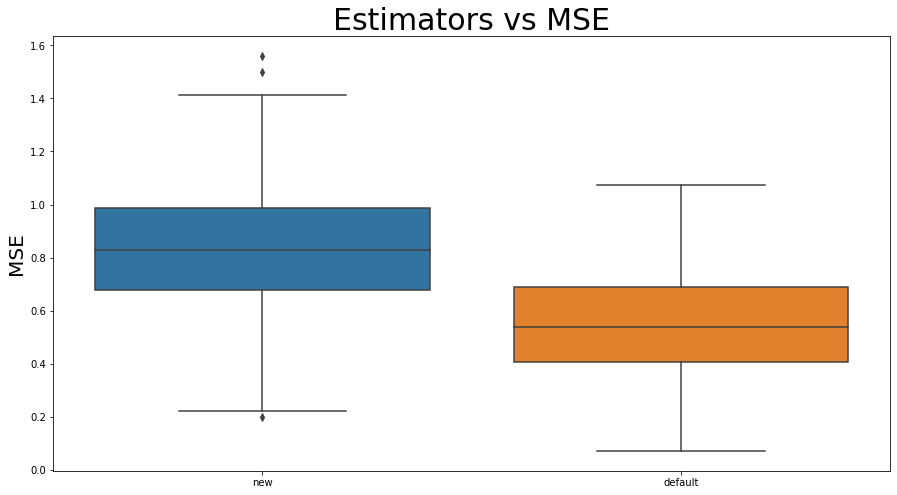

In [ ]:
#Compare default XGB vs optimised XGB
XGB_params = XGB_res.best_params

models_XGB = {}

models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)
models_XGB['default'] = xgboost.XGBRegressor()

results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(XGB_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

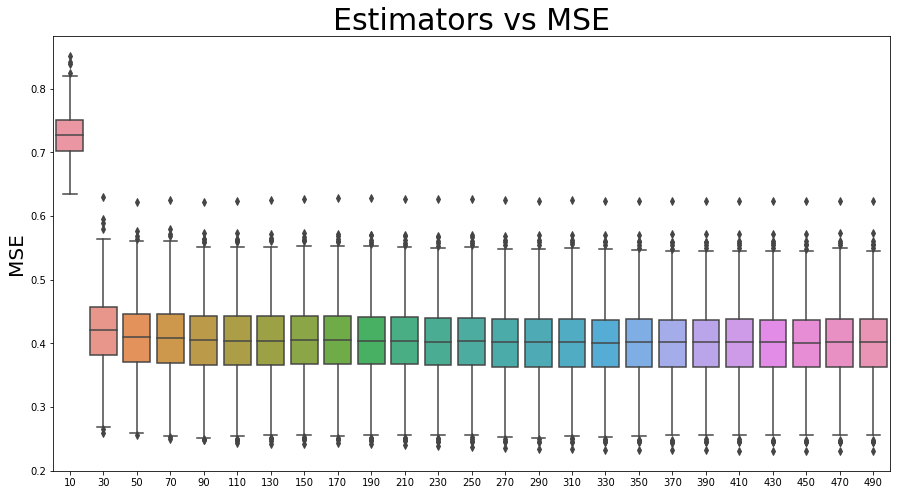

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = xgboost.XGBRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

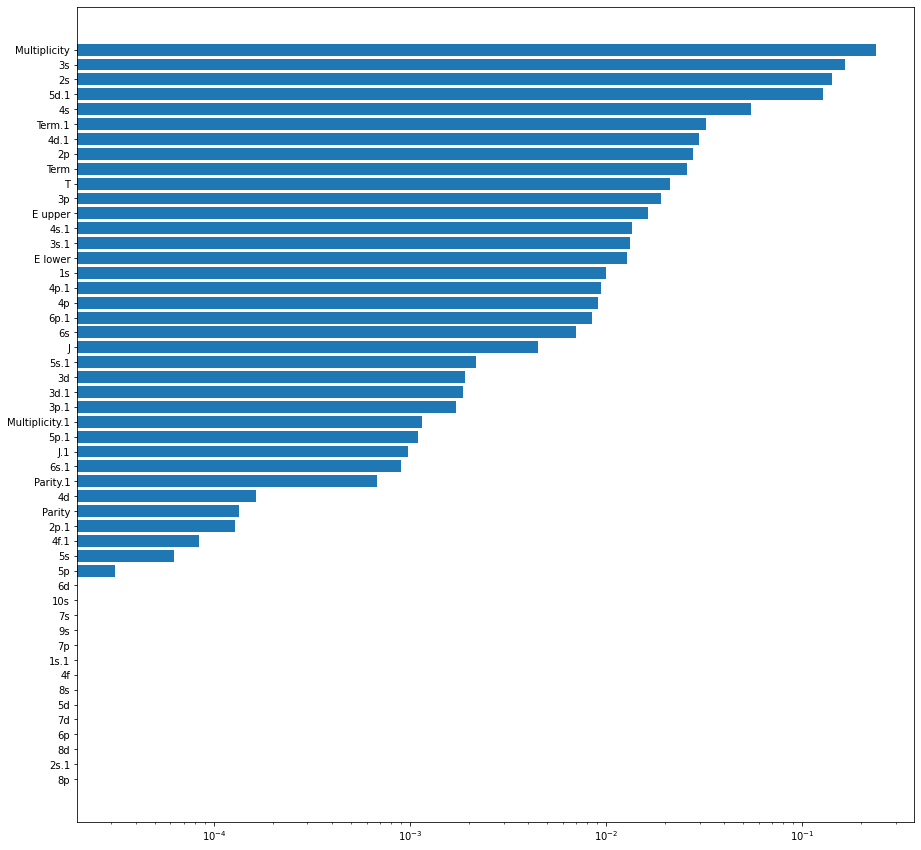

In [ ]:
#Visualising feature importances for the optimal XGB model
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(X_train.columns)[sorted])
plt.semilogx()
plt.show()

## LightGBM

In [ ]:
LightGBM_params = {
    'n_estimators' : 100,
    'learning_rate' : [0.01, 0.5],
    'num_leaves' : [2, 512],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : 5
    }

model_name = LightGBM

if apply_scaler:
    LightGBM_res = main(X = pd.DataFrame(scaler.transform(X_train)), y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 500)
else:
    LightGBM_res = main(X = X_train, y = Y_train, model_name = model_name, params = LightGBM_params, n_trials = 500)

with open(f'LightGBM_A+I_Extended_optimal_parameters', 'w') as fp:
    json.dump(LightGBM_res.best_params, fp)

[I 2023-05-03 20:07:37,049] A new study created in memory with name: no-name-e0b49d12-8286-4b3b-9cce-71bc92d676e0


Start hyperparameter optimization


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

{'n_estimators': 100, 'learning_rate': 0.030410166418596712, 'num_leaves': 433, 'reg_alpha': 0.0034744083278340555, 'reg_lambda': 0.0005403907923433353}
{'n_estimators': 100, 'learning_rate': 0.0274294387397494, 'num_leaves': 423, 'reg_alpha': 2.459621487379505e-08, 'reg_lambda': 0.6448062292857382}
{'n_estimators': 100, 'learning_rate': 0.05073624142964799, 'num_leaves': 300, 'reg_alpha': 0.0003378114504904625, 'reg_lambda': 0.0016742388324410414}
{'n_estimators': 100, 'learning_rate': 0.13080538826868618, 'num_leaves': 376, 'reg_alpha': 2.840481115063087e-07, 'reg_lambda': 0.0001634730210050691}
{'n_estimators': 100, 'learning_rate': 0.016673062837836417, 'num_leaves': 461, 'reg_alpha': 8.927540940108344e-08, 'reg_lambda': 0.034355027700948164}
[I 2023-05-03 20:08:14,568] Trial 4 finished with value: 0.42751122058044866 and parameters: {'learning_rate': 0.016673062837836417, 'num_leaves': 461, 'reg_alpha': 8.927540940108344e-08, 'reg_lambda': 0.034355027700948164}. Best is trial 4 wi

[I 2023-05-03 20:10:07,685] Trial 16 finished with value: 0.22127282199441548 and parameters: {'learning_rate': 0.12066382620287805, 'num_leaves': 251, 'reg_alpha': 9.809185871071249e-07, 'reg_lambda': 2.280158228521516}. Best is trial 12 with value: 0.20600058469833363.
{'n_estimators': 100, 'learning_rate': 0.24884439403488187, 'num_leaves': 106, 'reg_alpha': 0.21050462795946026, 'reg_lambda': 2.0363908095955972e-08}
[I 2023-05-03 20:10:18,075] Trial 19 finished with value: 0.21444837606352002 and parameters: {'learning_rate': 0.207676350200095, 'num_leaves': 216, 'reg_alpha': 0.00021358152993419802, 'reg_lambda': 8.748463043945732}. Best is trial 12 with value: 0.20600058469833363.
{'n_estimators': 100, 'learning_rate': 0.22843959849238668, 'num_leaves': 132, 'reg_alpha': 0.27121301949202753, 'reg_lambda': 3.4267359202967024e-08}
[I 2023-05-03 20:10:21,079] Trial 22 finished with value: 0.21400382378945296 and parameters: {'learning_rate': 0.22088021444481232, 'num_leaves': 110, 're

[I 2023-05-03 20:13:13,114] Trial 37 finished with value: 0.20369705096135796 and parameters: {'learning_rate': 0.3107460874863301, 'num_leaves': 345, 'reg_alpha': 5.3225332665138295e-05, 'reg_lambda': 1.2083109787243942e-06}. Best is trial 37 with value: 0.20369705096135796.
{'n_estimators': 100, 'learning_rate': 0.49686474618882587, 'num_leaves': 414, 'reg_alpha': 5.187744150236351e-05, 'reg_lambda': 5.989752398434767e-08}
[I 2023-05-03 20:13:20,840] Trial 38 finished with value: 0.21173595183879987 and parameters: {'learning_rate': 0.4999128148127059, 'num_leaves': 356, 'reg_alpha': 5.4411963831700315e-05, 'reg_lambda': 1.636458695676915e-07}. Best is trial 37 with value: 0.20369705096135796.
{'n_estimators': 100, 'learning_rate': 0.2906972960024635, 'num_leaves': 408, 'reg_alpha': 4.868265547582636e-05, 'reg_lambda': 8.145138699782542e-08}
[I 2023-05-03 20:13:22,284] Trial 39 finished with value: 0.21333272036910192 and parameters: {'learning_rate': 0.4956480718186297, 'num_leaves'

[I 2023-05-03 20:16:04,747] Trial 56 finished with value: 0.20728352010567672 and parameters: {'learning_rate': 0.4184544411070701, 'num_leaves': 210, 'reg_alpha': 0.00014351770245895723, 'reg_lambda': 1.3642875789858465e-05}. Best is trial 37 with value: 0.20369705096135796.
{'n_estimators': 100, 'learning_rate': 0.19619116010549154, 'num_leaves': 249, 'reg_alpha': 0.00015870714234075635, 'reg_lambda': 6.241315153274763e-05}
[I 2023-05-03 20:16:30,356] Trial 57 finished with value: 0.20915219222585973 and parameters: {'learning_rate': 0.40150513454739833, 'num_leaves': 221, 'reg_alpha': 0.00018235686931962716, 'reg_lambda': 1.5305436620954347e-05}. Best is trial 37 with value: 0.20369705096135796.
{'n_estimators': 100, 'learning_rate': 0.19834292958828553, 'num_leaves': 258, 'reg_alpha': 0.0046312173109088264, 'reg_lambda': 1.707376584458384e-06}
[I 2023-05-03 20:16:39,743] Trial 58 finished with value: 0.2089691767849089 and parameters: {'learning_rate': 0.38500678875654964, 'num_lea

{'n_estimators': 100, 'learning_rate': 0.33396887846224044, 'num_leaves': 310, 'reg_alpha': 5.939197488419186e-06, 'reg_lambda': 2.5067138957460202e-08}
[I 2023-05-03 20:19:05,938] Trial 73 finished with value: 0.20483579950693045 and parameters: {'learning_rate': 0.2536331996273975, 'num_leaves': 235, 'reg_alpha': 1.578429837978823e-05, 'reg_lambda': 1.0519350059572125e-06}. Best is trial 67 with value: 0.20331571694359027.
{'n_estimators': 100, 'learning_rate': 0.21727069655259873, 'num_leaves': 193, 'reg_alpha': 8.83720238328658e-05, 'reg_lambda': 7.307149899117937e-07}
[I 2023-05-03 20:19:31,170] Trial 76 finished with value: 0.2057409635334908 and parameters: {'learning_rate': 0.22015252897684506, 'num_leaves': 233, 'reg_alpha': 6.4373868901598166e-06, 'reg_lambda': 3.44470856574056e-08}. Best is trial 67 with value: 0.20331571694359027.
{'n_estimators': 100, 'learning_rate': 0.3333323587078309, 'num_leaves': 246, 'reg_alpha': 8.960758352645254e-05, 'reg_lambda': 6.898923626976183

[I 2023-05-03 20:22:21,815] Trial 93 finished with value: 0.20412364638009403 and parameters: {'learning_rate': 0.3221394065082077, 'num_leaves': 376, 'reg_alpha': 3.4303647527968216e-05, 'reg_lambda': 2.3100239360406964e-07}. Best is trial 67 with value: 0.20331571694359027.
{'n_estimators': 100, 'learning_rate': 0.3798737606571857, 'num_leaves': 433, 'reg_alpha': 7.802046553842853e-06, 'reg_lambda': 4.791096182930926e-08}
[I 2023-05-03 20:22:23,198] Trial 94 finished with value: 0.20758024909021514 and parameters: {'learning_rate': 0.39376704658264255, 'num_leaves': 457, 'reg_alpha': 3.331166636539674e-05, 'reg_lambda': 2.3975273924162334e-07}. Best is trial 67 with value: 0.20331571694359027.
{'n_estimators': 100, 'learning_rate': 0.31352777350194927, 'num_leaves': 433, 'reg_alpha': 7.447344816243843e-06, 'reg_lambda': 5.038208166229736e-08}
[I 2023-05-03 20:22:58,953] Trial 96 finished with value: 0.2030591276568841 and parameters: {'learning_rate': 0.3219172020068801, 'num_leaves'

[I 2023-05-03 20:25:44,217] Trial 113 finished with value: 0.2038186710238003 and parameters: {'learning_rate': 0.31053447945609314, 'num_leaves': 452, 'reg_alpha': 5.3985971748806665e-06, 'reg_lambda': 2.6424484914120024e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.4303922333804461, 'num_leaves': 474, 'reg_alpha': 2.321289988809087e-05, 'reg_lambda': 6.540045780421461e-07}
[I 2023-05-03 20:25:56,162] Trial 114 finished with value: 0.2058130678816005 and parameters: {'learning_rate': 0.3167892145753606, 'num_leaves': 456, 'reg_alpha': 6.580351641522018e-05, 'reg_lambda': 3.1188806086221726e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.42251072147405677, 'num_leaves': 467, 'reg_alpha': 1.0881070596447385e-05, 'reg_lambda': 7.204684904208221e-07}
[I 2023-05-03 20:26:00,258] Trial 115 finished with value: 0.20611082825568502 and parameters: {'learning_rate': 0.30947432168936145, 'num_leave

[I 2023-05-03 20:29:14,728] Trial 134 finished with value: 0.2078063938716946 and parameters: {'learning_rate': 0.3580767037790833, 'num_leaves': 320, 'reg_alpha': 0.00023013555463898341, 'reg_lambda': 1.2975386563722542e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3382782828078045, 'num_leaves': 441, 'reg_alpha': 3.9547339536896184e-05, 'reg_lambda': 2.536543311369846e-07}
[I 2023-05-03 20:29:22,872] Trial 132 finished with value: 0.20633341547302328 and parameters: {'learning_rate': 0.3413615202193734, 'num_leaves': 285, 'reg_alpha': 0.0001055465375331994, 'reg_lambda': 2.32161197992428e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.38197844094718614, 'num_leaves': 448, 'reg_alpha': 3.120376589158046e-05, 'reg_lambda': 4.4475164162513253e-07}
[I 2023-05-03 20:29:23,748] Trial 133 finished with value: 0.20582210255445993 and parameters: {'learning_rate': 0.3786580651720791, 'num_leaves'

[I 2023-05-03 20:32:17,881] Trial 151 finished with value: 0.20616401859588046 and parameters: {'learning_rate': 0.3304412663909419, 'num_leaves': 495, 'reg_alpha': 3.814710399224017e-06, 'reg_lambda': 1.3388545123048334e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.27555829700182344, 'num_leaves': 224, 'reg_alpha': 1.2687744120023714e-05, 'reg_lambda': 4.1759964241480265e-08}
[I 2023-05-03 20:32:19,477] Trial 152 finished with value: 0.2049320780610077 and parameters: {'learning_rate': 0.2786772344469, 'num_leaves': 470, 'reg_alpha': 4.081286984306568e-06, 'reg_lambda': 1.1306731731775954e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.27743752914916414, 'num_leaves': 405, 'reg_alpha': 1.2293447435801757e-05, 'reg_lambda': 4.0980671306481355e-08}
[I 2023-05-03 20:32:38,701] Trial 153 finished with value: 0.20625551292533148 and parameters: {'learning_rate': 0.27613575840632104, 'num_leave

[I 2023-05-03 20:34:59,378] Trial 170 finished with value: 0.203407076060019 and parameters: {'learning_rate': 0.3118705933597388, 'num_leaves': 205, 'reg_alpha': 6.763821379003914e-06, 'reg_lambda': 1.284552631608399e-08}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.23764709120388705, 'num_leaves': 211, 'reg_alpha': 9.316029204208159e-06, 'reg_lambda': 1.1644333387326134e-08}
[I 2023-05-03 20:34:59,975] Trial 169 finished with value: 0.20544667634863273 and parameters: {'learning_rate': 0.3591494336976483, 'num_leaves': 488, 'reg_alpha': 7.32932047483342e-06, 'reg_lambda': 2.0215985391498333e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.25165689836699695, 'num_leaves': 255, 'reg_alpha': 1.759234468335917e-05, 'reg_lambda': 1.724811754897048e-08}
[I 2023-05-03 20:35:26,138] Trial 172 finished with value: 0.20550978881694643 and parameters: {'learning_rate': 0.3036579378076137, 'num_leaves': 

[I 2023-05-03 20:38:07,190] Trial 189 finished with value: 0.2087445329033381 and parameters: {'learning_rate': 0.17004360452307182, 'num_leaves': 460, 'reg_alpha': 0.00014003613513221682, 'reg_lambda': 3.947816691750872e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3468056803222649, 'num_leaves': 339, 'reg_alpha': 4.7386979671399485e-06, 'reg_lambda': 1.1265594534999402e-06}
[I 2023-05-03 20:38:27,344] Trial 190 finished with value: 0.2063989511099522 and parameters: {'learning_rate': 0.3429114481290069, 'num_leaves': 456, 'reg_alpha': 0.00014472375308171656, 'reg_lambda': 1.56462984966602e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.32808901699101645, 'num_leaves': 341, 'reg_alpha': 3.582266441312284e-05, 'reg_lambda': 1.098068138245928e-06}
[I 2023-05-03 20:38:35,873] Trial 191 finished with value: 0.20622085186732134 and parameters: {'learning_rate': 0.3416028286135761, 'num_leaves'

[I 2023-05-03 20:41:34,228] Trial 208 finished with value: 0.2078157353405415 and parameters: {'learning_rate': 0.2779610554135815, 'num_leaves': 476, 'reg_alpha': 7.129382625328474e-05, 'reg_lambda': 1.8659207604742755e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3018971686263414, 'num_leaves': 492, 'reg_alpha': 0.00026199391406234195, 'reg_lambda': 3.7623764356091577e-08}
[I 2023-05-03 20:41:36,842] Trial 209 finished with value: 0.2061027243436334 and parameters: {'learning_rate': 0.2820308771882455, 'num_leaves': 481, 'reg_alpha': 7.165758350993182e-05, 'reg_lambda': 2.0605692067369827e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.31257925893925426, 'num_leaves': 358, 'reg_alpha': 7.842454690438606e-06, 'reg_lambda': 8.139326547937625e-07}
[I 2023-05-03 20:42:03,230] Trial 210 finished with value: 0.20530450381040496 and parameters: {'learning_rate': 0.3019318069246084, 'num_leaves'

[I 2023-05-03 20:44:31,280] Trial 226 finished with value: 0.20464576634778334 and parameters: {'learning_rate': 0.3546624087730615, 'num_leaves': 249, 'reg_alpha': 4.245109717544816e-06, 'reg_lambda': 2.2014017791656166e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.31214458501314646, 'num_leaves': 226, 'reg_alpha': 1.3204437611315539e-06, 'reg_lambda': 8.137874309086847e-06}
[I 2023-05-03 20:44:46,608] Trial 228 finished with value: 0.2044158153721946 and parameters: {'learning_rate': 0.35360425832493175, 'num_leaves': 385, 'reg_alpha': 4.650233435468471e-06, 'reg_lambda': 1.847102246938304e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.024480508282125522, 'num_leaves': 266, 'reg_alpha': 3.3787881665471966e-06, 'reg_lambda': 1.87017492837174e-07}
[I 2023-05-03 20:44:50,063] Trial 229 finished with value: 0.20731533997084606 and parameters: {'learning_rate': 0.3556781585512927, 'num_leave

[I 2023-05-03 20:47:34,131] Trial 246 finished with value: 0.2046092540446204 and parameters: {'learning_rate': 0.3341924774991038, 'num_leaves': 358, 'reg_alpha': 5.295241495008544e-06, 'reg_lambda': 3.44013354878462e-05}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.29979514631717596, 'num_leaves': 330, 'reg_alpha': 8.980725420995345e-06, 'reg_lambda': 4.6635711407686825e-05}
[I 2023-05-03 20:47:40,024] Trial 247 finished with value: 0.2054374074644893 and parameters: {'learning_rate': 0.2997541140246796, 'num_leaves': 354, 'reg_alpha': 7.064210622010125e-07, 'reg_lambda': 5.6882585297345484e-05}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2983325795714768, 'num_leaves': 238, 'reg_alpha': 3.7720874818314407e-07, 'reg_lambda': 1.0144138805974217e-08}
[I 2023-05-03 20:48:15,682] Trial 248 finished with value: 0.20787731032415296 and parameters: {'learning_rate': 0.18253155244047448, 'num_leaves'

[I 2023-05-03 20:50:50,017] Trial 265 finished with value: 0.20554186914414907 and parameters: {'learning_rate': 0.27127654996322265, 'num_leaves': 372, 'reg_alpha': 4.329841294487798e-05, 'reg_lambda': 0.00041610283177673013}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.09344619395084283, 'num_leaves': 301, 'reg_alpha': 0.0015330544250545676, 'reg_lambda': 8.658185897716574e-05}
[I 2023-05-03 20:51:02,989] Trial 266 finished with value: 0.2068550221284328 and parameters: {'learning_rate': 0.2631735956269009, 'num_leaves': 375, 'reg_alpha': 4.231449557961255e-05, 'reg_lambda': 8.3251896684611e-05}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2063311855175625, 'num_leaves': 311, 'reg_alpha': 2.040842268252339e-05, 'reg_lambda': 0.00011106886296850911}
[I 2023-05-03 20:51:13,811] Trial 267 finished with value: 0.20822781148797526 and parameters: {'learning_rate': 0.20661804028258152, 'num_leaves':

[I 2023-05-03 20:53:52,978] Trial 283 finished with value: 0.2051810003372981 and parameters: {'learning_rate': 0.27734552961253606, 'num_leaves': 462, 'reg_alpha': 1.8035176906422595e-05, 'reg_lambda': 9.152245525134146e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.36371906387997127, 'num_leaves': 241, 'reg_alpha': 6.463381380388294e-05, 'reg_lambda': 2.952198973772499}
[I 2023-05-03 20:53:59,985] Trial 285 finished with value: 0.20794100580930225 and parameters: {'learning_rate': 0.38897373118877016, 'num_leaves': 265, 'reg_alpha': 0.00019666762536147198, 'reg_lambda': 4.629752429910468e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3576580682472076, 'num_leaves': 446, 'reg_alpha': 2.83411029952355e-05, 'reg_lambda': 3.4868196171076966e-06}
[I 2023-05-03 20:54:01,767] Trial 286 finished with value: 0.20844534640175855 and parameters: {'learning_rate': 0.37162095275300144, 'num_leaves': 

[I 2023-05-03 20:56:45,748] Trial 302 finished with value: 0.20582368847740135 and parameters: {'learning_rate': 0.3383023795494492, 'num_leaves': 284, 'reg_alpha': 7.817589791097008e-06, 'reg_lambda': 6.821127837882902e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2590690548605573, 'num_leaves': 485, 'reg_alpha': 3.750237905072905e-06, 'reg_lambda': 0.010003130748517367}
[I 2023-05-03 20:56:59,154] Trial 303 finished with value: 0.20661016403422897 and parameters: {'learning_rate': 0.4251063335117709, 'num_leaves': 276, 'reg_alpha': 0.00039153399401089926, 'reg_lambda': 0.33597221241946684}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2519292975693113, 'num_leaves': 244, 'reg_alpha': 4.152159893124211e-06, 'reg_lambda': 4.188168045134928}
[I 2023-05-03 20:57:09,962] Trial 305 finished with value: 0.20950538504146063 and parameters: {'learning_rate': 0.44185961237262017, 'num_leaves': 287, '

[I 2023-05-03 20:59:52,677] Trial 322 finished with value: 0.2061431062878169 and parameters: {'learning_rate': 0.291589651983809, 'num_leaves': 468, 'reg_alpha': 1.9757556153738647e-05, 'reg_lambda': 5.516849403896199e-08}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3545695390211826, 'num_leaves': 365, 'reg_alpha': 0.0034031014844812238, 'reg_lambda': 0.09642966913730876}
[I 2023-05-03 21:00:03,284] Trial 323 finished with value: 0.20680207432986192 and parameters: {'learning_rate': 0.3493926532599302, 'num_leaves': 369, 'reg_alpha': 0.0037956416791299387, 'reg_lambda': 0.42052423397692235}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.40385615369397854, 'num_leaves': 365, 'reg_alpha': 2.4281531789167057e-06, 'reg_lambda': 1.0009943115732487}
[I 2023-05-03 21:00:05,741] Trial 324 finished with value: 0.204503400471385 and parameters: {'learning_rate': 0.3510984362743914, 'num_leaves': 378, 'reg

[I 2023-05-03 21:03:17,124] Trial 341 finished with value: 0.20534184525253346 and parameters: {'learning_rate': 0.24218503538935823, 'num_leaves': 333, 'reg_alpha': 7.972278694067221e-06, 'reg_lambda': 0.0001862954663134876}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2778706305097947, 'num_leaves': 315, 'reg_alpha': 1.781669028161633e-05, 'reg_lambda': 3.075719725786987e-05}
[I 2023-05-03 21:03:27,618] Trial 343 finished with value: 0.2049198574187804 and parameters: {'learning_rate': 0.2761173513465916, 'num_leaves': 336, 'reg_alpha': 6.846677151608862e-06, 'reg_lambda': 1.3080851104881744e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3628671053250376, 'num_leaves': 347, 'reg_alpha': 1.9435286194676837e-05, 'reg_lambda': 2.5773126502827045e-05}
[I 2023-05-03 21:03:28,216] Trial 342 finished with value: 0.2073156779460587 and parameters: {'learning_rate': 0.23293715494502878, 'num_leaves'

[I 2023-05-03 21:06:14,467] Trial 360 finished with value: 0.2058519469635213 and parameters: {'learning_rate': 0.3028046581880637, 'num_leaves': 296, 'reg_alpha': 6.997576190969611e-05, 'reg_lambda': 2.0675025633704878e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3335571254360058, 'num_leaves': 241, 'reg_alpha': 9.359903538339897e-06, 'reg_lambda': 2.128463392290931}
[I 2023-05-03 21:06:44,180] Trial 361 finished with value: 0.20628216130848234 and parameters: {'learning_rate': 0.29904927794384967, 'num_leaves': 435, 'reg_alpha': 7.251332420677318e-05, 'reg_lambda': 2.0512960624460624e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.33307349625415217, 'num_leaves': 149, 'reg_alpha': 0.0001745007483218513, 'reg_lambda': 0.14618171806797586}
[I 2023-05-03 21:06:53,664] Trial 362 finished with value: 0.20561695631406476 and parameters: {'learning_rate': 0.34162174329244144, 'num_leaves': 295

[I 2023-05-03 21:09:27,068] Trial 379 finished with value: 0.20574734145240417 and parameters: {'learning_rate': 0.2889322435614795, 'num_leaves': 238, 'reg_alpha': 2.313648041250275e-05, 'reg_lambda': 2.259299902821447e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.03180510972134237, 'num_leaves': 233, 'reg_alpha': 4.640203035343051e-05, 'reg_lambda': 1.256831087644915e-07}
[I 2023-05-03 21:09:36,620] Trial 380 finished with value: 0.21462922411764662 and parameters: {'learning_rate': 0.13714105567231746, 'num_leaves': 238, 'reg_alpha': 1.57122471432051e-05, 'reg_lambda': 0.00108227695253424}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.3117785716754005, 'num_leaves': 355, 'reg_alpha': 4.526119261062942e-05, 'reg_lambda': 1.380220222700849e-07}
[I 2023-05-03 21:09:54,748] Trial 381 finished with value: 0.2047572956431528 and parameters: {'learning_rate': 0.30009512893029455, 'num_leaves': 38

[I 2023-05-03 21:12:31,606] Trial 398 finished with value: 0.2073865243310013 and parameters: {'learning_rate': 0.40621844045497507, 'num_leaves': 444, 'reg_alpha': 2.1110059918726375e-06, 'reg_lambda': 1.5930605594295622e-08}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2807516010164463, 'num_leaves': 247, 'reg_alpha': 1.3925582506821086, 'reg_lambda': 0.23996769828344572}
[I 2023-05-03 21:12:41,279] Trial 399 finished with value: 0.20526374963911392 and parameters: {'learning_rate': 0.34940436902086647, 'num_leaves': 372, 'reg_alpha': 2.0220922689562362e-06, 'reg_lambda': 3.229283814995789e-07}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.059485562953630375, 'num_leaves': 251, 'reg_alpha': 5.6157212375738506e-06, 'reg_lambda': 0.26000887326473515}
[I 2023-05-03 21:12:49,765] Trial 402 finished with value: 0.2377835091667317 and parameters: {'learning_rate': 0.19824507057564297, 'num_leaves': 2

[I 2023-05-03 21:15:30,473] Trial 419 finished with value: 0.20445555103791607 and parameters: {'learning_rate': 0.25789589292795706, 'num_leaves': 269, 'reg_alpha': 3.0328390385913163e-05, 'reg_lambda': 0.0008987427378541881}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.2535007651160724, 'num_leaves': 340, 'reg_alpha': 2.8853051470676448e-06, 'reg_lambda': 5.486147360122375e-05}
[I 2023-05-03 21:15:33,033] Trial 418 finished with value: 0.22923089795208568 and parameters: {'learning_rate': 0.08168468761591897, 'num_leaves': 393, 'reg_alpha': 0.0007413533899571531, 'reg_lambda': 0.013530440616367963}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.040269949705321585, 'num_leaves': 341, 'reg_alpha': 2.833036720082388e-06, 'reg_lambda': 3.357373552889039}
[I 2023-05-03 21:15:33,786] Trial 420 finished with value: 0.24312777805303 and parameters: {'learning_rate': 0.08523106708624836, 'num_leaves': 26

[I 2023-05-03 21:18:38,673] Trial 436 finished with value: 0.20519989678706688 and parameters: {'learning_rate': 0.30617590309239917, 'num_leaves': 227, 'reg_alpha': 0.012365224876198328, 'reg_lambda': 1.5658052749029324e-06}. Best is trial 96 with value: 0.2030591276568841.
{'n_estimators': 100, 'learning_rate': 0.14100105755729872, 'num_leaves': 256, 'reg_alpha': 1.952082567291997e-05, 'reg_lambda': 3.5745707799951895e-08}
[I 2023-05-03 21:18:42,196] Trial 437 finished with value: 0.2027555094843781 and parameters: {'learning_rate': 0.3036382079301533, 'num_leaves': 246, 'reg_alpha': 1.9225809730658172e-05, 'reg_lambda': 1.6770271050505558e-06}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.4440497109112761, 'num_leaves': 253, 'reg_alpha': 1.6637735561951806e-05, 'reg_lambda': 1.6507992562350501e-06}
[I 2023-05-03 21:18:45,561] Trial 438 finished with value: 0.20595990433239403 and parameters: {'learning_rate': 0.3023617377070367, 'num_lea

[I 2023-05-03 21:21:46,333] Trial 456 finished with value: 0.21053077773496504 and parameters: {'learning_rate': 0.27125329703839623, 'num_leaves': 210, 'reg_alpha': 3.495776966655679e-07, 'reg_lambda': 9.26064646017753}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.3445900098405026, 'num_leaves': 262, 'reg_alpha': 4.765215414518186e-06, 'reg_lambda': 0.03363345920564651}
[I 2023-05-03 21:21:49,040] Trial 455 finished with value: 0.20623706868780606 and parameters: {'learning_rate': 0.27049565877306886, 'num_leaves': 270, 'reg_alpha': 4.92797328087953e-06, 'reg_lambda': 4.605895139744143e-07}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.3435827872221669, 'num_leaves': 264, 'reg_alpha': 0.05577838069083881, 'reg_lambda': 2.0435558275765918e-05}
[I 2023-05-03 21:22:03,286] Trial 458 finished with value: 0.20652594727114057 and parameters: {'learning_rate': 0.27118508885519843, 'num_leaves': 262, 

[I 2023-05-03 21:25:01,739] Trial 474 finished with value: 0.22856943906424573 and parameters: {'learning_rate': 0.08752536076791839, 'num_leaves': 254, 'reg_alpha': 8.000068648465096e-06, 'reg_lambda': 7.496184446180114e-07}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.014226528180999438, 'num_leaves': 230, 'reg_alpha': 0.00035290637236682715, 'reg_lambda': 0.008627512960703482}
[I 2023-05-03 21:25:05,746] Trial 476 finished with value: 0.2080106564453646 and parameters: {'learning_rate': 0.39236537622297457, 'num_leaves': 253, 'reg_alpha': 3.5903709793217415e-08, 'reg_lambda': 0.0006168759149138987}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.07762272255780071, 'num_leaves': 448, 'reg_alpha': 0.00037882323938201765, 'reg_lambda': 1.1215475765151891e-06}
[I 2023-05-03 21:25:07,573] Trial 475 finished with value: 0.2047071791904403 and parameters: {'learning_rate': 0.32605355631740396, 'num_l

[I 2023-05-03 21:27:58,075] Trial 493 finished with value: 0.20615085225799099 and parameters: {'learning_rate': 0.286289410127945, 'num_leaves': 273, 'reg_alpha': 0.001870465220631384, 'reg_lambda': 2.8108427805386625e-07}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.0653339143882036, 'num_leaves': 465, 'reg_alpha': 2.3500320374183978e-05, 'reg_lambda': 3.436360835089924e-08}
[I 2023-05-03 21:28:00,436] Trial 494 finished with value: 0.2055562392337899 and parameters: {'learning_rate': 0.3248628034821052, 'num_leaves': 195, 'reg_alpha': 1.9164980928627938e-05, 'reg_lambda': 2.234285989745105e-06}. Best is trial 437 with value: 0.2027555094843781.
{'n_estimators': 100, 'learning_rate': 0.25461524674808056, 'num_leaves': 114, 'reg_alpha': 6.860761894401562e-05, 'reg_lambda': 2.4235366398245294e-08}
[I 2023-05-03 21:28:03,894] Trial 495 finished with value: 0.21018775479020788 and parameters: {'learning_rate': 0.28348905949806813, 'num_leave

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


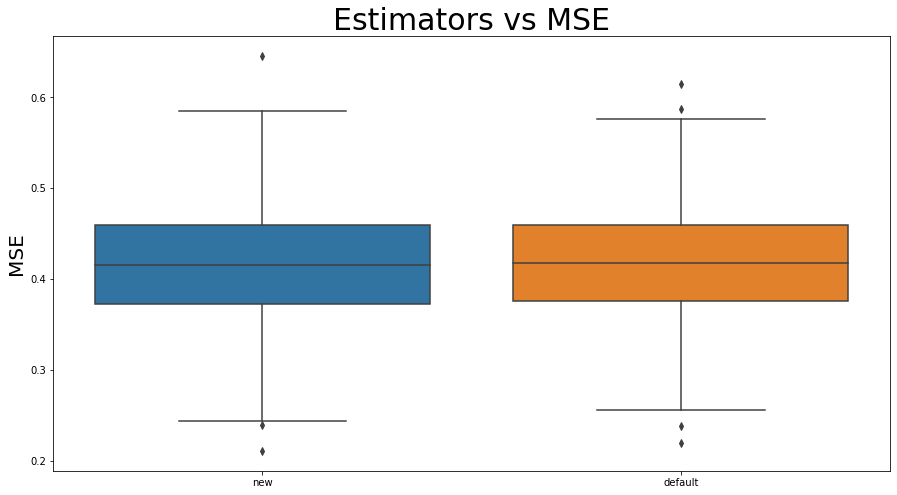

In [ ]:
#Compare default LightGBM vs optimised LightGBM
LightGBM_params = LightGBM_res.best_params

models_LightGBM = {}

models_LightGBM['new'] = lightgbm.LGBMRegressor(**LightGBM_params, n_estimators = 500)
models_LightGBM['default'] = lightgbm.LGBMRegressor()

results_LightGBM = train_and_test_regressor(models_LightGBM, X_train, Y_train, X_test, Y_test)
plot_model_comparison(results_LightGBM)

In [ ]:
#Visualising importance of GB model parameters
optuna.visualization.plot_param_importances(LightGBM_res)

Fitting 10
Fitting 30
Fitting 50
Fitting 70
Fitting 90
Fitting 110
Fitting 130
Fitting 150
Fitting 170
Fitting 190
Fitting 210
Fitting 230
Fitting 250
Fitting 270
Fitting 290
Fitting 310
Fitting 330
Fitting 350
Fitting 370
Fitting 390
Fitting 410
Fitting 430
Fitting 450
Fitting 470
Fitting 490
Calculating bootstrap score for 10
Calculating bootstrap score for 30
Calculating bootstrap score for 50
Calculating bootstrap score for 70
Calculating bootstrap score for 90
Calculating bootstrap score for 110
Calculating bootstrap score for 130
Calculating bootstrap score for 150
Calculating bootstrap score for 170
Calculating bootstrap score for 190
Calculating bootstrap score for 210
Calculating bootstrap score for 230
Calculating bootstrap score for 250
Calculating bootstrap score for 270
Calculating bootstrap score for 290
Calculating bootstrap score for 310
Calculating bootstrap score for 330
Calculating bootstrap score for 350
Calculating bootstrap score for 370
Calculating bootstrap scor

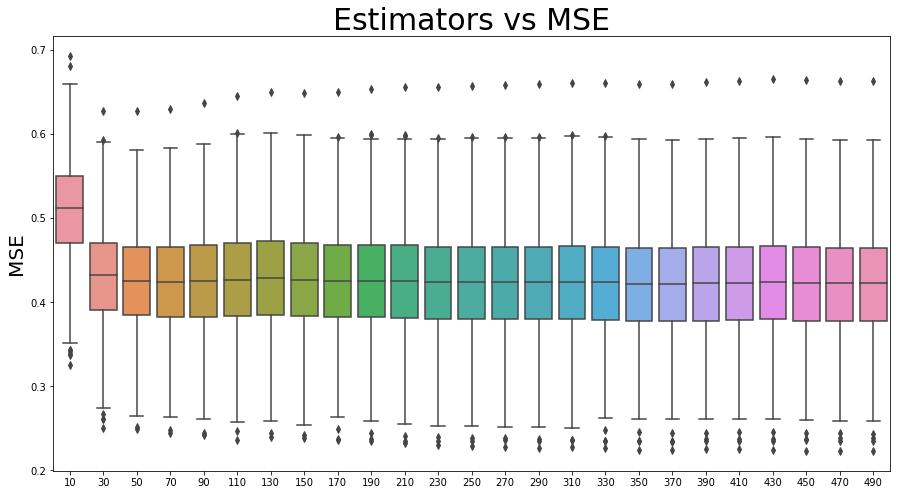

In [ ]:
#Visualising selection of n_estimators
model = {}
for i in range(10, 501, 20):
    model[f'{i}'] = lightgbm.LGBMRegressor(**XGB_params, n_estimators = i)

path = train_and_test_regressor(model, X_train, Y_train, X_test, Y_test)
plot_model_comparison(path)

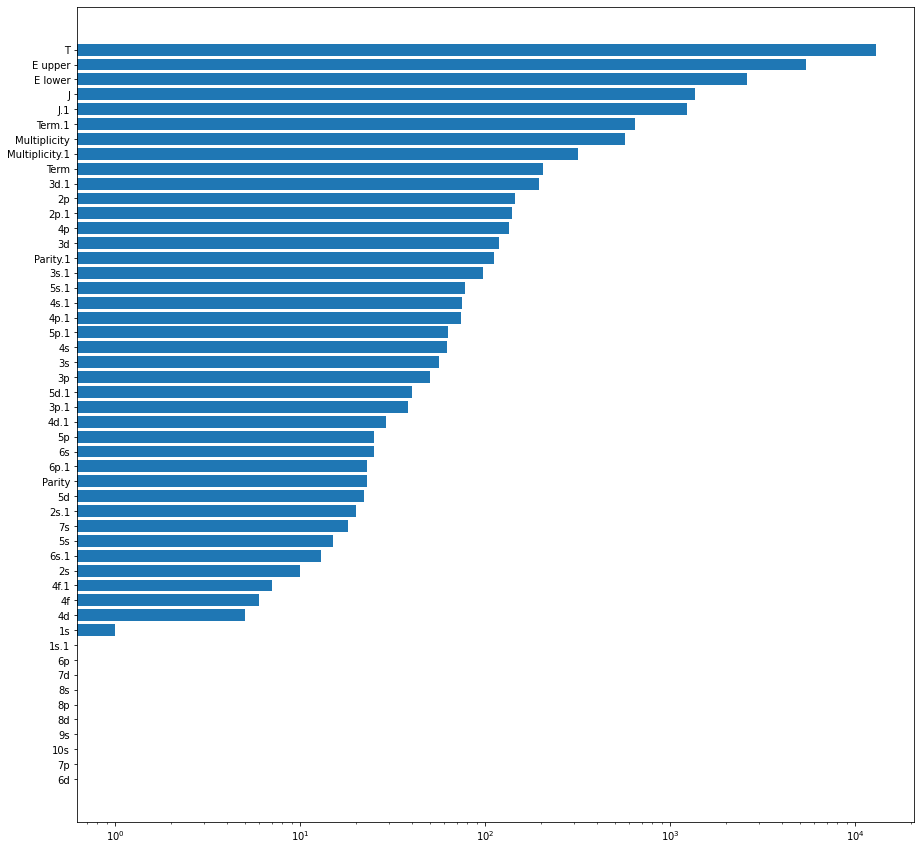

In [ ]:
feature_importance = models_LightGBM['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XW_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [ ]:
torch.cuda.is_available()

True

In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : 1
    }

model_name = TabNet

TabNet_res = main(X = X_train, y = Y_train, model_name = model_name, params = TabNet_params, n_trials = 1000)

with open(f'TabNet_A+I_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2023-04-29 14:42:25,476] A new study created in memory with name: no-name-6d1f81d7-da99-4458-8900-9a2cb4dbd772
C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


Start hyperparameter optimization


  0%|          | 0/1000 [00:00<?, ?it/s]

{'device_name': 'cuda', 'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 74.54875


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 69.61563


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 29.53709


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 30.19352


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 22.23656


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Best trial: 0. Best value: 6.5246:   0%|          | 1/1000 [06:21<105:57:44, 381.85s/it]

[I 2023-04-29 14:48:47,322] Trial 0 finished with value: 6.524598399825075 and parameters: {'n_d': 10, 'n_steps': 8, 'gamma': 1.062036414714562, 'n_independent': 10, 'n_shared': 17, 'momentum': 0.2582866324854284, 'mask_type': 'entmax'}. Best is trial 0 with value: 6.524598399825075.
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 17, 'gamma': 1.0933732568292283, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.0078233485195872, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 50.37204


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
%debug

> c:\users\alex\.conda\envs\cudaenv\lib\site-packages\torch\random.py(42)manual_seed()
     40         torch.cuda.manual_seed_all(seed)
     41 
---> 42     return default_generator.manual_seed(seed)
     43 
     44 

ipdb> torch.cuda._is_in_bad_fork()
False


Fitting TabNet_new

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.28204
Fitting TabNet_default


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 184 with best_epoch = 164 and best_eval_mse = 0.21485
Calculating bootstrap score for TabNet_new


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Calculating bootstrap score for TabNet_default


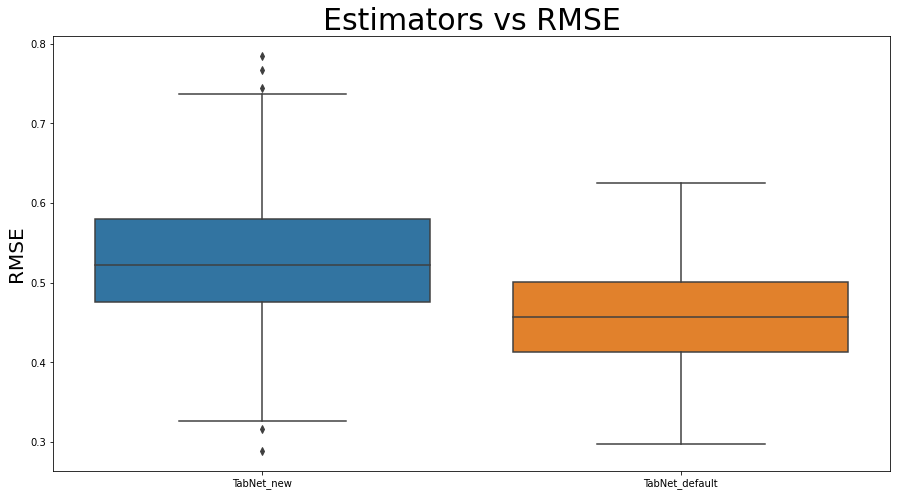

In [ ]:
TabNet_params = TabNet_res.best_params
TabNet_params['device_name'] = 'cuda'

models_TabNet = {}

models_TabNet['TabNet_new'] = TabNet(TabNet_params)
models_TabNet['TabNet_default'] = TabNet({'device_name' : 'cuda',
                                   'n_d' : 8})

results_TabNet = train_and_test_regressor(models_TabNet, X_train, Y_train, X_test, Y_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

**Attention!!!** Before running the next few cells, make sure that you set *augmented_train_set = False* and *scaled_target = False* in "Dataset modifications section.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Getting KNN_A+I predictions
Getting RF_A+I_StandardScaler predictions
Getting XGB_A+I predictions
Getting LightGBM_A+I predictions
Getting TabNet_A+I_StandardScaler predictions
epoch 0  | loss: 40.80118| eval_mse: 87.65288|  0:00:01s
epoch 1  | loss: 47.98224| eval_mse: 89.80471|  0:00:01s
epoch 2  | loss: 21.96259| eval_mse: 59.71663|  0:00:01s
epoch 3  | loss: 24.78842| eval_mse: 60.2678 |  0:00:01s
epoch 4  | loss: 32.59586| eval_mse: 55.49662|  0:00:01s
epoch 5  | loss: 28.03425| eval_mse: 55.51716|  0:00:01s
epoch 6  | loss: 30.67748| eval_mse: 51.39029|  0:00:01s
epoch 7  | loss: 23.08803| eval_mse: 43.4472 |  0:00:01s
epoch 8  | loss: 12.83283| eval_mse: 42.30503|  0:00:01s
epoch 9  | loss: 18.7231 | eval_mse: 47.26833|  0:00:01s
epoch 10 | loss: 13.08921| eval_mse: 49.06802|  0:00:02s
epoch 11 | loss: 20.42188| eval_mse: 49.03332|  0:00:02s
epoch 12 | loss: 9.94857 | eval_mse: 46.17999|  0:00:02s
epoch 13 | loss: 8.00401 | eval_mse: 51.87704|  0:00:02s
epoch 14 | loss: 7.40558 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting KNN_A+I predictions
Plotting RF_A+I_StandardScaler predictions
Plotting XGB_A+I predictions
Plotting LightGBM_A+I predictions
Plotting TabNet_A+I_StandardScaler predictions


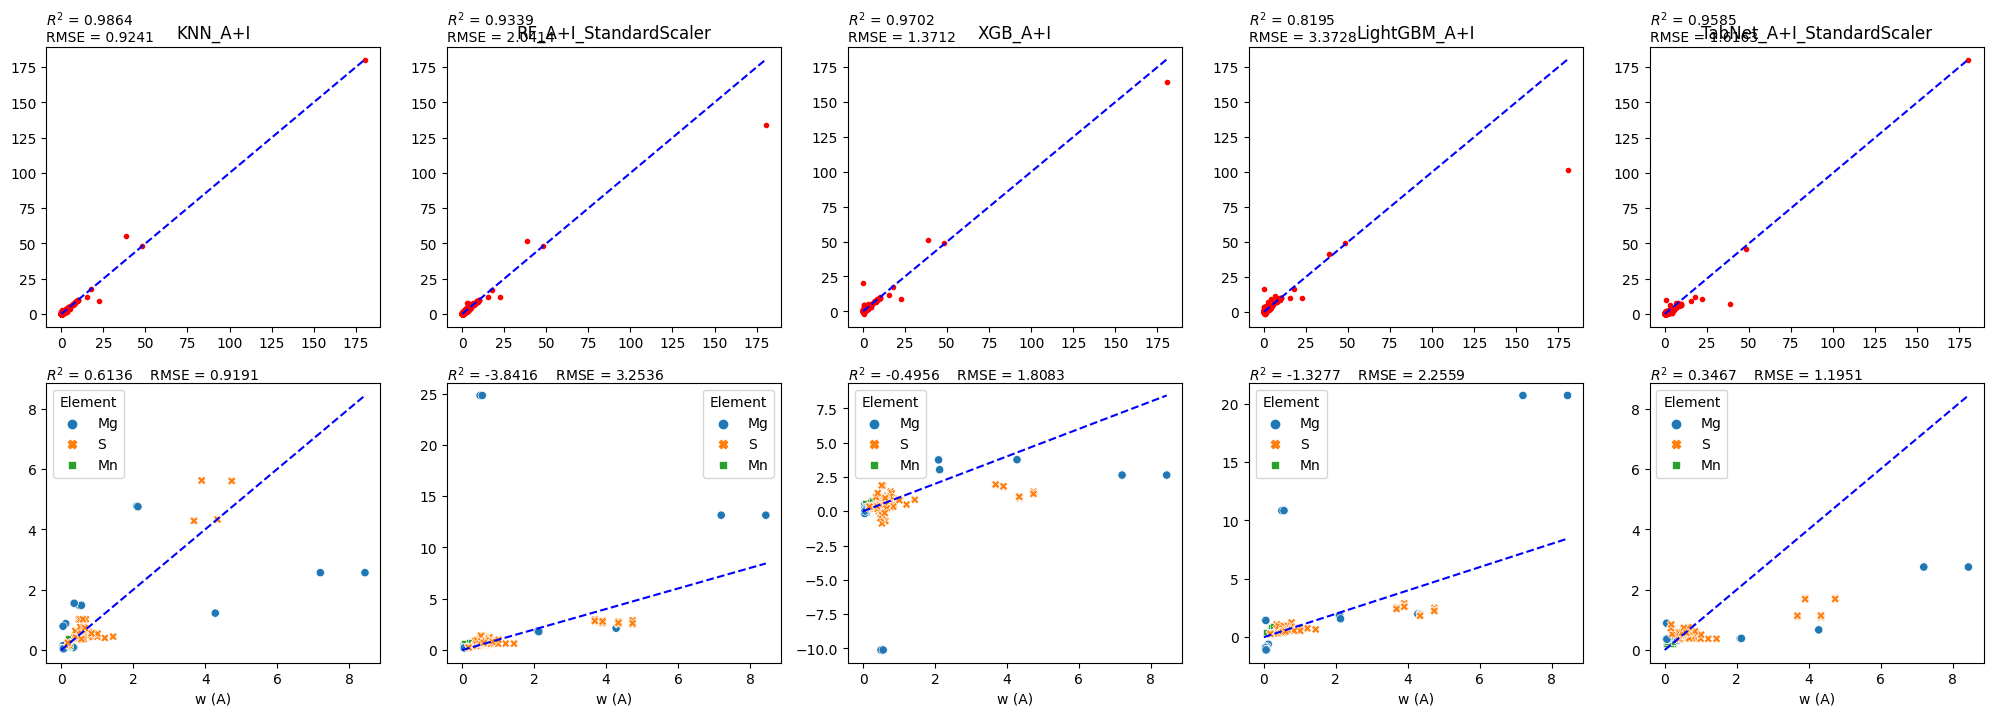

'preds, preds_elem, fix, ax = plot_model_prediction(models_d,\n                                                    X_train, Y_train,\n                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),\n                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'

In [36]:
models = ['KNN_A+I',
          'RF_A+I_StandardScaler',
          'XGB_A+I',
          'LightGBM_A+I',
          'TabNet_A+I_StandardScaler']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                   X_train, Y_train,
                                                   X_test, Y_test,
                                                   X_elem, Y_elem, label_width_elements,
                                                   scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

Plotting KNN_A+I predictions
Plotting RF_A+I_StandardScaler predictions
Plotting XGB_A+I predictions
Plotting LightGBM_A+I predictions
Plotting TabNet_A+I_StandardScaler predictions


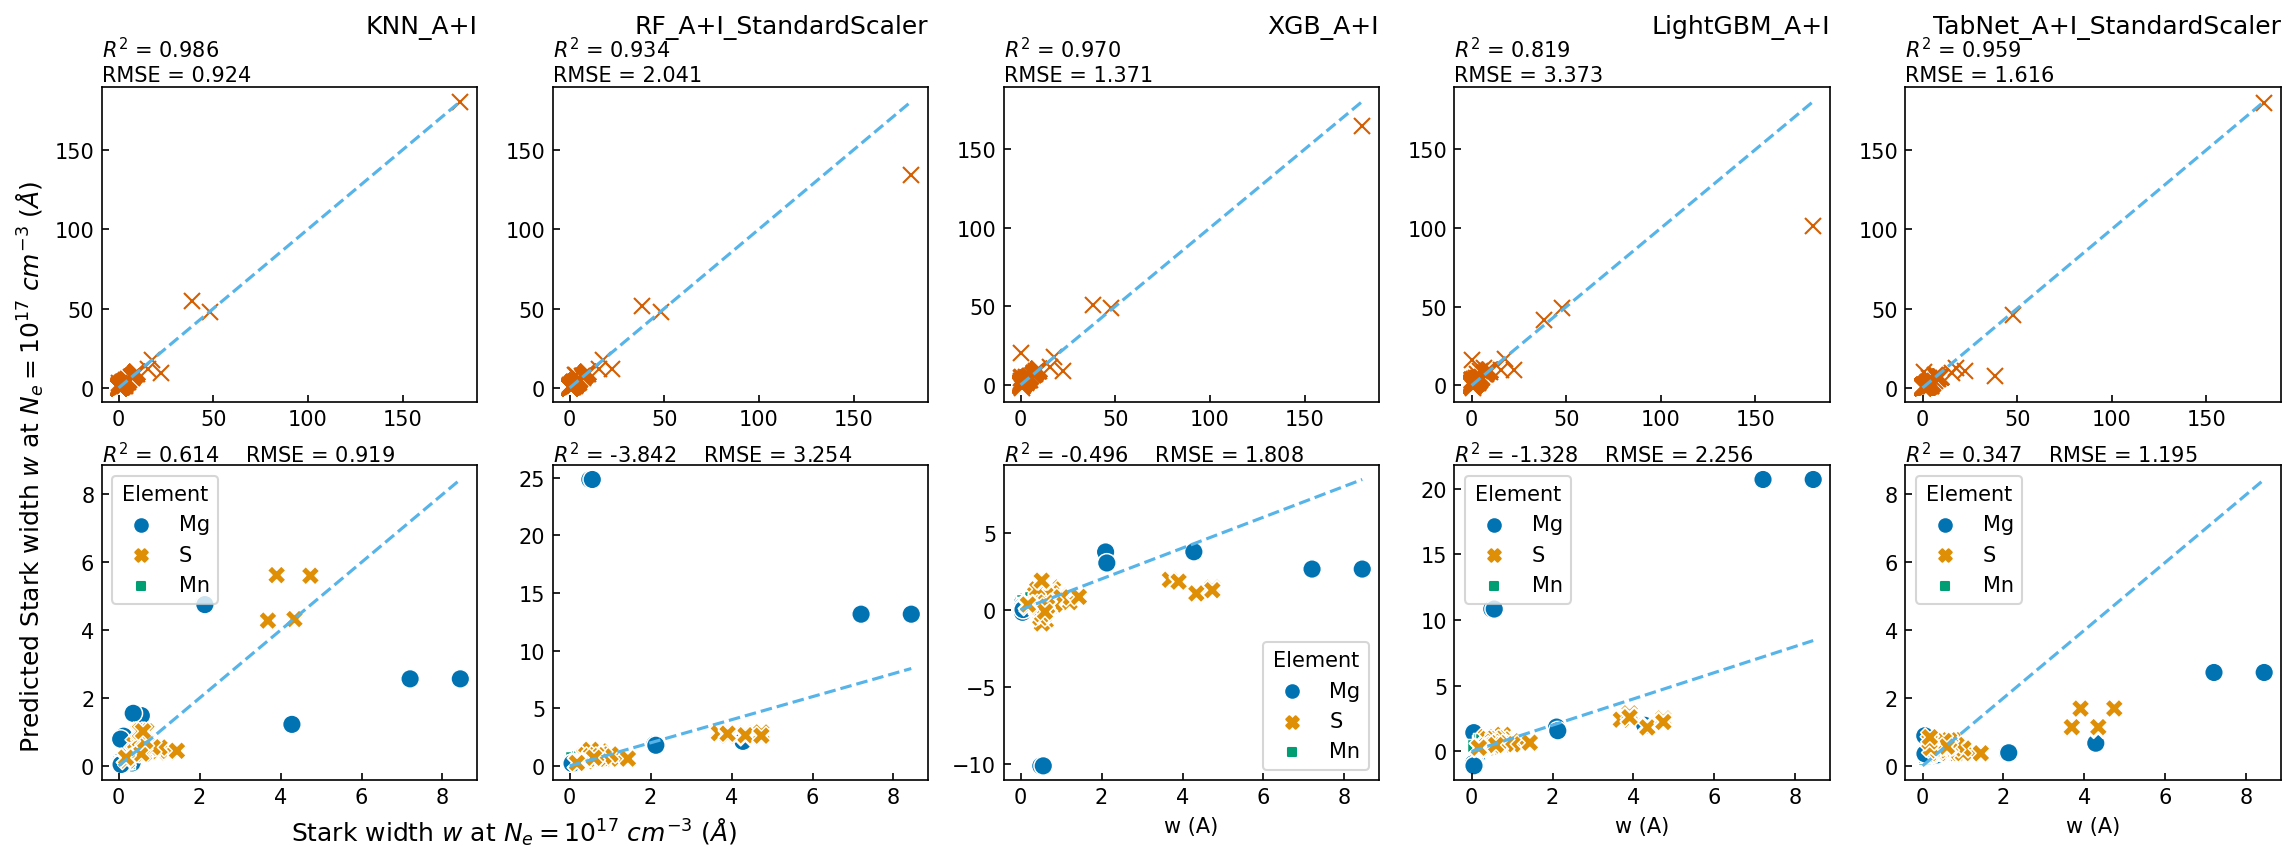

In [38]:
YW_test = Y_test
YW_elem = Y_elem
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('predref.svg', transparent = True, format = 'svg')

Calculating bootstrap score for KNN_A+I
Calculating bootstrap score for XGB_A+I
Calculating bootstrap score for LightGBM_A+I


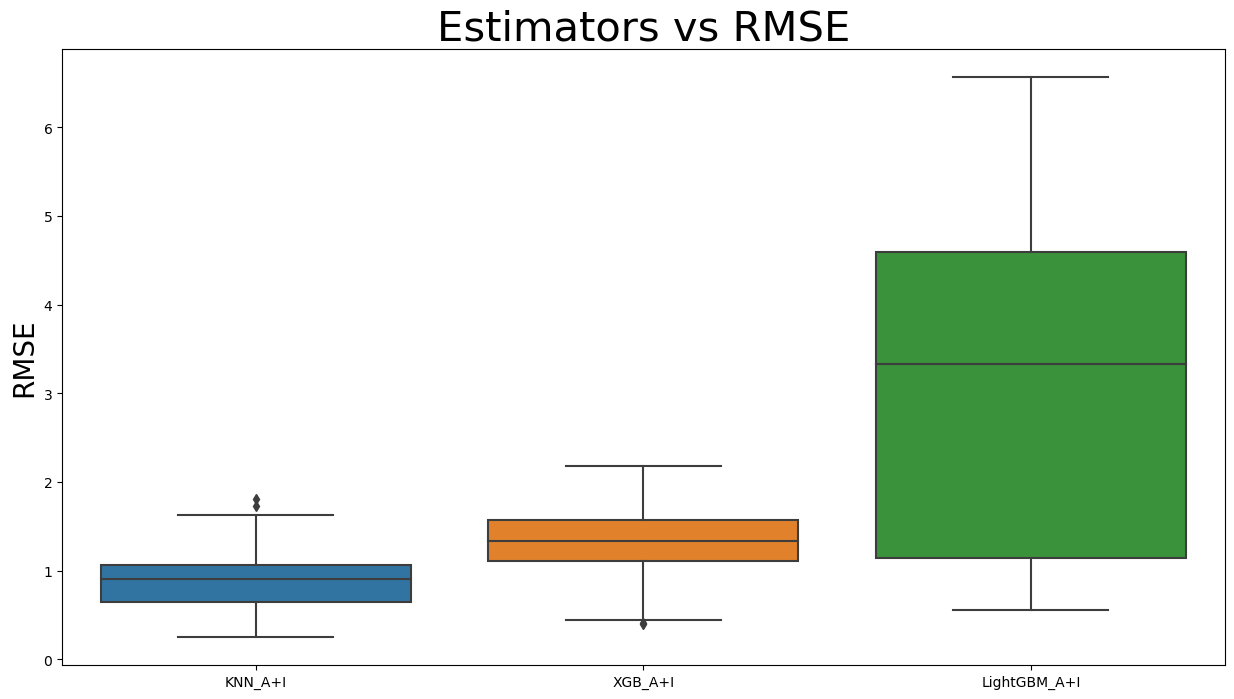

In [ ]:
'''results_original = train_and_test_regressor(models_d,
                                            pd.DataFrame(scaler.transform(X_train)), Y_train,
                                            pd.DataFrame(scaler.transform(X_test)), Y_test,
                                            train = False)'''
results_original = train_and_test_regressor(models_d,
                                            X_train, Y_train,
                                            X_test, Y_test,
                                            train = False)
plot_model_comparison(results_original)

## Width. Scaled *targets*

**Attention!!!** Before running the next few cells, make sure that you set *augmented_train_set = False* and *scaled_target = True* in "Dataset modifications section.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Getting KNN_A+I_Scaled predictions
Getting RF_A+I_StandardScaler_Scaled predictions
Getting XGB_A+I_StandardScaler_Scaled predictions
Getting LightGBM_A+I_Scaled predictions
Getting TabNet_A+I_StandardScaler_Scaled predictions
epoch 0  | loss: 56.58392| eval_mse: 67.66869|  0:00:00s
epoch 1  | loss: 55.54956| eval_mse: 65.85971|  0:00:00s
epoch 2  | loss: 35.65533| eval_mse: 65.50925|  0:00:00s
epoch 3  | loss: 46.49617| eval_mse: 65.49638|  0:00:00s
epoch 4  | loss: 52.7099 | eval_mse: 66.59164|  0:00:00s
epoch 5  | loss: 55.06315| eval_mse: 65.5002 |  0:00:00s
epoch 6  | loss: 48.22193| eval_mse: 65.46542|  0:00:00s
epoch 7  | loss: 53.74984| eval_mse: 65.48163|  0:00:01s
epoch 8  | loss: 52.43796| eval_mse: 65.32199|  0:00:01s
epoch 9  | loss: 49.78671| eval_mse: 65.19745|  0:00:01s
epoch 10 | loss: 35.25822| eval_mse: 64.67634|  0:00:01s
epoch 11 | loss: 37.36808| eval_mse: 63.06573|  0:00:01s
epoch 12 | loss: 54.0942 | eval_mse: 63.07951|  0:00:01s
epoch 13 | loss: 25.58374| eval_

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Plotting KNN_A+I_Scaled predictions
Plotting RF_A+I_StandardScaler_Scaled predictions
Plotting XGB_A+I_StandardScaler_Scaled predictions
Plotting LightGBM_A+I_Scaled predictions
Plotting TabNet_A+I_StandardScaler_Scaled predictions


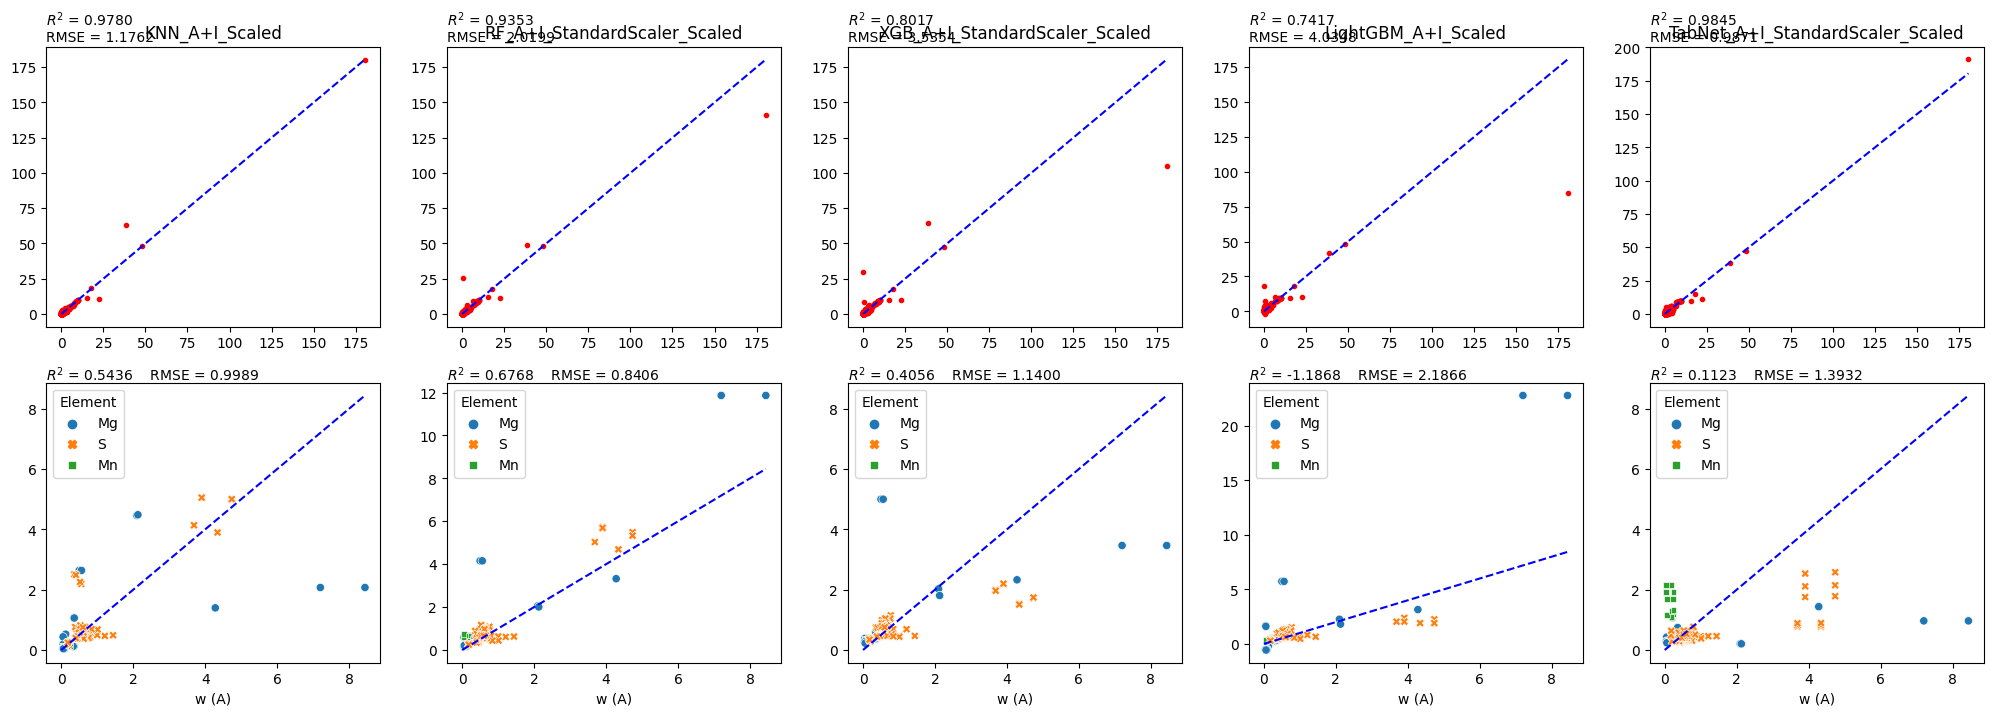

'preds, preds_elem, fix, ax = plot_model_prediction(models_d,\n                                                    X_train, Y_train,\n                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),\n                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'

In [39]:
models = ['KNN_A+I_Scaled',
          'RF_A+I_StandardScaler_Scaled',
          'XGB_A+I_StandardScaler_Scaled',
          'LightGBM_A+I_Scaled',
          'TabNet_A+I_StandardScaler_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    X_test, Y_test,
                                                    X_elem, Y_elem, label_width_elements,
                                                  scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [40]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

<ipython-input-40-885ad2aa8738>:2: RuntimeWarning: overflow encountered in exp
  preds[name] = (np.exp(preds[name]) - 1) * epsilon


In [41]:
YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('predref_scaled.svg', transparent = True, format = 'svg')

ValueError: ignored

In [ ]:
def train_and_test_regressor_local(models, X_train, y_train, X_test, y_test, max_epochs = 200, patience = 20, train = True):
  predictions = {}
  for name, model in models.items():
    if train == True:
        print(f"Fitting {name}")
        if 'TabNet' in name:
            model.fit(X_train, y_train, X_test, y_test)
        else:
            model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
      
  boot_scores = {}

  for name, y_pred in predictions.items():
      print(f"Calculating bootstrap score for {name}")
      boot_score = bootstrap_metric((np.exp(y_test - 1)) * epsilon, 
                                      (np.exp(y_pred - 1)) * epsilon, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                                y_pred=y,
                                                                                squared = False))
      boot_scores[name] = boot_score
      
  
  results = pd.DataFrame(boot_scores)
  # cast to long format
  results = results.melt(value_vars=results.columns,
                      value_name="mse", 
                      var_name="model") 
  return results

Calculating bootstrap score for KNN_Scaled
Calculating bootstrap score for RF_Scaled
Calculating bootstrap score for GB_Scaled
Calculating bootstrap score for XGB_Scaled
Calculating bootstrap score for LightGBM_Scaled
Calculating bootstrap score for TabNet_Scaled


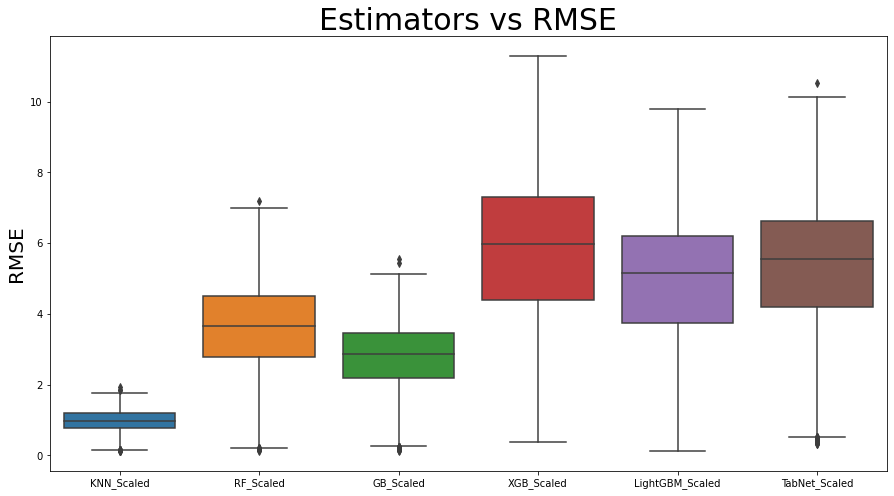

In [ ]:
results_scaled = train_and_test_regressor_local(models_d,
                                            data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train.sample(frac = 1, random_state = 777) / epsilon),
                                            data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                            train = False)
plot_model_comparison(results_scaled)

## Width. Scaled and augmented

**Attention!!!** Before running the next few cells, make sure that you set *augmented_train_set = True* and *scaled_target = True* in "Dataset modifications section.

Getting KNN_A+I_Extended predictions
Getting RF_A+I_StandardScaler_Extended predictions
Getting XGB_A+I_StandardScaler_Extended predictions
Getting LightGBM_A+I_Extended predictions
Plotting KNN_A+I_Extended predictions
Plotting RF_A+I_StandardScaler_Extended predictions
Plotting XGB_A+I_StandardScaler_Extended predictions
Plotting LightGBM_A+I_Extended predictions


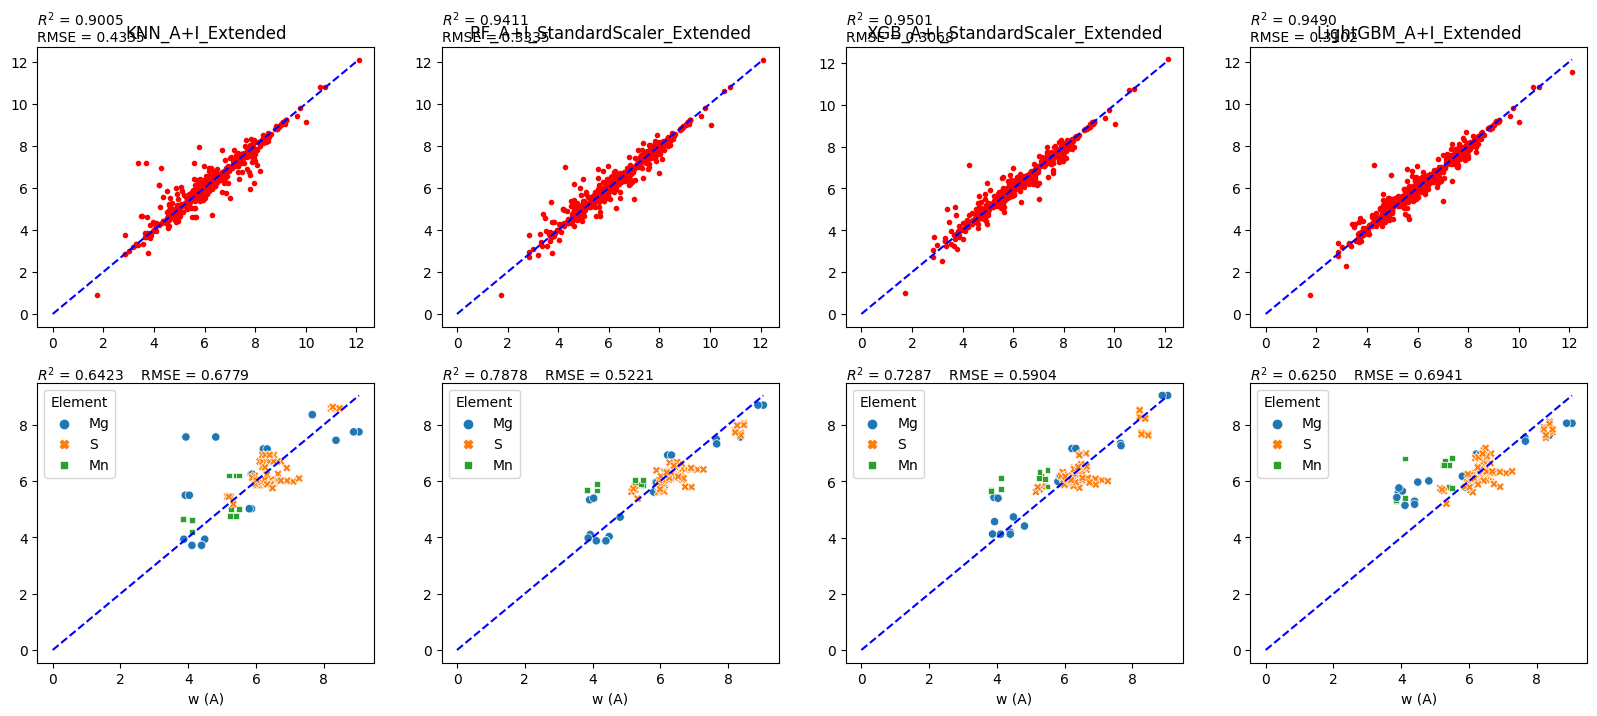

'preds, preds_elem, fix, ax = plot_model_prediction(models_d,\n                                                    X_train, Y_train,\n                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),\n                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'

In [46]:
models = ['KNN_A+I_Extended',
          'RF_A+I_StandardScaler_Extended',
          'XGB_A+I_StandardScaler_Extended',
          'LightGBM_A+I_Extended',
          'TabNet_A+I_StandardScaler_Extended']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    X_test, Y_test,
                                                    X_elem, Y_elem, label_width_elements,
                                                  scaler = scaler)

'''preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                    X_train, Y_train,
                                                    a_data_width_test, np.log(1 + a_target_width_test / epsilon),
                                                    a_data_width_elements, np.log(1 + a_target_width_elements / epsilon), a_label_width_elements)'''

In [47]:
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

Plotting KNN_A+I_Extended predictions
Plotting RF_A+I_StandardScaler_Extended predictions
Plotting XGB_A+I_StandardScaler_Extended predictions
Plotting LightGBM_A+I_Extended predictions


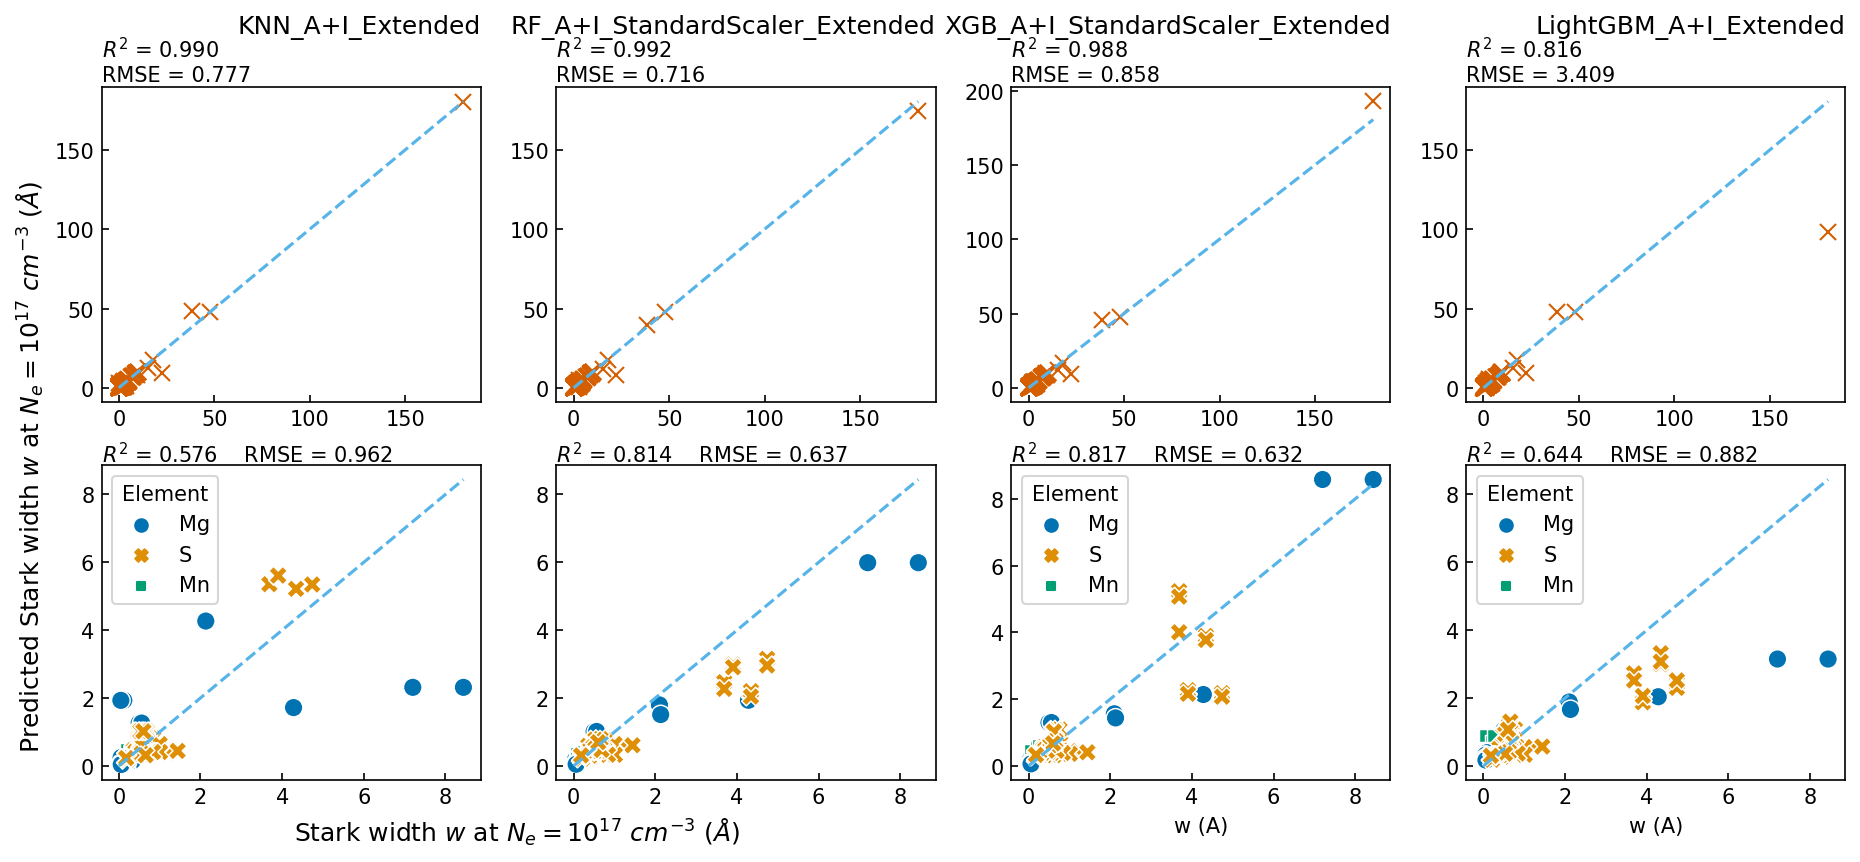

In [48]:
YW_test = (np.exp(Y_test) - 1) * epsilon
YW_elem = (np.exp(Y_elem) - 1) * epsilon
LW_elem = label_width_elements

'''YW_test = a_target_width_test
YW_elem = a_target_width_elements
LW_elem = a_label_width_elements'''

predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (3.75*len(models_d), 3*2), dpi = 150)
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], ls = 'None', marker = 'x', c = '#d55e00', ms = 8)
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = '#56b4e9', ls = '--')
    ax[0, i].set_title(f'{name}', fontsize = 12, pad = 26, fontweight = 'book', loc = 'right')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1.02, s = f'$R^2$ = {R2[name]:.3f}  \nRMSE = {RMSE[name]:.3f}',  transform = ax[0, i].transAxes)
    ax[0, i].tick_params(axis = 'both', direction = 'in')
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(x = YW_elem, y = preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'], palette = 'colorblind', s = 80)
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = '#56b4e9', ls = '--')
    ax[1, i].text(x = 0, y = 1.01, s = f'$R^2$ = {R2_elem[name]:.3f}    RMSE = {RMSE_elem[name]:.3f}',  transform = ax[1, i].transAxes)
    ax[1, i].tick_params(axis = 'both', direction = 'in')

    i += 1

ax[1, 1].get_legend().remove()
ax[1, 1].set(xlabel = None)
ax[1, 0].set_xlabel(r'Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', x=1.1, fontsize = 12)
ax[0, 0].set_ylabel(r'Predicted Stark width $w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$ ', horizontalalignment='center', y=-0.2, fontsize = 12)
plt.show()

#fig.savefig('predref_extended.svg', transparent = True, format = 'svg')

Calculating bootstrap score for KNN_Extended
Calculating bootstrap score for RF_Extended
Calculating bootstrap score for GB_Extended
Calculating bootstrap score for XGB_Extended
Calculating bootstrap score for LightGBM_Extended
Calculating bootstrap score for TabNet_Extended


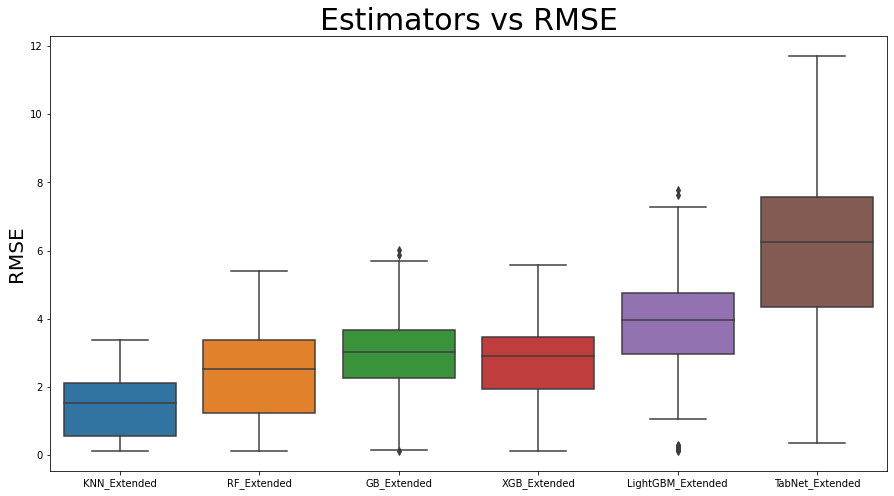

In [ ]:
results_augmented = train_and_test_regressor_local(models_d,
                                                data_width_train_extended.drop(columns=['Element', 'Wavelength', 'Z number']).sample(frac = 1, random_state = 777), np.log(1 + target_width_train_extended.sample(frac = 1, random_state = 777) / epsilon),
                                                data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width_test / epsilon),
                                                train = False)
plot_model_comparison(results_augmented)

# XGBoost all versions

In [ ]:
models = ['XGB_StandardScaler_Extended', 'KNN_Extended']
models_d = create_models_dict(models)

scaler = StandardScaler()
scaler.fit(a_data_width_train_extended.drop(columns = ['Element', 'Wavelength', 'Z number']))
preds_A_G, preds_elem_A_G, fix, ax = plot_model_prediction(models_d,
                                                   a_data_width_train_extended.drop(columns = ['Element', 'Wavelength', 'Z number']),
                                                   np.log(1 + a_target_width_train_extended / epsilon),
                                                   a_data_width_test,
                                                   np.log(1 + a_target_width_test / epsilon),
                                                   a_data_width_elements,
                                                   np.log(1 + a_target_width_elements / epsilon), a_label_width_elements,
                                                   scaler = scaler)
scaler = StandardScaler()
scaler.fit(a_data_width_train_extended.drop(columns = ['Element', 'Wavelength', 'Z number', 'Gap to ion']))
preds_A, preds_elem_A, fix, ax = plot_model_prediction(models_d,
                                                   a_data_width_train_extended.drop(columns = ['Element', 'Wavelength', 'Z number', 'Gap to ion']),
                                                   np.log(1 + a_target_width_train_extended / epsilon),
                                                   a_data_width_test.drop(columns = ['Gap to ion']),
                                                   np.log(1 + a_target_width_test / epsilon),
                                                   a_data_width_elements.drop(columns = ['Gap to ion']),
                                                   np.log(1 + a_target_width_elements / epsilon), a_label_width_elements,
                                                   scaler = scaler)

models = ['XGB_A+I_StandardScaler_Extended', 'KNN_Extended']
models_d = create_models_dict(models)

scaler = StandardScaler()
scaler.fit(X_train.drop(columns = ['Gap to ion']))
preds_I, preds_elem_I, fix, ax = plot_model_prediction(models_d,
                                                       X_train.drop(columns = ['Gap to ion']),
                                                       Y_train,
                                                       a_data_width_test.drop(columns = ['Gap to ion']),
                                                       np.log(1 + a_target_width_test / epsilon),
                                                       a_data_width_elements.drop(columns = ['Gap to ion']),
                                                       np.log(1 + a_target_width_elements / epsilon), a_label_width_elements,
                                                       scaler = scaler)

scaler = StandardScaler()
scaler.fit(X_train)
preds_I_G, preds_elem_I_G, fix, ax = plot_model_prediction(models_d,
                                                           X_train,
                                                           Y_train,
                                                           a_data_width_test,
                                                           np.log(1 + a_target_width_test / epsilon),
                                                           a_data_width_elements,
                                                           np.log(1 + a_target_width_elements / epsilon), a_label_width_elements,
                                                           scaler = scaler)

In [ ]:
preds = {}
preds['Atoms'] = preds_A['XGB_StandardScaler_Extended']
preds['Atoms, Gap'] = preds_A_G['XGB_StandardScaler_Extended']
preds['Atoms + Ions'] = preds_I['XGB_A+I_StandardScaler_Extended']
preds['Atoms + Ions, Gap'] = preds_I_G['XGB_A+I_StandardScaler_Extended']
preds_elem = {}
preds_elem['Atoms'] = preds_elem_A['XGB_StandardScaler_Extended']
preds_elem['Atoms, Gap'] = preds_elem_A_G['XGB_StandardScaler_Extended']
preds_elem['Atoms + Ions'] = preds_elem_I['XGB_A+I_StandardScaler_Extended']
preds_elem['Atoms + Ions, Gap'] = preds_elem_I_G['XGB_A+I_StandardScaler_Extended']

boot_scores = {}
for name, y_pred in preds.items():
    boot_score = bootstrap_metric(a_target_width_test,
                                  (np.exp(y_pred) - 1) * epsilon, 
                                  metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                            y_pred=y,
                                                                            squared = False))
    boot_scores[name] = boot_score
    
results = pd.DataFrame(boot_scores)
results = results.melt(value_vars=results.columns,
                       value_name="mse",
                       var_name="training mode") 

boot_scores = {}
for name, y_pred in preds_elem.items():
    boot_score = bootstrap_metric(a_target_width_elements,
                                  (np.exp(y_pred) - 1) * epsilon, 
                                  metric_fn=lambda x, y: mean_squared_error(y_true=x,
                                                                            y_pred=y,
                                                                            squared = False))
    boot_scores[name] = boot_score
    
results_elem = pd.DataFrame(boot_scores)
results_elem = results_elem.melt(value_vars=results_elem.columns,
                       value_name="mse",
                       var_name="training mode") 

results.insert(loc = len(results.columns), column = 'Test set', value = 'Test')
results_elem.insert(loc = len(results_elem.columns), column = 'Test set', value = 'New Elements')
all_results = pd.concat([results, results_elem], axis = 0, ignore_index = True)

fig, ax = plt.subplots()
sns.boxplot(data = all_results, y = 'mse', x="training mode", hue = 'Test set', ax = ax, palette = 'colorblind')
ax.set_xlabel("Training mode", size=20)
ax.set_ylabel("RMSE", size=20)
ax.set_title("", size=30)
plt.tight_layout()
#fig.savefig('XGBoost training modes.svg', transparent = True, format = 'svg')
plt.show()

# RMSE vs Temperature

In [ ]:
models = ['XGB_A+I_StandardScaler_Extended', 'KNN_Extended']
models_d = create_models_dict(models)

scaler = StandardScaler()
scaler.fit(X_train)

preds, preds_elem, fix, ax = plot_model_prediction(models_d,
                                                   X_train,
                                                   Y_train,
                                                   X_test,
                                                   Y_test,
                                                   X_elem,
                                                   Y_elem, label_width_elements,
                                                   scaler = scaler)

In [ ]:
curr_model = models_d['XGB_A+I_StandardScaler_Extended']
curr_preds = curr_model.predict(pd.DataFrame(scaler.transform(X_test)))
errors = (Y_test.values - (np.exp(curr_preds) - 1) * epsilon)**2
test_with_preds = X_test.assign(Squared_error = errors)
#test_with_preds.insert(loc = len(test_with_preds.columns), column = 'Temperature', value = 0)

data_for_plot = test_with_preds.loc[test_with_preds['T'] < 130000]

In [ ]:
n, bins, patches = plt.hist(data_for_plot['T'], bins = 8, log = False, rwidth = 0.8)
bin_index = []

for i, row in data_for_plot.iterrows():
    for j in range(len(bins) - 1):
        if row['T'] >= bins[j] and row['T'] <= bins[j+1]:
            bin_index.append((bins[j] + bins[j+1])/2)
            continue

data_for_plot['Temperature'] = bin_index

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data = data_for_plot, y = 'Squared_error', x = 'Temperature', ax = ax, palette = 'colorblind')
ax.set_ylim(bottom = -1, top = 55)
plt.tight_layout()

#fig.savefig('Error vs Temperature.svg', transparent = True, format = 'svg')
plt.show()

# RMSE vs charge

In [ ]:
c_model = models_d['XGB_A+I_StandardScaler_Extended']
c_preds = c_model.predict(pd.DataFrame(scaler.transform(X_test)))
errors = (Y_test.values - (np.exp(c_preds) - 1) * epsilon)**2
test_with_preds = X_test.assign(sqerrors = errors)

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(data = test_with_preds, y = 'sqerrors', x = 'Charge', ax = ax, palette = 'colorblind')
ax.set_ylim(bottom = -2, top = 54)

ax.set_xlabel('Charge')
ax.set_ylabel('Squared error')

ax.tick_params(axis = 'both', direction = 'in')

plt.show()

#fig.savefig('Error vs charge.svg', transparent = True, format = 'svg')

# Temperature dependence

In [ ]:
factor = 1.05                                          #For every item with temperature T in data add two more items with T*factor and T/factor
data_width_extended = data_width.copy()
target_width_extended = target_width
for index, row in data_width.iterrows():
    row['T'] = row['T']*factor
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)

    row['T'] = row['T']/factor**2
    data_width_extended = pd.concat([data_width_extended, row.to_frame().T], ignore_index=True)
    target_width_extended = pd.concat([target_width_extended, pd.Series(target_width.loc[index])], ignore_index=True)
data_width_extended = data_width_extended.astype(data_width.dtypes.to_dict())
data_width_extended = data_width_extended.drop(columns=['Element', 'Wavelength', 'Z number'])

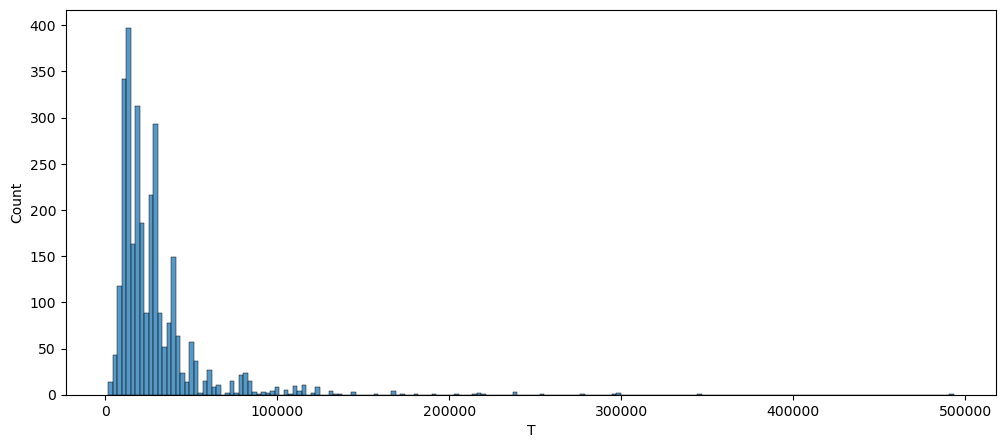

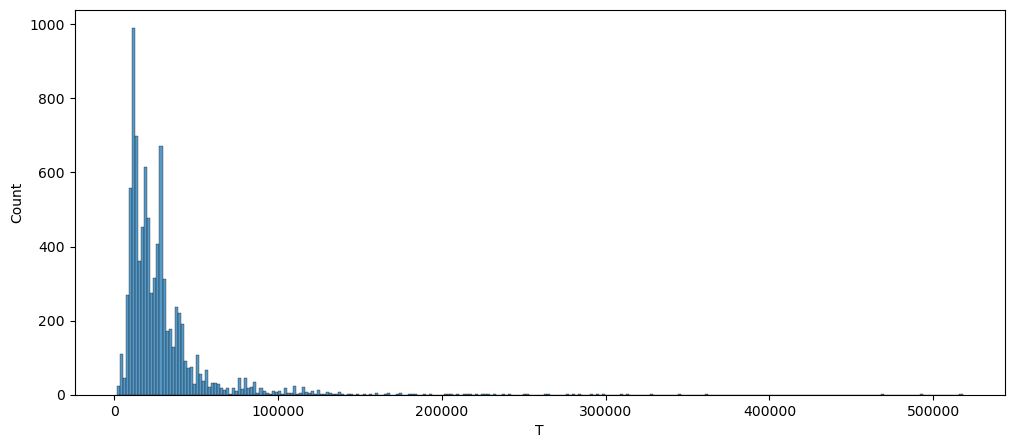

In [ ]:
#Visualise and confirm that augmentation doesn't change overall temperature distribution
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train, x = 'T')
plt.show()

fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data_width_train_extended, x = 'T')
plt.show()

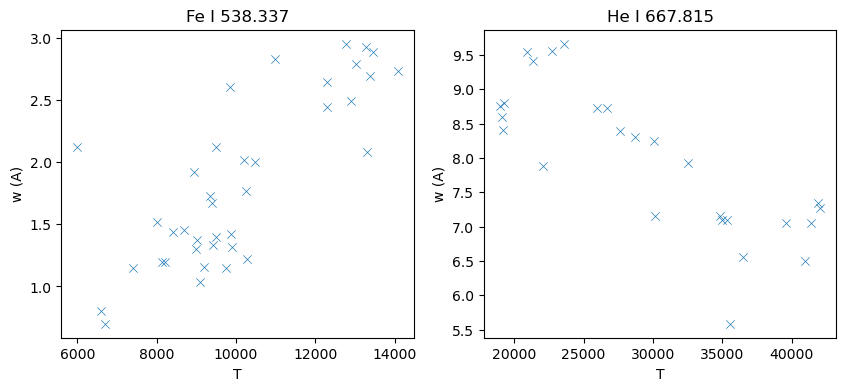

	Points plotted are only original data (without artificial points)


In [ ]:
#Select two lines with the highest number of entries in full dataset
Fe_wavelength = 538.3370
He_wavelength = 667.8150

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(x = data.loc[data['Wavelength'] == Fe_wavelength]['T'], y = data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(x = data.loc[data['Wavelength'] == He_wavelength]['T'], y = data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

print(f'\tPoints plotted are only original data (without artificial points)')

In [ ]:
#Define temperature range in each case
Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
He_temperatures = np.linspace(He_low, He_high, npoints)

#Fe_temperatures = np.linspace(5000, 15000, npoints)
#He_temperatures = np.linspace(15000, 45000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

C:\Users\Alex\AppData\Local\Temp\1\ipykernel_21540\3547621294.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
C:\Users\Alex\AppData\Local\Temp\1\ipykernel_21540\3547621294.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]


In [ ]:
scaler = StandardScaler()
scaler.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']))
models = ['RF_A+I_StandardScaler', 'XGB_A+I', 'TabNet_A+I_StandardScaler']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'StandardScaler' in name:
        if 'TabNet' in name:
            model.fit(pd.DataFrame(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number']))),
                      target_width,
                      pd.DataFrame(scaler.transform(data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']))),
                      target_width_test)
        else:
            model.fit(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number'])),
                      target_width)
    else:
        if 'TabNet' in name:
            model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']),
                      target_width,
                      data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']),
                      target_width_test)
        else:
            model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']),
                      target_width)

temperature_test_predictions = {}
for name, model in models_d.items():
    if 'StandardScaler' in name:
        temperature_test_predictions[name] = model.predict(pd.DataFrame(scaler.transform(temperature_test_data)))
    else:
        temperature_test_predictions[name] = model.predict(temperature_test_data)

Training KNN_A+I model
Training RF_A+I_StandardScaler model
Training XGB_A+I model
Training TabNet_A+I_StandardScaler model

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 1.76011


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
scaler = StandardScaler()
scaler.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']))
models_scaled = ['RF_A+I_StandardScaler_Scaled', 'XGB_A+I_StandardScaler_Scaled', 'TabNet_A+I_StandardScaler_Scaled']
models_d = create_models_dict(models_scaled)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'StandardScaler' in name:
        if 'TabNet' in name:
            model.fit(pd.DataFrame(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number']))),
                      np.log(1 + target_width / epsilon),
                      pd.DataFrame(scaler.transform(data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']))),
                      np.log(1 + target_width_test / epsilon))
        else:
            model.fit(scaler.transform(data_width.drop(columns=['Element', 'Wavelength', 'Z number'])),
                      np.log(1 + target_width / epsilon))
    else:
        if 'TabNet' in name:
            model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']),
                      np.log(1 + target_width / epsilon),
                      data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']),
                      np.log(1 + target_width_test / epsilon))
        else:
            model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']),
                      np.log(1 + target_width / epsilon))

temperature_test_predictions_scaled = {}
for name, model in models_d.items():
    if 'StandardScaler' in name:
        temperature_test_predictions_scaled[name] = model.predict(pd.DataFrame(scaler.transform(temperature_test_data)))
    else:
        temperature_test_predictions_scaled[name] = model.predict(temperature_test_data)

Training KNN_A+I_Extended model
Training RF_A+I_StandardScaler_Extended model
Training XGB_A+I_StandardScaler_Extended model
Training LightGBM_A+I_Extended model


In [ ]:
scaler = StandardScaler()
scaler.fit(data_width_extended)
models_extended = ['RF_A+I_StandardScaler_Extended', 'XGB_A+I_StandardScaler_Extended', 'TabNet_A+I_StandardScaler_Extended']
models_d = create_models_dict(models_extended)

for name, model in models_d.items():
    print(f"Training {name} model")
    if 'StandardScaler' in name:
        if 'TabNet' in name:
            model.fit(pd.DataFrame(scaler.transform(data_width_extended)),
                      np.log(1 + target_width_extended / epsilon),
                      pd.DataFrame(scaler.transform(data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']))),
                      np.log(1 + target_width_test / epsilon))
        else:
            model.fit(scaler.transform(data_width_extended),
                      np.log(1 + target_width_extended / epsilon))
    else:
        if 'TabNet' in name:
            model.fit(data_width_extended,
                      np.log(1 + target_width_extended / epsilon),
                      data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']),
                      np.log(1 + target_width_test / epsilon))
        else:
            model.fit(data_width_extended,
                      np.log(1 + target_width_extended / epsilon))

temperature_test_predictions_extended = {}
for name, model in models_d.items():
    if 'StandardScaler' in name:
        temperature_test_predictions_extended[name] = model.predict(pd.DataFrame(scaler.transform(temperature_test_data)))
    else:
        temperature_test_predictions_extended[name] = model.predict(temperature_test_data)

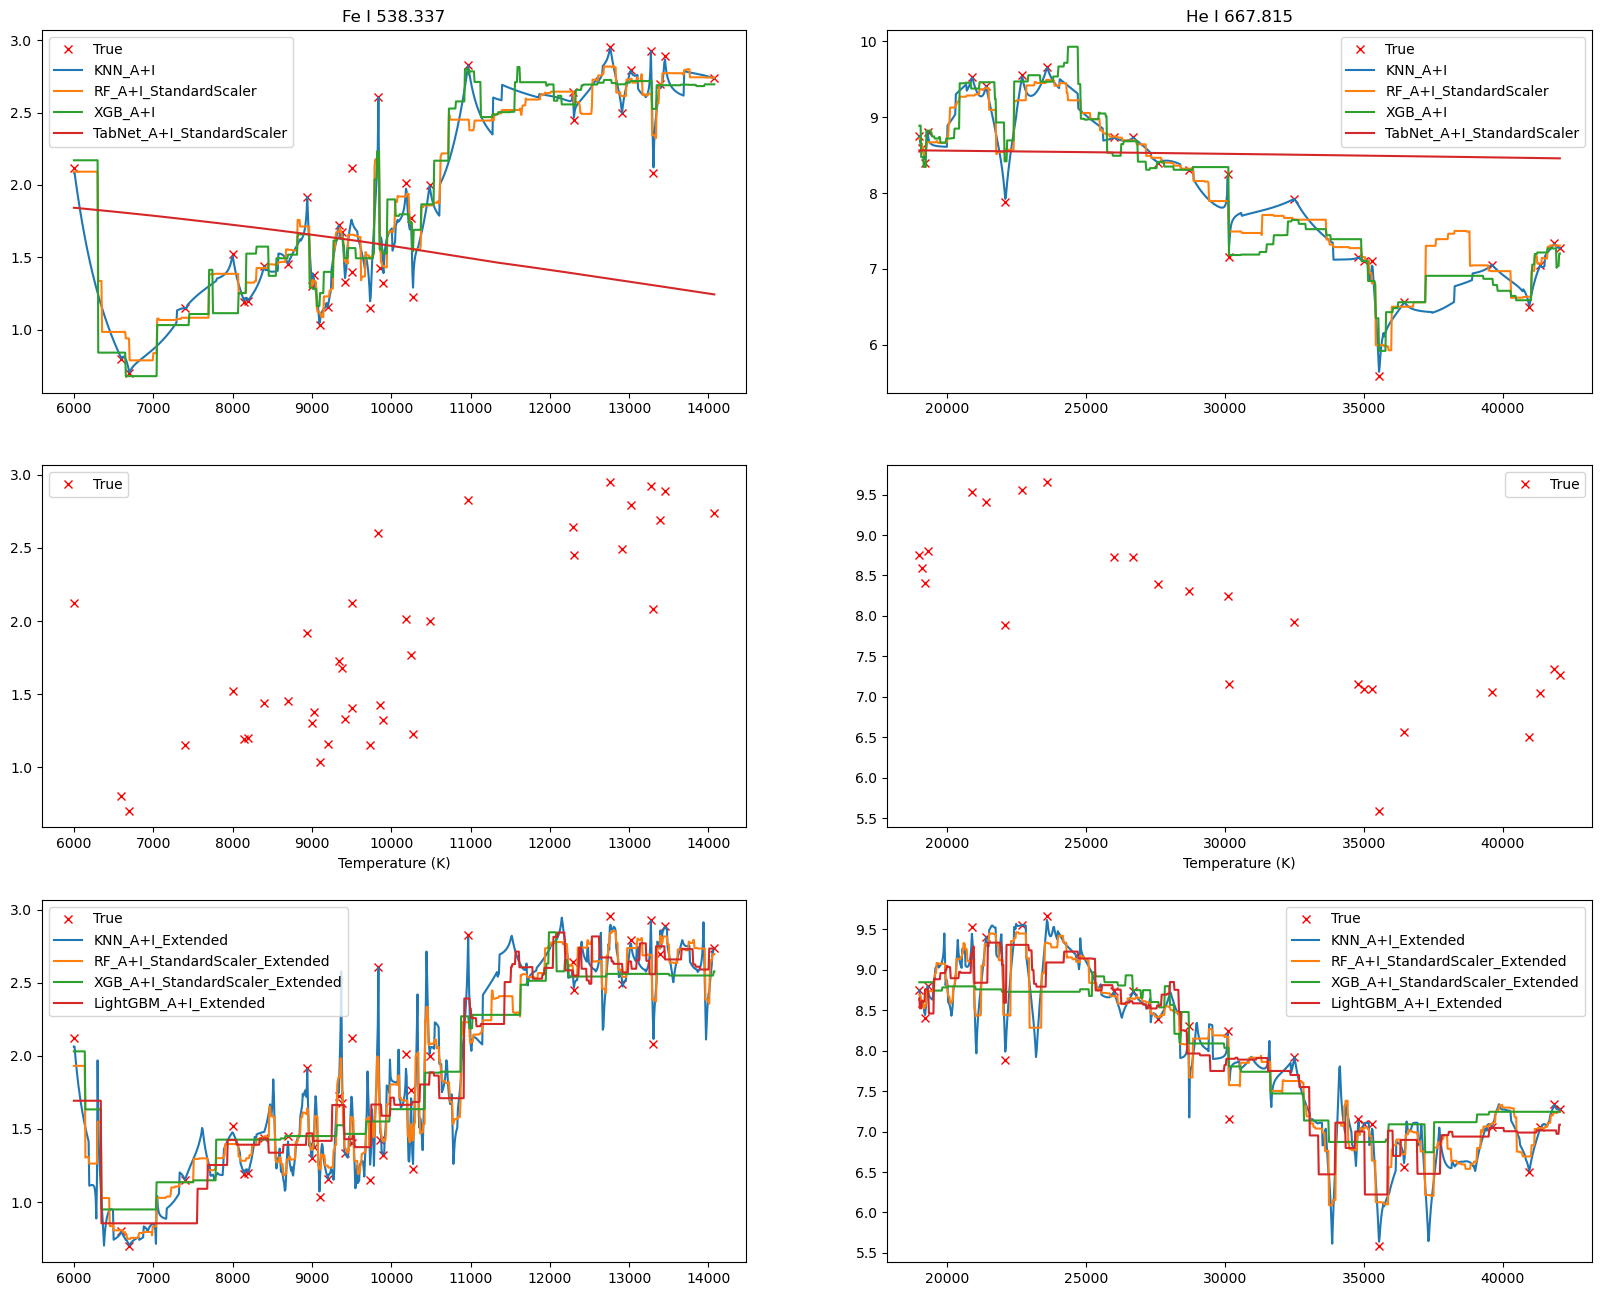

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (20, 16))
for i in range(3):
    ax[i, 0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
    ax[i, 1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

style = ['--', '-', '-.']
for i in range(len(models)):
    ax[0, 0].plot(Fe_temperatures, temperature_test_predictions[models[i]][:1000], label = f'{models[i]}', ls = style[i])
    ax[0, 1].plot(He_temperatures, temperature_test_predictions[models[i]][1000:], label = f'{models[i]}', ls = style[i])
    
    ax[1, 0].plot(Fe_temperatures, (np.exp(temperature_test_predictions_scaled[models_scaled[i]][:1000]) - 1) * epsilon, label = f'{models_scaled[i]}', ls = style[i])
    ax[1, 1].plot(He_temperatures, (np.exp(temperature_test_predictions_scaled[models_scaled[i]][1000:]) - 1) * epsilon, label = f'{models_scaled[i]}', ls = style[i])

    ax[2, 0].plot(Fe_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][:1000]) - 1) * epsilon, label = f'{models_extended[i]}', ls = style[i])
    ax[2, 1].plot(He_temperatures, (np.exp(temperature_test_predictions_extended[models_extended[i]][1000:]) - 1) * epsilon, label = f'{models_extended[i]}', ls = style[i])
    
       

ax[0, 0].set_title(f'Fe I {Fe_wavelength}')
ax[0, 1].set_title(f'He I {He_wavelength}')

ax[0, 0].tick_params(axis = 'both', direction = 'in')
ax[0, 1].tick_params(axis = 'both', direction = 'in')
ax[1, 0].tick_params(axis = 'both', direction = 'in')
ax[1, 1].tick_params(axis = 'both', direction = 'in')
ax[2, 0].tick_params(axis = 'both', direction = 'in')
ax[2, 1].tick_params(axis = 'both', direction = 'in')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[2, 0].legend()
ax[2, 1].legend()

ax[2, 0].set_xlabel('Temperature (K)')
ax[2, 1].set_xlabel('Temperature (K)')

ax[1, 0].set_ylabel(f'$w$ at $N_e = 10^{17}$ $cm^{-3}$ $(\AA)$')

plt.show()

#fig.savefig('Temperature_dependence.svg', format = 'svg', transparent = True)